# Multi-label (CellType.Tissue) classification with Exclusive Lasso
Amir Alavi
5/12/2021

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pickle
from pathlib import Path
from joblib import dump, load
from functools import partial
import copy

import anndata
import scanpy as sc
import diffxpy.api as de

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import linalg as LA

from skorch import NeuralNetClassifier
from skorch.callbacks import Callback, EpochScoring, LRScheduler, PassthroughScoring, Checkpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper")
import numpy as np
import scipy
import pandas as pd

import feature_importance

In [3]:
random_state=42
torch.manual_seed(random_state)

# References

Key pieces of work support the method developed in what follows; in no particular order:
1. Using **Logistic Regression** for identifying differentially expressed genes in scRNA-seq data [[paper]](https://www.nature.com/articles/s41592-018-0303-9)
    
2. **Exclusive lasso penalty** for multi-task learning [[paper]](http://proceedings.mlr.press/v9/zhou10a.html)

# Data

In [30]:
data_root = Path("data/label_pipeline_results")
adata = feature_importance.load_hubmap_data(data_root)
data_root = Path("data/van_der_Wijst_PBMC/count_matrices_per_lane/")
adata = anndata.concat([adata, feature_importance.load_van_der_Wijst_PBMC_data(data_root)])
feature_importance.finalize_adata(adata)
print(adata.shape)
feature_importance.add_alt_gene_IDs(adata)

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/_core/merge.py:898: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/anndata/utils.py:117: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['ATACACGACGCTCTTC-1', 'CAGTGGTATCAACGCA-1', 'AAGCAGTGGTATCAAC-1', 'AAGCAGTGGTATCAAC-2', 'AAGCAGTGGTATCAAC-3']
  + str(example_colliding_values)


(192909, 12115)
querying mygene...


In [5]:
adata.shape

(192909, 12115)

In [31]:
all_genes_info = adata.var

In [7]:
print(all_genes_info.columns)

Index(['enz', 'symbol', 'ens'], dtype='object')


In [8]:
print(adata.obs['tissue'].value_counts())
print(adata.obs['tissue'].value_counts().sum())

lung          76178
spleen        34515
PBMC          25185
lymph_node    24311
thymus        22367
kidney        10353
Name: tissue, dtype: int64
192909


In [32]:
B_cell_name = 'B Cell'
T_cell_name = 'T Cell'
NK_cell_name = 'NK Cell'
Macrophage_cell_name = "Macrophage"
Fibroblast_cell_name = "Fibroblast"

unify_map = {
    'B': B_cell_name,
    'B cell': B_cell_name,
    'B_Plasma': B_cell_name,
    'T': T_cell_name,
    'alpha-beta T cell': T_cell_name,
    'gamma-delta T cell': T_cell_name,
    'CD4+ T': T_cell_name,
    'CD8+ T': T_cell_name,
    'T_Cytotoxic': T_cell_name,
    'T_Regulatory': T_cell_name,
    'NK': NK_cell_name,
    'natural killer cell': NK_cell_name,
    'CD56(bright) NK': NK_cell_name,
    'CD56(dim) NK': NK_cell_name,
    'macrophage': Macrophage_cell_name,
    'Macrophage_Alveolar': Macrophage_cell_name,
    'splenic fibroblast': Fibroblast_cell_name
}

adata.obs["celltype"].replace(to_replace=unify_map, inplace=True)

In [17]:
# DE detour
cell_types_list = ['T Cell', 'Fibroblast', 'B Cell', 'NK Cell']
adata_de = adata[adata.obs["celltype"].isin(cell_types_list)]
sc.pp.normalize_total(adata_de, target_sum=1e4)
sc.pp.log1p(adata_de)
sc.pp.highly_variable_genes(adata_de, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_de.obs['celltype_and_tissue'] = adata_de.obs[['celltype', 'tissue']].agg(','.join, axis=1)
label_counts = adata_de.obs['celltype_and_tissue'].value_counts()
min_label_count = 100
labels_to_keep = label_counts[label_counts >= min_label_count].index
adata_de = adata_de[adata_de.obs['celltype_and_tissue'].isin(labels_to_keep)]
adata_de.raw = adata_de
sc.tl.rank_genes_groups(adata_de, 'celltype_and_tissue', method='wilcoxon')

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... storing 'celltype' as categorical
... storing 'celltype_and_tissue' as categorical
... storing 'enz' as categorical
... storing 'symbol' as categorical


In [27]:
phenotypes = adata_de.obs['celltype_and_tissue'].unique()
de_top_genes = []
for i, pheno in enumerate(phenotypes):
    dedf = sc.get.rank_genes_groups_df(adata_de, group=pheno, gene_symbols='symbol', log2fc_min=0.)
    top_genes = dedf['symbol'][:20].tolist()
    de_top_genes.append(set(top_genes))

exclusive_results = {}
for i, class_label in enumerate(phenotypes):
    exclusive = de_top_genes[i].difference(set().union(*(de_top_genes[:i] + de_top_genes[i+1:])))
    exclusive_results[class_label] = list(exclusive)
    print(class_label)
    print(exclusive)

de_exclusive_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in exclusive_results.items() ]))

Fibroblast,kidney
{'CALD1', 'PRXL2A', 'KCNQ1OT1', 'SYNE1', 'THBS1', 'SYNE2', 'ITPR2', 'ITGA1', 'VMP1', 'IL6ST', 'CRYBG3', 'CYP1B1', 'VCAN', 'DST', 'RRBP1', 'SPP1'}
B Cell,lung
{'RPL37A', 'EEF1G', 'RPS20'}
T Cell,lung
{'TNFAIP3', 'TOB1', 'ZFP36'}
NK Cell,lung
{'CD7'}
Fibroblast,lung
{'C3', 'SELENOM', 'CLU', 'MT1X'}
B Cell,lymph_node
{'FAU'}
T Cell,lymph_node
{'RPS21', 'RPL32', 'RPL37', 'RPS13', 'RPL19', 'RPS15A', 'RPS15', 'RPS4X', 'RPL35A', 'RPS27A', 'RPL30'}
NK Cell,lymph_node
{'DDX5', 'DUSP1', 'GSTP1', 'HSPA5'}
B Cell,spleen
{'RPS11', 'RPL7A'}
T Cell,spleen
set()
NK Cell,spleen
{'HSPA1A'}
Fibroblast,thymus
{'VIM', 'COL6A1', 'CEBPD', 'EGR1', 'ANXA2', 'SPARC'}
T Cell,thymus
{'RPS24', 'NUCB2', 'ACTG1', 'C12orf57', 'TMSB10', 'ITM2A', 'PTMA', 'SOX4', 'CD3G'}
B Cell,thymus
{'TSC22D3', 'HLA-E'}
NK Cell,thymus
{'SRSF7', 'BTG1'}
T Cell,PBMC
{'RPL38', 'RPL36A', 'RPS26', 'PABPC1', 'RPL34'}
NK Cell,PBMC
{'HLA-B', 'APOBEC3G', 'ARPC2', 'TGFB1', 'WIPF1', 'GNG2', 'HLA-C', 'CLEC2B', 'CHST12', 'LIMD2'}

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


In [29]:
de_exclusive_df.to_pickle("human_de_top_20_exclusive_df.pkl")

In [33]:
# DE detour (hvg)
print(f"Initial data shape: {adata.shape}")
old_n_genes = adata.shape[1]
adata, hvg_genes = feature_importance.filter_hvg(adata)
print(f"After hvg shape: {adata.shape}")
print(f"\tRemoved {old_n_genes - adata.shape[1]} genes")
cell_types_list = ['T Cell', 'Fibroblast', 'B Cell', 'NK Cell']
adata_de = adata[adata.obs["celltype"].isin(cell_types_list)]
sc.pp.normalize_total(adata_de, target_sum=1e4)
sc.pp.log1p(adata_de)
sc.pp.highly_variable_genes(adata_de, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_de.obs['celltype_and_tissue'] = adata_de.obs[['celltype', 'tissue']].agg(','.join, axis=1)
label_counts = adata_de.obs['celltype_and_tissue'].value_counts()
min_label_count = 100
labels_to_keep = label_counts[label_counts >= min_label_count].index
adata_de = adata_de[adata_de.obs['celltype_and_tissue'].isin(labels_to_keep)]
adata_de.raw = adata_de
sc.tl.rank_genes_groups(adata_de, 'celltype_and_tissue', method='wilcoxon')

Initial data shape: (192909, 12115)
After hvg shape: (192909, 2007)
	Removed 10108 genes


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... storing 'celltype' as categorical
... storing 'celltype_and_tissue' as categorical
... storing 'enz' as categorical


In [34]:
phenotypes = adata_de.obs['celltype_and_tissue'].unique()
de_top_genes = []
for i, pheno in enumerate(phenotypes):
    dedf = sc.get.rank_genes_groups_df(adata_de, group=pheno, gene_symbols='symbol', log2fc_min=0.)
    top_genes = dedf['symbol'][:20].tolist()
    de_top_genes.append(set(top_genes))

exclusive_results = {}
for i, class_label in enumerate(phenotypes):
    exclusive = de_top_genes[i].difference(set().union(*(de_top_genes[:i] + de_top_genes[i+1:])))
    exclusive_results[class_label] = list(exclusive)
    print(class_label)
    print(exclusive)

de_exclusive_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in exclusive_results.items() ]))

Fibroblast,kidney
{'CALD1', 'PRXL2A', 'NFIA', 'SYNE1', 'THBS1', 'SYNE2', 'ITPR2', 'ITGA1', 'PTGS2', 'IL6ST', 'TPM1', 'CYP1B1', 'NRP1', 'DST', 'VCAN', 'RRBP1', 'SPP1'}
B Cell,lung
{'SAT1', 'IFI30'}
T Cell,lung
{'TXN', 'RGS1', 'CBLB', 'HMGB2'}
NK Cell,lung
{'CTSD', 'PIP4K2A', 'PLAC8', 'NOL4L', 'CDC42SE1'}
Fibroblast,lung
{'MT1X', 'SELENOM', 'CLU', 'C3', 'PMP22'}
B Cell,lymph_node
{'LINC00926', 'PHACTR1'}
T Cell,lymph_node
{'NOSIP', 'LDHB', 'H4C3', 'SOCS3'}
NK Cell,lymph_node
{'ARPC5L', 'KLRC1', 'RHOC', 'H2AX', 'DHRS3'}
B Cell,spleen
{'POU2F2', 'CD22'}
T Cell,spleen
{'ILF3-DT'}
NK Cell,spleen
{'METRNL', 'HSPA6', 'CEMIP2', 'PIK3R1', 'IRF1', 'CNOT6L'}
Fibroblast,thymus
{'SPARC', 'EGR1', 'ANXA2'}
T Cell,thymus
{'NUCB2', 'MYL6', 'TUBA1A', 'GADD45G', 'ITM2A', 'CCND3', 'STMN1', 'SOX4', 'ARMH1'}
B Cell,thymus
{'ATP2B1-AS1', 'HSPB1', 'TUBA1B', 'CTSH', 'ENSG00000258017'}
NK Cell,thymus
{'IER3', 'ISG15', 'BRD2', 'PLAAT4'}
T Cell,PBMC
{'GIMAP7', 'LAT', 'CREM', 'S100A11', 'GIMAP5', 'CMSS1', 'PPP2R5C'

In [35]:
de_exclusive_df.to_pickle("human_hvg_de_top_20_exclusive_df.pkl")

In [17]:
adata_subset = feature_importance.subsample_data_by_tissues(adata, n_subsample=10000, bias_celltypes=['T Cell', 'Fibroblast', 'B Cell', 'NK Cell'])

/home/amir/hubmap/feature_importance.py:136: RuntimeWarning: divide by zero encountered in true_divide
  inverse_frequencies = [ (1. / freq * max_freq ) for freq in frequencies]


In [10]:
print(f"Initial data shape: {adata.shape}")
old_n_genes = adata.shape[1]
adata, hvg_genes = feature_importance.filter_hvg(adata)
print(f"After hvg shape: {adata.shape}")
print(f"\tRemoved {old_n_genes - adata.shape[1]} genes")

Initial data shape: (192909, 12115)
After hvg shape: (192909, 2007)
	Removed 10108 genes


In [19]:
adata_subset = adata_subset[:, hvg_genes]
print(adata_subset.shape)

(60000, 2127)


In [20]:
feature_importance.add_alt_gene_IDs(adata_subset)

querying mygene...


Trying to set attribute `.var` of view, copying.


In [83]:
adata.var.columns

Index(['enz', 'symbol', 'ens', 'highly_variable', 'dispersions_norm'], dtype='object')

In [8]:
def get_X_y_data(adata, random_state=None, min_label_count=100):
    adata.obs['celltype_and_tissue'] = adata.obs[['celltype', 'tissue']].agg(','.join, axis=1)
    
    label_counts = adata.obs['celltype_and_tissue'].value_counts()
    labels_to_keep = label_counts[label_counts >= min_label_count].index
    adata = adata[adata.obs['celltype_and_tissue'].isin(labels_to_keep)]
    
    X = adata.X
    y = adata.obs['celltype_and_tissue']
    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state)
    return le, X_train, X_test, y_train, y_test

In [89]:
def get_single_label_X_y_data(adata, label, random_state=None, min_label_count=100):
    label_counts = adata.obs[label].value_counts()
    labels_to_keep = label_counts[label_counts >= min_label_count].index
    adata = adata[adata.obs[label].isin(labels_to_keep)]
    
    X = adata.X
    y = adata.obs[label]
    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state)
    return le, X_train, X_test, y_train, y_test

In [12]:
cell_types_list = ['T Cell', 'Fibroblast', 'B Cell', 'NK Cell']

In [ ]:
le, X_train, X_test, y_train, y_test = get_X_y_data(adata_subset[adata_subset.obs["celltype"].isin(cell_types_list)],
                                                    random_state=random_state)

In [ ]:
X_train, X_test = X_train.todense(), X_test.todense()

In [ ]:
X_train, X_test = np.asarray(X_train), np.asarray(X_test)

In [ ]:
le_ct, X_train_ct, X_test_ct, y_train_ct, y_test_ct = get_single_label_X_y_data(adata_subset[adata_subset.obs["celltype"].isin(cell_types_list)], 'celltype', random_state=random_state)
print(type(X_train_ct))
X_train_ct, X_test_ct = X_train_ct.todense(), X_test_ct.todense()
X_train_ct, X_test_ct = np.asarray(X_train_ct), np.asarray(X_test_ct)

le_tiss, X_train_tiss, X_test_tiss, y_train_tiss, y_test_tiss = get_single_label_X_y_data(adata_subset[adata_subset.obs["celltype"].isin(cell_types_list)], 'tissue', random_state=random_state)
X_train_tiss, X_test_tiss = X_train_tiss.todense(), X_test_tiss.todense()
X_train_tiss, X_test_tiss = np.asarray(X_train_tiss), np.asarray(X_test_tiss)

In [ ]:
X_train_ct.shape

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
def de_test_baseline(X_train, y_train, le, var, celltypes, tissues):
    y_train_str = le.inverse_transform(y_train)
    for ct in celltypes:
        print(ct)
        idx = np.array([True if ct in s else False for s in y_train_str])
        X_sub = X_train[idx]
        group_sub = [ct] * X_sub.shape[0]
        X_sub_other = X_train[~idx]
        group_sub_other = ['other'] * X_sub_other.shape[0]
        X_sub = np.concatenate((X_sub, X_sub_other))
        group = group_sub + group_sub_other
        adata = anndata.AnnData(X=X_sub.copy(), obs={'group': group}, var=var)
        print(adata.shape)
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        
        sc.tl.rank_genes_groups(adata, 'group', method='wilcoxon', groups=[ct])
        sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, gene_symbols='symbol')
        df = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
        df['symbol'] = adata.var.loc[df[ct]]['symbol'].tolist()
        
        print(df.head(20))


de_test_baseline(X_train, y_train, le, adata_subset.var, cell_types_list, ['foo'])
        
        

In [24]:
le, X_train, X_test, y_train, y_test = get_X_y_data(adata[adata.obs["celltype"].isin(cell_types_list)],
                                                    random_state=random_state)
print(type(X_train))


Trying to set attribute `.obs` of view, copying.


<class 'anndata._core.views.SparseCSRView'>


In [28]:
isinstance(X_train, scipy.sparse.spmatrix)


True

In [13]:
# Use the full data, not subsampled
le, X_train, X_test, y_train, y_test = get_X_y_data(adata[adata.obs["celltype"].isin(cell_types_list)],
                                                    random_state=random_state)
X_train, X_test = X_train.todense(), X_test.todense()
X_train, X_test = np.asarray(X_train), np.asarray(X_test)

Trying to set attribute `.obs` of view, copying.


In [12]:
print(X_train.shape)
print(X_test.shape)

(94110, 2127)
(31371, 2127)


In [16]:
vc = pd.Series(le.inverse_transform(np.concatenate([y_train, y_test]))).value_counts()
print(vc.shape)
print(type(vc))
print(vc)
print(vc.sum())

(18,)
<class 'pandas.core.series.Series'>
T Cell,lung           19197
T Cell,PBMC           18234
B Cell,spleen         16341
T Cell,thymus         14009
B Cell,lymph_node     13283
T Cell,lymph_node     10727
NK Cell,lung           7054
B Cell,lung            6541
T Cell,spleen          5523
B Cell,thymus          4814
NK Cell,PBMC           2881
NK Cell,spleen         2625
Fibroblast,lung        2182
B Cell,PBMC             838
NK Cell,thymus          533
Fibroblast,thymus       446
NK Cell,lymph_node      136
Fibroblast,kidney       117
dtype: int64
125481


In [14]:
print(X_train.shape)
print(X_test.shape)

(73200, 2007)
(24401, 2007)


In [15]:
vc = pd.Series(le.inverse_transform(np.concatenate([y_train, y_test]))).value_counts()
print(vc.shape)
print(type(vc))
print(vc)
print(vc.sum())

(18,)
<class 'pandas.core.series.Series'>
T Cell,PBMC           18234
B Cell,spleen         16341
T Cell,thymus         14009
B Cell,lymph_node     13283
T Cell,lymph_node     10727
T Cell,spleen          5523
B Cell,thymus          4814
T Cell,lung            4342
NK Cell,PBMC           2881
NK Cell,spleen         2625
NK Cell,lung           1328
B Cell,lung             863
B Cell,PBMC             838
Fibroblast,lung         561
NK Cell,thymus          533
Fibroblast,thymus       446
NK Cell,lymph_node      136
Fibroblast,kidney       117
dtype: int64
97601


## Tabula Muris

In [32]:
adata = feature_importance.load_tabula_muris_data(['Lung', 'Limb_Muscle', 'Fat', 'Spleen'])

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data/tabula_muris/FACS/Lung-counts.csv
(1716, 23433)
(1716, 23433)
data/tabula_muris/FACS/Limb_Muscle-counts.csv
(1090, 23433)
(1090, 23433)
data/tabula_muris/FACS/Fat-counts.csv
(4967, 23433)
(4967, 23433)
data/tabula_muris/FACS/Spleen-counts.csv
(1697, 23433)
(1697, 23433)


Trying to set attribute `.var` of view, copying.


In [33]:
adata.obs['tissue'].value_counts()

Fat            4865
Spleen         1697
Lung           1676
Limb_Muscle    1090
Name: tissue, dtype: int64

In [34]:
adata.obs['tissue'].value_counts().sum()

9328

In [5]:
all_genes_info = adata.var

In [6]:
print(f"Initial data shape: {adata.shape}")
old_n_genes = adata.shape[1]
adata, hvg_genes = feature_importance.filter_hvg(adata)
print(f"After hvg shape: {adata.shape}")
print(f"\tRemoved {old_n_genes - adata.shape[1]} genes")

Initial data shape: (9328, 23433)
After hvg shape: (9328, 5127)
	Removed 18306 genes


In [9]:
cell_types_list = ['B cell', 'T cell', 'natural killer cell']
le, X_train, X_test, y_train, y_test = get_X_y_data(adata[adata.obs["celltype"].isin(cell_types_list)],
                                                    random_state=random_state, min_label_count=50)
#X_train, X_test = X_train.todense(), X_test.todense()
X_train, X_test = np.asarray(X_train), np.asarray(X_test)

Trying to set attribute `.obs` of view, copying.


In [10]:
print(X_train.shape)
print(X_test.shape)

(2097, 5127)
(700, 5127)


In [11]:
vc = pd.Series(le.inverse_transform(np.concatenate([y_train, y_test]))).value_counts()
print(vc.shape)
print(type(vc))
print(vc)
print(vc.sum())

(8,)
<class 'pandas.core.series.Series'>
B cell,Spleen              1297
B cell,Fat                  519
T cell,Fat                  353
T cell,Spleen               352
natural killer cell,Fat      95
B cell,Limb_Muscle           71
B cell,Lung                  57
T cell,Lung                  53
dtype: int64
2797


# Run analysis pipeline

In [30]:
def fit_checkpointed_model(X_train, y_train, X_test, y_test, le, checkpoint_dir, regularization, lambda_reg,
                           ct_bounds, ct_map, multilabel_class_weights, balanced_acc, ct_acc, ct_balanced_acc,
                           ct_acc_score_fn, ct_balanced_acc_score_fn, celltype_class_weights,
                           learning_rate, lr_plateau_factor=0.5, optimizer=torch.optim.Adam, epochs=200):
    cp = Checkpoint(dirname=checkpoint_dir)
    net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                         module__input_size=X_train.shape[1],
                                         module__output_size=len(le.classes_),
                                         regularization=regularization,
                                         ct_group_bounds=ct_bounds,
                                         ct_map=ct_map,
                                         criterion__weight=multilabel_class_weights,
                                         max_epochs=epochs,
                                         optimizer=optimizer,
                                         lr=learning_rate,
                                         iterator_train__shuffle=True,
                                         callbacks=[('balanced_acc', balanced_acc),
                                                    ('celltype_acc', ct_acc),
                                                    ('celltype_balanced_acc', ct_balanced_acc),
                                                    ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                                 factor=lr_plateau_factor, verbose=True)),
                                                    ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                    ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                    ('sparse_thresholder', SparseWeightsThresholder()),
                                                    ('checkpoint', cp),
                                                   ],
                                         lambda_clf=0.,
                                         secondary_criterion_weight=celltype_class_weights,
                                         lambda_reg=lambda_reg) #

    pipe = Pipeline([
            ('normalize_total', CellTotalCountNormalizer()),
            ('log', log_transformer),
            ('scale', StandardScaler()),
            ('net', net),
        ])
    pipe.fit(X_train, y_train)
    pipe['net'].initialize()
    pipe['net'].load_params(checkpoint=cp)
    test_balanced_acc = eval_model(pipe, X_train, y_train, X_test, y_test, le)
    test_ct_acc = ct_acc_score_fn(net, np.asarray(X_test), y_test)
    print(f"test CT acc: {test_ct_acc}")
    test_ct_balanced_acc = ct_balanced_acc_score_fn(net, np.asarray(X_test), y_test)
    print(f"test CT balanced acc: {test_ct_balanced_acc}")
    print()
    return pipe, test_balanced_acc 


def inspect_fitted_model(out_dir, regularization, fitted_model, adata, label_encoder, random_state):
    model_reg_plot_string = ""
    if regularization == 'l1':
        model_reg_plot_string = "L1 Regularized "
    elif regularization == 'exclusive_l1':
        model_reg_plot_string = "Exclusive L1 Regularized "
    model_name = f"{model_reg_plot_string}Softmax Regression Model"
    sparsity = check_sparsity(SkorchLRAdapter(fitted_model['net']), label_encoder,
                              model_name=model_name,
                              figure_savefile=out_dir / "coef")
    dump(fitted_model, out_dir / 'model.joblib')
 

    weights = fitted_model['net'].module_.linear.weight.detach().numpy()
    feature_symbols = adata.var[['symbol']]
    exclusive_weights_df = find_exclusive_model_weights(weights, label_encoder.classes_, feature_symbols)
    exclusive_weights_df.to_pickle(out_dir / 'exclusive_weights_table.pkl')
    exclusive_weights_df.to_latex(out_dir / 'exclusive_weights_table.tex', index=False, na_rep="", caption="")

    generate_model_gene_module_reports(adata, exclusive_weights_df, model_name, out_dir / "model_gene_module_reports", random_state)
    
    # De enrichment:
    _, exclusive_scores = get_exclusive_model_weights_for_gsea(weights, label_encoder.classes_, feature_symbols)
    enrich_folder = out_dir / "enrich"
    enrich_folder.mkdir(exist_ok=True, parents=True)
    for label, score_df in exclusive_scores.items():
        save_file = enrich_folder / f"{label}_GO_enrich.tex"
        do_enrich(score_df['symbol'].tolist(), score_df['weight'], all_genes_info['symbol'], save_file)
    return sparsity, exclusive_weights_df



def run_analysis_for_regularization(regularization, X_train, X_test, y_train, y_test, le, adata, all_genes_info, result_folder, random_state, cell_types_list=None, extra_penalty_factor=5., n_jobs=-1):
    if not isinstance(result_folder, Path):
        result_folder = Path(result_folder)
    best_settings_dir = result_folder / 'best_settings'
    best_settings_dir.mkdir(parents=True, exist_ok=True)
    extra_pen_dir = result_folder / 'extra_penalty'
    extra_pen_dir.mkdir(parents=True, exist_ok=True)
    
    # Set up evaluation metrics
    ct_bounds = []
    ct_classes = [s.split(',')[0] for s in le.classes_]
    print(ct_classes)
    if len(np.unique(ct_classes)) > 1:
        cur_ct = ct_classes[0]
        for i in range(len(ct_classes)):
            if ct_classes[i] != cur_ct:
                ct_bounds.append(i - 1)
                cur_ct = ct_classes[i] 
    ct_bounds.append(len(ct_classes) - 1)
    print(f"ct_bounds: {ct_bounds}")
#     ct_bounds = torch.tensor([4, 7, 12, 17])
    ct_map = build_ct_map(ct_bounds)

    ct_acc_score_fn, ct_balanced_acc_score_fn = get_ct_scorers(ct_bounds, ct_map)
    multilabel_class_weights, celltype_class_weights = get_class_weights(y_train, ct_map)
    # Balanced joint accuracy
    balanced_acc = EpochScoring(name='balanced_acc', scoring='balanced_accuracy', lower_is_better=False)
    # Cell type accuracy
    ct_acc = EpochScoring(name='CT_acc', scoring=ct_acc_score_fn, lower_is_better=False)
    # Balanced cell type accuracy
    ct_balanced_acc = EpochScoring(name='CT_balanced_acc', scoring=ct_balanced_acc_score_fn, lower_is_better=False)

#     # Just for debugging
#     param_grid = {
#         'net__max_epochs': [1],
#         'net__lr': [0.01],
#         'net__optimizer': [torch.optim.Adam],
#         'net__callbacks__lr_scheduler__factor': [0.5],
#         'net__lambda_clf': [0.],
#         'net__lambda_reg': [0.01],
#         'net__regularization': [regularization]
#     }
    param_grid = {
        'net__max_epochs': [10, 20, 100],
        'net__lr': [0.01, 0.001],
        'net__optimizer': [torch.optim.Adam],
        'net__callbacks__lr_scheduler__factor': [0.5],
        'net__lambda_clf': [0.],
        'net__lambda_reg': [0., 0.001, 0.01, 0.1],
        'net__regularization': [regularization]
    }


    net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                         module__input_size=X_train.shape[1],
                                         module__output_size=len(le.classes_),
                                         ct_group_bounds=ct_bounds,
                                         ct_map=ct_map,
                                         criterion__weight=multilabel_class_weights,
                                         iterator_train__shuffle=True,
                                         callbacks=[('balanced_acc', balanced_acc),
                                                    ('celltype_acc', ct_acc),
                                                    ('celltype_balanced_acc', ct_balanced_acc),
                                                    ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                                 factor=0.5, verbose=True)),
                                                    ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                    ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                    ('sparse_thresholder', SparseWeightsThresholder()),
                                                   ],
                                         secondary_criterion_weight=celltype_class_weights)
    pipe = Pipeline([
            ('normalize_total', CellTotalCountNormalizer()),
            ('log', log_transformer),
            ('scale', StandardScaler()),
            ('net', net),
        ])

    gs = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=4, n_jobs=n_jobs)
    gs.fit(X_train, y_train)
    dump(gs, result_folder / 'quick_gridsearch.joblib')
    with open(result_folder / "quick_gridsearch_best_params.txt", 'w') as text_file:
        text_file.write(str(gs.best_params_))
    print(gs.best_params_)

    results = {}
    # Fit a checkpointed model with the best parameters:
    best_pipe, best_acc = fit_checkpointed_model(X_train, y_train, X_test, y_test, le, best_settings_dir / 'checkpoints', regularization, gs.best_params_['net__lambda_reg'],
                                                 ct_bounds, ct_map, multilabel_class_weights, balanced_acc, ct_acc, ct_balanced_acc, ct_acc_score_fn, ct_balanced_acc_score_fn, celltype_class_weights,
                                                 gs.best_params_['net__lr'], gs.best_params_['net__callbacks__lr_scheduler__factor'], gs.best_params_['net__optimizer'], epochs=200)
    results['best_acc'] = best_acc
    best_sparsity, best_exclusive_weights_df = inspect_fitted_model(best_settings_dir, regularization, best_pipe, adata, le, random_state)
    results['best_sparsity'] = best_sparsity
    results['best_exclusive_weights_df'] = best_exclusive_weights_df
    

    extra_pen_pipe, extra_pen_acc = fit_checkpointed_model(X_train, y_train, X_test, y_test, le, extra_pen_dir / 'checkpoints', regularization, extra_penalty_factor*gs.best_params_['net__lambda_reg'],
                                                           ct_bounds, ct_map, multilabel_class_weights, balanced_acc, ct_acc, ct_balanced_acc, ct_acc_score_fn, ct_balanced_acc_score_fn, celltype_class_weights,
                                                           gs.best_params_['net__lr'], gs.best_params_['net__callbacks__lr_scheduler__factor'], gs.best_params_['net__optimizer'], epochs=200)
    results['extra_pen_acc'] = extra_pen_acc
    extra_pen_sparsity, extra_pen_exclusive_weights_df = inspect_fitted_model(extra_pen_dir, regularization, extra_pen_pipe, adata, le, random_state)
    results['extra_pen_sparsity'] = extra_pen_sparsity
    results['extra_pen_exclusive_weights_df'] = extra_pen_exclusive_weights_df
    
    with open(result_folder / 'results_dict.pickle', 'wb') as f:
        pickle.dump(results, f)
    return best_pipe, extra_pen_pipe, results

# Run analysis pipeline (usually, called once per dataset)
def run_analysis_pipeline(adata, all_genes_info, result_folder, random_state, cell_types_list=None, extra_penalty_factor=5., n_jobs=-1, min_label_count=100):
    if not isinstance(result_folder, Path):
        result_folder = Path(result_folder)
    l1_dir = result_folder / 'L1'
    l1_dir.mkdir(parents=True, exist_ok=True)
    ex_l1_dir = result_folder / 'Exclusive_L1'
    ex_l1_dir.mkdir(parents=True, exist_ok=True)
    
    fig_folder = result_folder / "regularization_comparison_figs"
    fig_folder.mkdir(exist_ok=True)
    
    # Set up data for ML model consumption
    if cell_types_list is None:
        cell_types_list = adata.obs["celltype"].unique()
    le, X_train, X_test, y_train, y_test = get_X_y_data(adata[adata.obs["celltype"].isin(cell_types_list)],
                                                        random_state=random_state, min_label_count=min_label_count)
    if isinstance(X_train, scipy.sparse.spmatrix):
        X_train, X_test = X_train.todense(), X_test.todense()
    X_train, X_test = np.asarray(X_train), np.asarray(X_test)
    
    X_train_original = X_train.copy()
    np.testing.assert_array_equal(X_train_original, X_train)
    # L1
    l1_best_model, l1_extra_pen_model, l1_results = run_analysis_for_regularization('l1', X_train, X_test, y_train, y_test, le, adata, all_genes_info, l1_dir, random_state, cell_types_list, extra_penalty_factor, n_jobs)
    np.testing.assert_array_equal(X_train_original, X_train)
    # Exclusive L1
    ex_l1_best_model, ex_l1_extra_pen_model, ex_l1_results = run_analysis_for_regularization('exclusive_l1', X_train, X_test, y_train, y_test, le, adata, all_genes_info, ex_l1_dir, random_state, cell_types_list, extra_penalty_factor, n_jobs)
    np.testing.assert_array_equal(X_train_original, X_train)
    
    # Compile results
    res_df = {
        'Regularization': ['Exclusive L1','Exclusive L1', 'L1', 'L1'],
        'Fit':['Best','Stronger penalty', 'Best','Stronger penalty'],
        'Test accuracy': [ex_l1_results['best_acc'],
                          ex_l1_results['extra_pen_acc'],
                          l1_results['best_acc'],
                          l1_results['extra_pen_acc'],
                         ],
        'Sparsity': [ex_l1_results['best_sparsity'],
                     ex_l1_results['extra_pen_sparsity'],
                     l1_results['best_sparsity'],
                     l1_results['extra_pen_sparsity']
                    ],
    }
    res_df = pd.DataFrame(res_df)
    # For just the "best" result, without the extra penalty comparison
    best_res_df = res_df[res_df['Fit'] == 'Best']
    best_res_df.drop(columns=['Fit'], inplace=True)
    
    # Test accuracy
    print(res_df)
    palette = sns.color_palette("Blues")[2:4]
    plt.figure()
    ax = sns.barplot(x="Regularization", y="Test accuracy", hue="Fit", data=res_df, order=['L1', 'Exclusive L1'], hue_order=['Best', 'Stronger penalty'], palette=palette)
    ax.set_title('Model Accuracy')
    #ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
    ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.13))
    filename = "test_accuracy"
    plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
    plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
    plt.show()
    
    plt.figure()
    ax = sns.barplot(x="Regularization", y="Test accuracy", data=best_res_df, order=['L1', 'Exclusive L1'])
    ax.set_title('Model Accuracy')
    filename = "test_accuracy_best"
    plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
    plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
    plt.show()
    
    # Sparsity
    plt.figure()
    ax = sns.barplot(x="Regularization", y="Sparsity", hue="Fit", data=res_df, order=['L1', 'Exclusive L1'], hue_order=['Best', 'Stronger penalty'], palette=palette)
    ax.set_title('Model Sparsity')
    # ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
    ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.13))
    filename = "model_sparsity"
    plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
    plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
    plt.show()
    
    plt.figure()
    ax = sns.barplot(x="Regularization", y="Sparsity", data=best_res_df, order=['L1', 'Exclusive L1'])
    ax.set_title('Model Sparsity')
    filename = "model_sparsity_best"
    plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
    plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
    plt.show()
    
    # Marker yeilds
    marker_df = pd.DataFrame.from_records([
        l1_results['best_exclusive_weights_df'].count().append(pd.Series({'Model': 'L1, Best'})),
        l1_results['extra_pen_exclusive_weights_df'].count().append(pd.Series({'Model': 'L1, Stronger penalty'})),
        ex_l1_results['best_exclusive_weights_df'].count().append(pd.Series({'Model': 'Exclusive L1, Best'})),
        ex_l1_results['extra_pen_exclusive_weights_df'].count().append(pd.Series({'Model': 'Exclusive L1, Stronger penalty'})),
    ])
    marker_df = pd.melt(marker_df, id_vars=['Model'], var_name = "Phenotype", value_name="Exclusive marker count")
    marker_df['Phenotype'] = marker_df['Phenotype'].str.replace('_',' ')
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(x="Phenotype",
                     y="Exclusive marker count",
                     hue="Model",
                     data=marker_df,
                     hue_order=['L1, Best', 'L1, Stronger penalty', 'Exclusive L1, Best', 'Exclusive L1, Stronger penalty'],
                ax=ax,
                     )
    ax.set_title('Marker Exclusivity')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    # ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
    ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.35))
    filename = "marker_exclusivity"
    plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
    plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
    plt.show()
    
    marker_df = pd.DataFrame.from_records([
        l1_results['best_exclusive_weights_df'].count().append(pd.Series({'Model': 'L1'})),
        ex_l1_results['best_exclusive_weights_df'].count().append(pd.Series({'Model': 'Exclusive L1'})),
    ])
    marker_df = pd.melt(marker_df, id_vars=['Model'], var_name = "Phenotype", value_name="Exclusive marker count")
    marker_df['Phenotype'] = marker_df['Phenotype'].str.replace('_',' ')
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(x="Phenotype",
                     y="Exclusive marker count",
                     hue="Model",
                     data=marker_df,
                     hue_order=['L1', 'Exclusive L1'],
                ax=ax,
                     )
    ax.set_title('Marker Exclusivity')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    # ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
    ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.35))
    filename = "marker_exclusivity_best"
    plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
    plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
    plt.show()
    print("DONE.")

Trying to set attribute `.obs` of view, copying.


['B cell', 'B cell', 'T cell', 'T cell']
ct_bounds: [1, 3]
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   51.7s finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9418             0.9538          0.6337        2.2452           0.0000           1.2412       0.5952        1.7279  0.0543
      2    0.9762             0.9806          0.7112        1.3289           0.0000           0.6363       0.6667        1.4763  0.0561
      3    0.9868             0.9908          0.7560        1.0891           0.0000           0.4936       0.7407        1.3155  0.0516
      4    0.9921             0.9945          0.7519        0.9683           0.0000           0.4688       0.7513        1.2106  0.0532
      5    0.9947             0.9963          0.7587        0.9018           0.0000           0.4621       0.7593        1.1467  0.0503
      6    0.9947             0.9963          0.

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


done.


... storing 'celltype' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'mouse.id' as categorical
... storing 'mouse.sex' as categorical
... storing 'plate.barcode' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.172384
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.18651877
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.20839192
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                                    set      pval      qval  \
405            GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS  0.000012  0.048127   
407   GOBP_POSITIVE_REGULATION_OF_IMMUNE_SYSTEM_PROCESS  0.000013  0.048127   
4529                 GOBP_REGULATION_OF_CELL_ACTIVATION  0.000019  0.048599   

      intersection  reference  enquiry  background  
405              7       1216       17       23433  
407              6        789       17       23433  
4529             5        489       17 

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.09740518
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.14645244
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.3510887
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                                    set          pval  \
4529                 GOBP_REGULATION_OF_CELL_ACTIVATION  4.304090e-08   
4527               GOBP_REGULATION_OF_T_CELL_ACTIVATION  5.143390e-08   
299                       GOBP_ADAPTIVE_IMMUNE_RESPONSE  1.199764e-07   
4671           GOBP_REGULATION_OF_LYMPHOCYTE_ACTIVATION  2.752346e-07   
3383                             GOBP_T_CELL_ACTIVATION  4.484970e-07   
405            GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS  1.409777e-06   
453

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.3min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.8704             0.9044          0.5895        1.4466           0.0000           1.2644       0.5317        1.1944  0.0665
      2    0.9048             0.9311          0.6587        0.7597           0.0000           0.5691       0.5952        1.0918  0.0772
      3    0.9233             0.9469          0.6714        0.5632           0.0000           0.3463       0.6217        1.0662  0.0680
      4    0.9497             0.9652          0.6941        0.4804           0.0000           0.2475       0.6534        1.0432  0.0684
      5    0.9444             0.9586          0.7019        0.4398           0.0000           0.1987       0.6693        1.0373  0.0772
      6    0.9418             0.9568          0.

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.15044649
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.16202347
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.2090052
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                         set      pval      qval  \
299            GOBP_ADAPTIVE_IMMUNE_RESPONSE  0.000007  0.042219   
4516  GOBP_T_CELL_RECEPTOR_SIGNALING_PATHWAY  0.000011  0.042219   

      intersection  reference  enquiry  background  
299              5        330       20       23433  
4516             4        168       20       23433  
0.15255664
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.06695009
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.07330743
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.11017561
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                                    set          pval  \
299                       GOBP_ADAPTIVE_IMMUNE_RESPONSE  6.862117e-09   
4529                 GOBP_REGULATION_OF_CELL_ACTIVATION  2.421089e-06   
405            GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS  3.697159e-06   
4491        GOBP_POSITIVE_REGULATION_OF_IMMUNE_RESPONSE  3.768392e-06   
4516             GOBP_T_CELL_RECEPTOR_SIGNALING_PATHWAY  1.129141e-05   
174     GOBP_POSITIVE_REGULATION_OF_CYTOKINE_PRODUCTION  1.475845e-05   
26

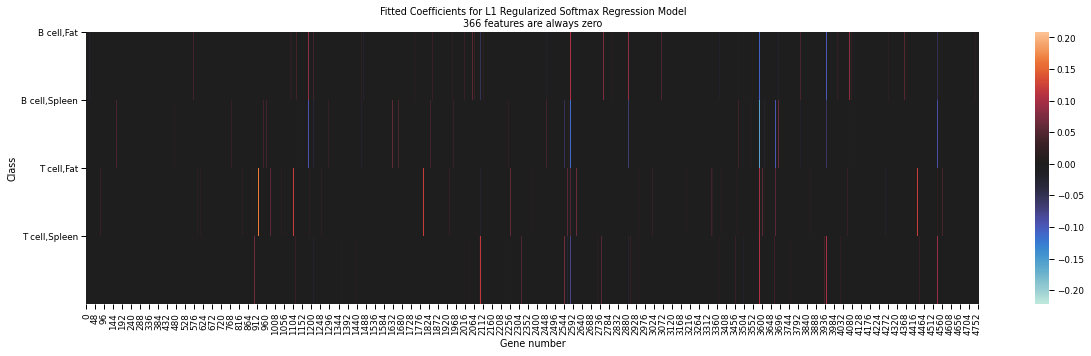

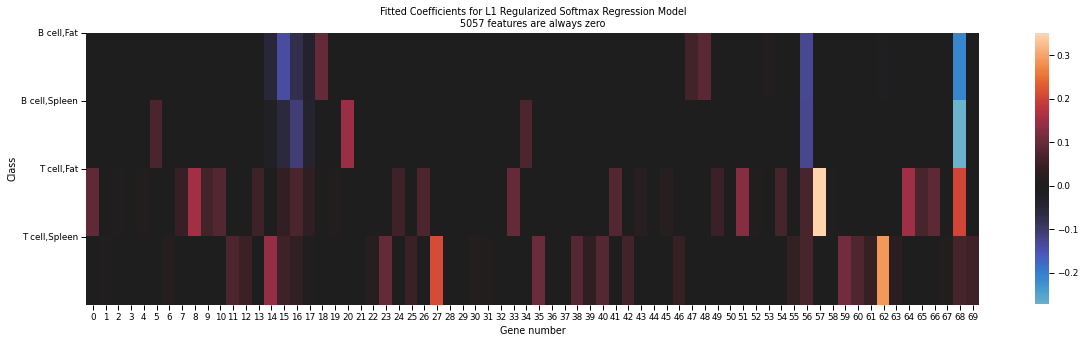

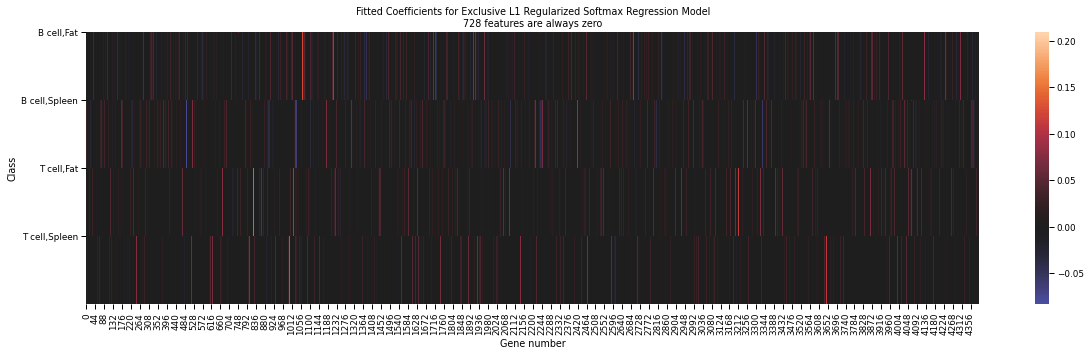

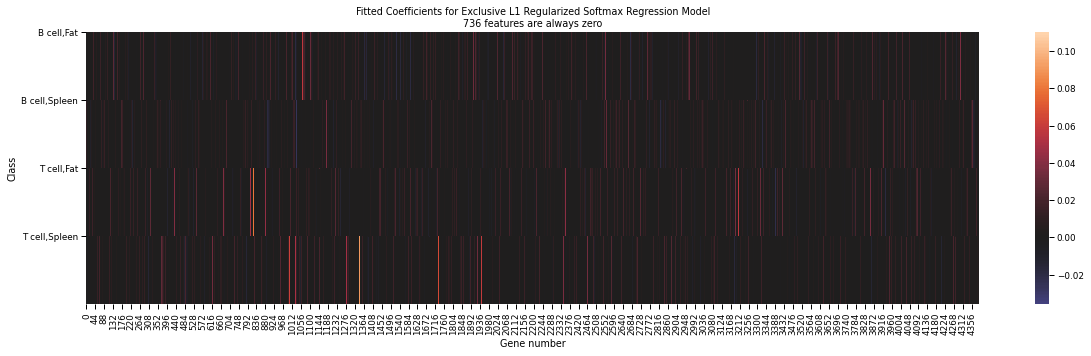

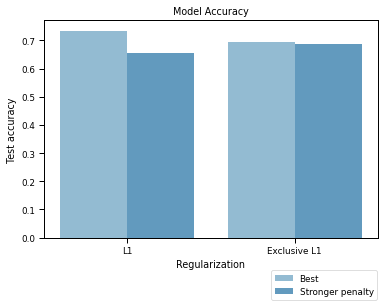

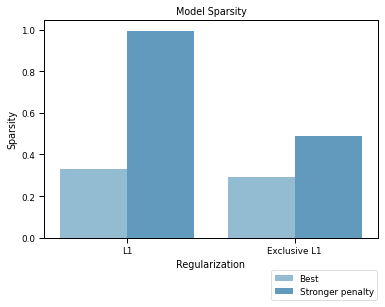

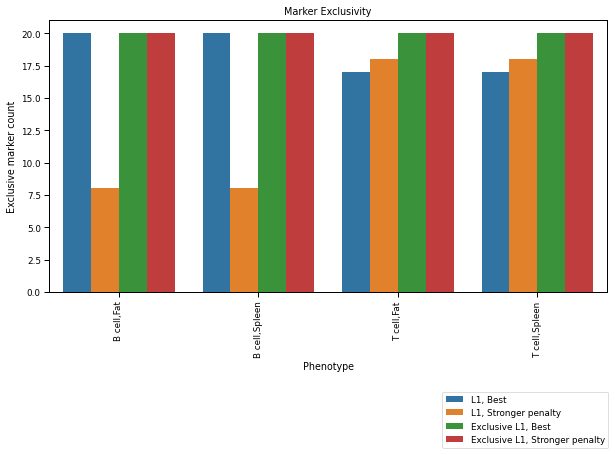

In [76]:
cell_types_list = ['B cell', 'T cell', 'natural killer cell']
run_analysis_pipeline(adata, all_genes_info, "analysis_pipeline_tabula_muris", random_state, cell_types_list=cell_types_list, extra_penalty_factor=5.)

Trying to set attribute `.obs` of view, copying.


['B cell', 'B cell', 'T cell', 'T cell']
ct_bounds: [1, 3]
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   57.1s finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9550             0.9630          0.6759        2.2015           0.0000           1.2171       0.6111        1.6903  0.0523
      2    0.9894             0.9927          0.7170        1.3083           0.0000           0.6333       0.6746        1.4501  0.0420
      3    0.9894             0.9927          0.7669        1.0774           0.0000           0.4939       0.7275        1.2969  0.0427
      4    0.9868             0.9908          0.7776        0.9622           0.0000           0.4710       0.7646        1.1936  0.0510
      5    0.9921             0.9945          0.7756        0.8956           0.0000           0.4626       0.7698        1.1310  0.0442
      6    0.9947             0.9963          0.

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


done.


... storing 'celltype' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'mouse.id' as categorical
... storing 'mouse.sex' as categorical
... storing 'plate.barcode' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
genes: ['Pigr', 'Hes5', 'BC035044', 'Dtx1', 'Apoa2', 'Ell3', '1700030K09Rik', 'Emid1', 'Fam129c', 'Haao', 'Clec2g', 'Rapgef3', 'Krt8', 'Tacstd2', 'Dennd3', 'Bfsp2', 'A230108P19Rik', 'Edaradd', 'Chst3', 'Fcrl5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat
genes: ['D18Ertd653e', '2610019F03Rik', 'Tnfsf11', 'Lime1', 'Ramp3', 'Tigit', 'Ccr8', 'Bend4', 'Aqp3', 'Pkp4', 'Ifng', 'Cd226', 'Tnfrsf10b', 'Fasl', 'Cd96', 'Chrne']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Gm14446', 'Sit1', 'Ccr9', 'Cxcr3', 'Dapl1', 'Cd4', 'Gpr68', 'Slc12a7', 'Rgs3', 'Sla2', 'F2rl1', 'Cst7', 'Slfn1', 'Podnl1', 'Tgtp1', 'Folr4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.16680524
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.185776
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.20347387
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                               set      pval      qval  \
336   GOBP_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION  0.000003  0.019596   
405       GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS  0.000008  0.028166   
2189                      GOBP_BIOLOGICAL_ADHESION  0.000014  0.033833   

      intersection  reference  enquiry  background  
336              2          4       16       23433  
405              7       1216       16       23433  
2189             7       1330       16       23433  
0.1703

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


B cell,Fat
no exlusive genes for this module
B cell,Spleen
no exlusive genes for this module
T cell,Fat
genes: ['D18Ertd653e', '2610019F03Rik', 'Tnfsf11', 'Lime1', 'Ramp3', 'Camk4', 'Tigit', 'Ccr8', 'Bend4', 'Ctla4', 'Ifng', 'Nsun5', 'Fasl', 'Cd96']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Ccr9', 'Dapl1', 'Cd4', 'Gpr68', 'Sla2', 'Gm4956', 'Ubash3a', 'Neu2', 'Cst7', 'Cd5', 'Slfn1', 'Tgtp1', 'Folr4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


nan
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


NONE SIGNIFICANT
nan
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.28347123
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                                    set          pval  \
4527               GOBP_REGULATION_OF_T_CELL_ACTIVATION  4.784933e-07   
4671           GOBP_REGULATION_OF_LYMPHOCYTE_ACTIVATION  1.938877e-06   
405            GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS  2.477426e-06   
3383                             GOBP_T_CELL_ACTIVATION  2.915129e-06   
3949      GOBP_REGULATION_OF_OSTEOCLAST_DIFFERENTIATION  4.873485e-06   
4529                 GOBP_REGULATION_OF_CELL_ACTIVATION  6.643510e-06   
6647       GOBP_REGULATION_OF_LEUKOCYTE_DIFFERENTIATION  1.297650e-05   
4898                         GOBP_METAL_ION_HOMEOSTASIS  1.420437e-05   
2274          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.2min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.8915             0.9249          0.5611        1.4289           0.0000           1.2450       0.5159        1.2346  0.0562
      2    0.9206             0.9451          0.6306        0.7551           0.0000           0.5626       0.5847        1.1194  0.0592
      3    0.9365             0.9560          0.6536        0.5546           0.0000           0.3369       0.6138        1.0717  0.0544
      4    0.9339             0.9513          0.6773        0.4758           0.0000           0.2424       0.6508        1.0487  0.0561
      5    0.9286             0.9476          0.6888        0.4353           0.0000           0.1941       0.6640        1.0329  0.0604
      6    0.9365             0.9531          0.

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
genes: ['Pigr', 'Hes5', 'BC035044', 'Acsf2', 'Srpk3', 'Ell3', 'Emid1', 'Cnr2', 'Haao', 'Fam129c', 'Clec2g', 'Rapgef3', 'Ulk3', 'Krt8', 'Tacstd2', 'Dennd3', 'Bfsp2', 'A230108P19Rik', 'Edaradd', 'Chst3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat
genes: ['Tnfsf11', 'Pkp4', 'C630004H02Rik', 'Lhfpl3', 'Lime1', 'Ramp3', 'Ctla4', 'Tnfrsf10b', 'D18Ertd653e', '2610019F03Rik', 'Igfals', 'Tigit', 'Ccr8', 'Fasl', 'Bend4', 'A430107P09Rik', 'AI854703', 'Ifng', 'Cd226', 'Chrne']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Sit1', 'Dapl1', 'Cd4', 'Slc12a7', 'Gpr68', 'Cxcr3', 'Sla2', 'Gpr83', 'Snai3', 'Folr4', 'Ccr9', 'Slfn1', 'Cst7', 'Gm14446', 'Podnl1', 'F2rl1', 'Enthd1', 'Gm4956', 'Dntt', 'Egfl8']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.15144707
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.16302833
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.20706414
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.15020767
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9339             0.9513        

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
genes: ['Pigr', 'BC035044', 'Pqlc2', 'Dtx1', 'Srpk3', 'Ell3', '1700030K09Rik', 'Emid1', 'Cnr2', 'Fam129c', 'Haao', 'Fam55b', 'Dennd3', 'Kmo', 'Bfsp2', 'Edaradd', 'A230108P19Rik', 'Chst3', 'Fcrl5', 'Pik3r4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat
genes: ['Tnfsf11', 'Camk4', 'Txk', 'Pkp4', 'C630004H02Rik', 'Lime1', 'Ramp3', 'Ctla4', 'Tnfrsf10b', 'D18Ertd653e', 'Bambi-ps1', '2610019F03Rik', 'Tigit', 'Ccr8', 'Rundc3b', 'Fasl', 'Bend4', 'Il18r1', 'Ifng', 'Cd226']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Sit1', 'Dapl1', 'Cd4', 'Slc12a7', 'Gpr68', 'Cxcr3', 'Sla2', 'Folr4', 'Ccr9', 'Cd160', 'Slfn1', 'Cst7', 'Gm14446', 'Podnl1', 'Gm4956', 'Enthd1', 'Ubash3a', 'F2rl1', 'Cd5', 'Tgtp1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.03174091
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.035497963
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.05729926
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                                    set          pval  \
299                       GOBP_ADAPTIVE_IMMUNE_RESPONSE  6.862117e-09   
4529                 GOBP_REGULATION_OF_CELL_ACTIVATION  1.011623e-07   
405            GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS  2.646322e-07   
3383                             GOBP_T_CELL_ACTIVATION  9.088448e-07   
407   GOBP_POSITIVE_REGULATION_OF_IMMUNE_SYSTEM_PROCESS  2.523779e-06   
4527               GOBP_REGULATION_OF_T_CELL_ACTIVATION  3.489224e-06   
1

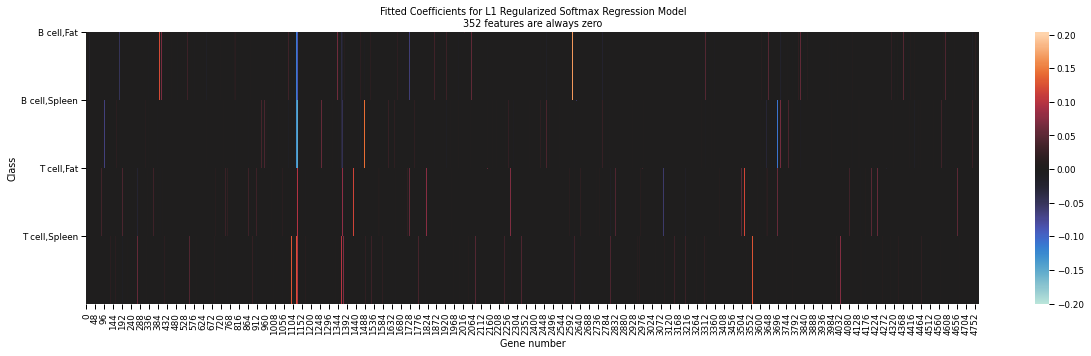

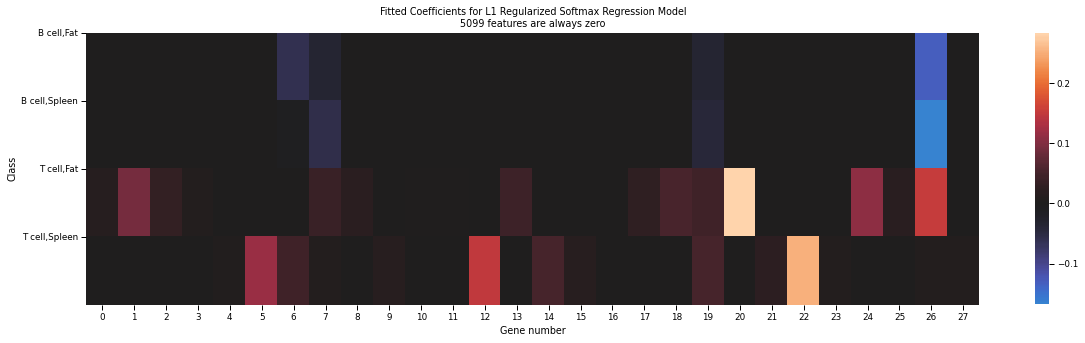

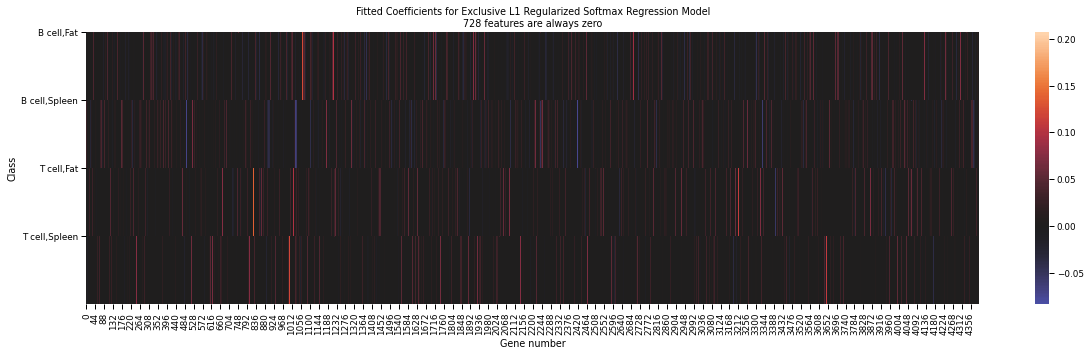

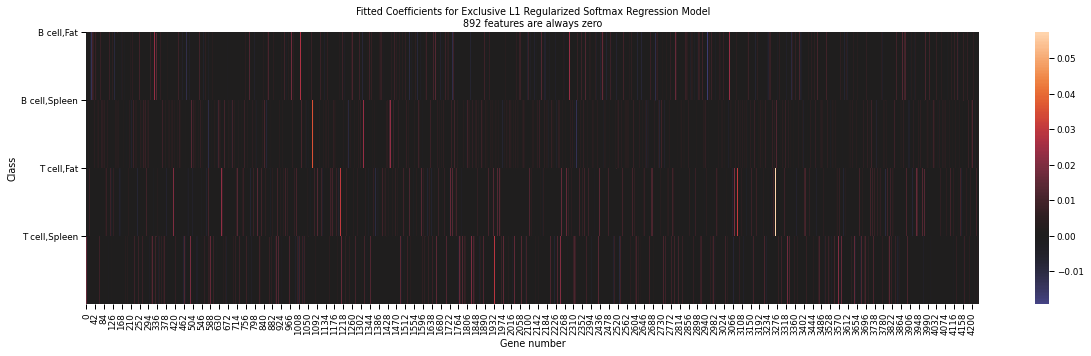

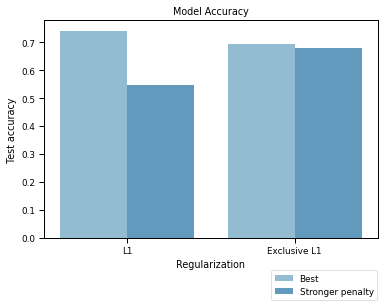

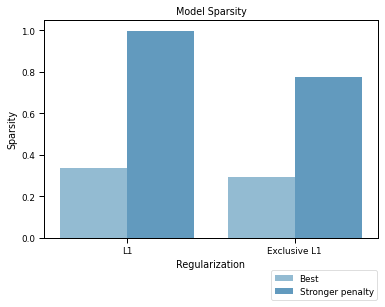

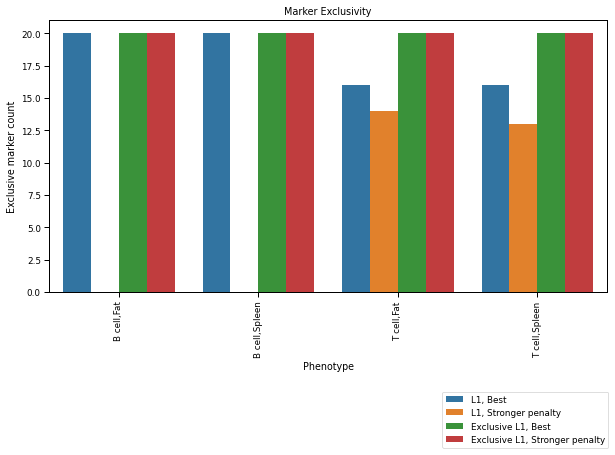

DONE.


In [29]:
cell_types_list = ['B cell', 'T cell', 'natural killer cell']
run_analysis_pipeline(adata, all_genes_info, "analysis_pipeline_tabula_muris_10x", random_state, cell_types_list=cell_types_list, extra_penalty_factor=10.)

Trying to set attribute `.obs` of view, copying.


['B cell', 'B cell', 'B cell', 'B cell', 'T cell', 'T cell', 'T cell', 'natural killer cell']
ct_bounds: [3, 6, 7]
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.2min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9690             0.9465          0.4604        3.6349           0.0000           1.8972       0.3619        2.6585  0.1125
      2    0.9810             0.9820          0.5171        2.0305           0.0000           0.9988       0.4952        2.3272  0.0830
      3    0.9881             0.9907          0.5705        1.6561           0.0000           0.8181       0.5976        2.1159  0.0847
      4    0.9833             0.9849          0.5471        1.4628           0.0000           0.7565       0.6333        2.0135  0.0774
      5    0.9857             0.9896          0.5341        1.3627           0.0000           0.7169       0.6714        1.9558  0.0637
      6    0.9857             0.9896          0.

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


done.


... storing 'celltype' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'mouse.id' as categorical
... storing 'mouse.sex' as categorical
... storing 'plate.barcode' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Limb_Muscle
genes: ['Mir425', 'Perp', 'Krt5', 'Gm16119', 'Neil1', 'Slc35f1', 'Lclat1', 'Lins', 'Crisp1', 'Trem2', 'Ptprr', 'Zfp296', 'Mzf1', 'Hspa1l', 'C030019I05Rik', 'Serpina3m', 'Itgb4', 'Aldh3a1', 'Col28a1', 'Gm14872']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Lung
genes: ['Pls1', 'Mef2b', 'Wbscr25', 'Unc5d', 'Bhlha15', 'Prkcc', 'Cuzd1', 'Gm10578', 'Avpr2', '1300015D01Rik', 'Fam129c', 'Hmgcll1', 'Ocln', 'Abcc2', 'Psg17', 'Cdkn2a', 'Ccdc113', 'Fbxl16', 'Otof', 'Mia2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
genes: ['Dennd3', 'Pigr', 'A230108P19Rik', 'Chst3', 'Mup20', 'BC035044', 'Colq', 'Zfp94', 'Plp1', 'Lta', 'Fcrl5', 'Pik3r4', 'Rapgef3', 'Car1', 'Cnr2', 'Ell3', 'Kmo', 'Krt8', 'Hes5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat
genes: ['Cd96', 'Bend4', 'Amica1', 'Itgae', 'Itpk1', '2610019F03Rik', 'Cd226', 'Faah', 'Tnfsf11', 'Tnfrsf10b', 'Pdcd1', 'Ramp3', 'Als2cl', 'Lime1', 'Ccr8']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Lung
genes: ['Thsd7b', 'Rab4a', 'A230057D06Rik', '1700001C19Rik', 'Cst7', 'Vmn2r59', 'Lrfn1', 'Hspb9', 'Gm6213', 'Gm12505', 'Ccdc146', '1700027F09Rik', 'Ctla4', 'T2', 'Trhde', 'Chrm5', 'Klhdc7a', 'Htra4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Tlr12', 'Cnga1', 'Dapl1', 'Slc12a7', 'Sit1', 'Gm128', 'Il18r1', 'Tgtp1', 'Gm14446', 'Kcnmb4', 'Il4', 'Cd160', 'Camk4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


natural killer cell,Fat
genes: ['Chad', 'Klrb1f', 'Stk32c', 'Klri2', 'Tbx21', 'Fasl', 'Klra9', 'Klre1', 'Cd244', 'Klrb1b', 'Klra14', 'Klra4', '6330512M04Rik', 'Klra13-ps', 'Tnfrsf9', 'Ankrd5', 'Klrb1a', 'Klra8', 'Gm4956']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.25360742
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.23200805
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.157665
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.22575204
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.41615254
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                              set      pval      qval  \
336  GOBP_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION  0.000002  0.017148   

     intersection  reference  en

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


B cell,Fat
no exlusive genes for this module
B cell,Limb_Muscle
genes: ['Myh15', 'Zfp389', 'Sept3', 'Gprc6a', 'Cxcl3', 'D630023F18Rik', 'Olfr456', 'Itih1', 'Perp', 'Cdh16', 'Krt5', 'Krt15', 'Wdr86', 'Htr7', 'Ptprr', 'Hspa1l', 'Aldh3a1', 'Col28a1', 'Acsm4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Lung
genes: ['Wbscr25', 'Unc5d', 'Crhr2', 'Gm10578', '1300015D01Rik', 'Apba2', 'Fam150a', 'Mia2', 'Ggt6', 'Zp2', 'Hmgcll1', 'Tmem213', 'Psg17', 'Cacng1', 'Mapk15', 'Ccdc113', 'Fbxl16', 'Otof', 'Serpina3b', 'Bhlha15']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
no exlusive genes for this module
T cell,Fat
genes: ['Bend4', 'Txk', 'Ramp3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Lung
genes: ['Ifltd1', 'Psg22', 'Cd6', 'Klhdc7a', 'Oas1d', 'A230057D06Rik', '1700001C19Rik', 'Vmn2r59', 'Trhde', 'Kera', 'Chrm5', 'Muc5b', 'Hspb9', 'Gm12505', 'Slc8a3', 'Thsd7b', 'Gm6213', 'C4bp-ps1', 'Tmem150b']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Cd5', 'Cd4', 'Satl1', 'Dapl1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


natural killer cell,Fat
genes: ['Klra4', 'Klrb1f', 'Klra13-ps', 'Neurl1a', 'Klra9', 'Stk32c', 'Klri2', 'Klre1', 'Cd244', 'Klrb1b', 'Klrb1a', 'Neu2', 'Tbx21', 'Klra8', 'Klra14', 'Neurl1b']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


nan
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


NONE SIGNIFICANT
0.09684314
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.05959001
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
nan
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.14845571
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.069533646
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.092771836
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing thos

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.3min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9643             0.9424          0.3935        2.2460           0.0000           1.8987       0.3357        1.9817  0.0681
      2    0.9738             0.9785          0.4441        1.1633           0.0000           0.8097       0.3905        1.8224  0.0612
      3    0.9667             0.9769          0.4892        0.8654           0.0000           0.4688       0.4476        1.8017  0.1633
      4    0.9667             0.9769          0.4876        0.7481           0.0000           0.3343       0.5167        1.7679  0.1014
      5    0.9643             0.9757          0.4757        0.6843           0.0000           0.2717       0.5452        1.7453  0.0934
      6    0.9667             0.9751          0.

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Limb_Muscle
genes: ['Zfp958', 'Mir425', 'Irf2bp1', 'Klc4', 'Gprc6a', 'Acsl1', 'Perp', 'Krt5', 'Neil1', 'Slc35f1', 'Krt15', 'Lins', 'Dsp', 'Trem2', 'Zfp296', 'Hspa1l', 'Tbl2', 'Aldh3a1', 'Zcchc18', 'Ccna2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Lung
genes: ['Mef2b', 'Wbscr25', 'Unc5d', 'BC053749', 'Prkcc', 'Gpr137', 'Spns3', 'Fam129c', 'Avpr2', 'Gh', 'Gm14137', 'Psg17', 'Diras2', 'Ptprn', '9130014G24Rik', 'Fbxl16', '5033406O09Rik', 'Otof', 'Ccdc148', 'Rgs13']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
genes: ['Dennd3', 'Arid3b', 'Pigr', 'A230108P19Rik', 'Cpsf4l', 'Chst3', 'Tmem8', 'Muc4', 'BC035044', 'Colq', 'Zfp94', 'Actc1', 'Lta', 'Mir5104', 'Pik3r4', 'Rapgef3', 'Ell3', 'Cnr2', 'Kmo', 'Hes5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat
genes: ['Tnfsf11', 'Faah', 'Il20ra', 'Galnt9', 'Pik3r5', 'Tnfrsf10b', 'Pkp4', 'Als2cl', 'Cd96', 'C630004H02Rik', 'Tigit', 'Gm590', 'Ramp3', 'Ccr8', 'Amica1', 'Cd226', 'Pdcd1', 'Rgs16', 'Bend4', '2610019F03Rik']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Lung
genes: ['Rab4a', 'Fam71f2', 'Tff3', 'Numb', 'Klhdc7a', 'Gdpd4', '1700001C19Rik', 'Gria2', 'Dcst1', 'Kifc1', 'Tst', 'Chst2', 'Notch4', 'Foxp3', 'Mcm9', 'Klra6', 'Lrfn1', 'Gm19510', 'Gpr111', 'Zg16']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Dapl1', 'Sit1', 'Cxcr3', 'Gm10640', 'Tgtp1', 'Folr4', 'Cnga1', 'Cd5', 'Tmem221', 'Enthd1', 'Gm14446', 'Cd160', 'Slc25a10', 'Cd4', 'F2rl1', 'Tlr12', 'Ccr9', '4930524L23Rik', 'Slfn1', 'D930028M14Rik']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


natural killer cell,Fat
genes: ['Klrb1f', 'Serpinb9b', 'Tm6sf2', 'Stk32c', 'Klri2', 'Ctla2b', 'Tbx21', 'Il18rap', 'Klra9', 'Klre1', 'Cd244', 'Klrb1b', 'S1pr5', 'Klra14', 'Klra4', '6330512M04Rik', 'Klra13-ps', 'Klrb1a', 'Klrc1', 'Gp1bb']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.1404083
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.07754944
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                      set      pval      qval  intersection  reference  \
5424   GOBP_CORNIFICATION  0.000001  0.010309             4         99   
2433  GOBP_KERATINIZATION  0.000007  0.026979             4        150   

      enquiry  background  
5424       20       23433  
2433       20       23433  
0.0799214
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.14042144
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.14693762
INFO:diffxpy: 13475 overlaps 

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Limb_Muscle
genes: ['9630013A20Rik', 'G730013B05Rik', 'Gdpd2', 'Tas2r126', 'Mir425', 'Gprc6a', 'Col11a2', 'Perp', 'Cdh16', 'Krt5', 'Neil1', 'Krt15', 'Crisp1', 'Trem2', 'Mzf1', 'Hspa1l', 'Serpina3m', 'Col28a1', 'Aldh3a1', 'Acsm4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Lung
genes: ['Pls1', 'Mef2b', 'Wbscr25', 'Unc5d', 'Prkcc', 'Cuzd1', 'Gm10578', 'Ranbp17', 'Fam129c', '1300015D01Rik', 'Apba2', 'Mia2', 'Hmgcll1', 'Psg17', 'Abcc2', 'Cdkn2a', 'Ccdc113', 'Fbxl16', 'Otof', 'Bhlha15']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
genes: ['Ffar2', 'Dennd3', 'Arid3b', 'Pigr', 'A230108P19Rik', 'Chst3', '1700030K09Rik', 'BC035044', 'Zfp94', 'Dtx1', 'Lta', 'Fcrl5', 'Edaradd', 'Pik3r4', 'Ell3', 'Cnr2', 'Kmo', 'Fam55b', 'Pqlc2', 'Hes5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat
genes: ['Faah', 'Tnfsf11', 'Lime1', 'Pik3r5', 'Itgae', '1190002N15Rik', 'Tnfrsf10b', 'Pkp4', 'Als2cl', 'Cd96', 'C630004H02Rik', 'Tigit', 'Ramp3', 'Ccr8', 'Txk', 'Cd226', 'Bambi-ps1', 'Pdcd1', 'Bend4', '2610019F03Rik']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Lung
genes: ['Ifltd1', 'Psg22', 'Klhdc7a', 'Htra4', 'A230057D06Rik', 'Gdpd4', '1700001C19Rik', 'Vmn2r59', 'Kera', 'Chrm5', 'Muc5b', 'Hspb9', 'Gm12505', 'Slc8a3', 'Snph', 'Thsd7b', 'Padi6', 'Lrfn1', 'Gm19510', 'Gpr111']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Dapl1', 'Sit1', 'Cxcr3', 'Cd6', 'Prkcq', 'Tgtp1', 'Camk4', 'Folr4', 'Ubash3a', 'Cd5', 'Gm14085', 'Gm14446', 'Cd160', 'Cd4', 'Sla2', 'F2rl1', 'Slc12a7', 'Kcnmb4', 'Slfn1', 'D930028M14Rik']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


natural killer cell,Fat
genes: ['Klrb1f', 'Serpinb9b', 'Stk32c', 'Klri2', 'Ctla2b', 'Tbx21', 'Eomes', 'Fasl', 'Klra9', 'Klre1', 'Cd244', 'Klrb1b', 'S1pr5', 'Klra14', 'Klra4', '6330512M04Rik', 'Klra13-ps', 'Klrb1a', 'Klrc1', 'Klra8']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.037576053
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.05057564
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.04906911
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.028433762
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.054954283
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                               set      pval      qval  \
336   GOBP_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION  0.000004  0.026873   
2189                      

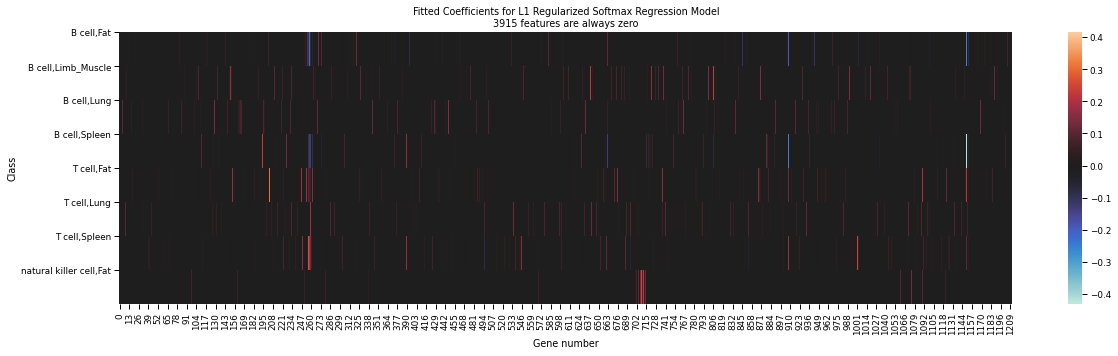

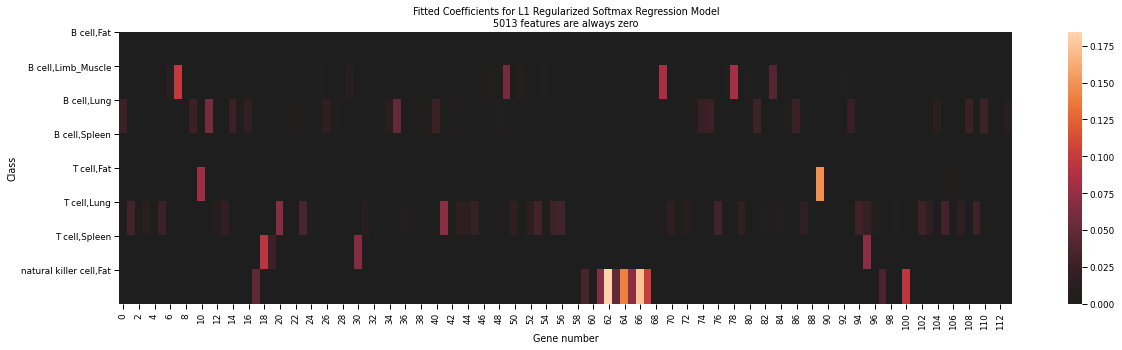

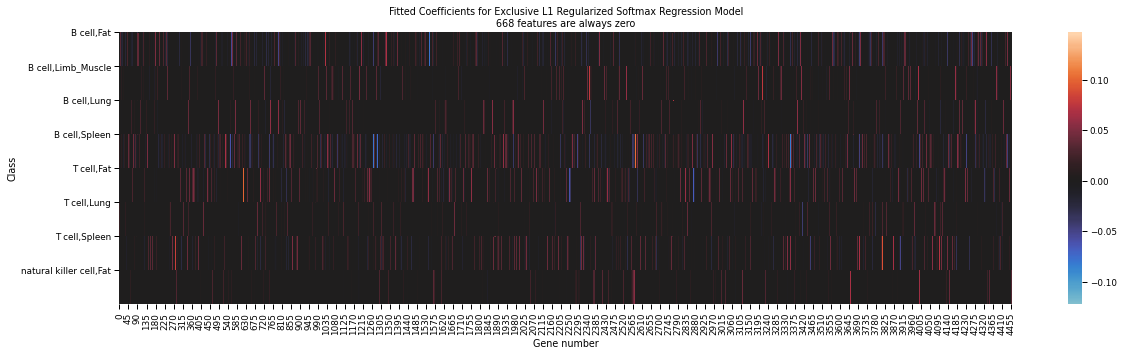

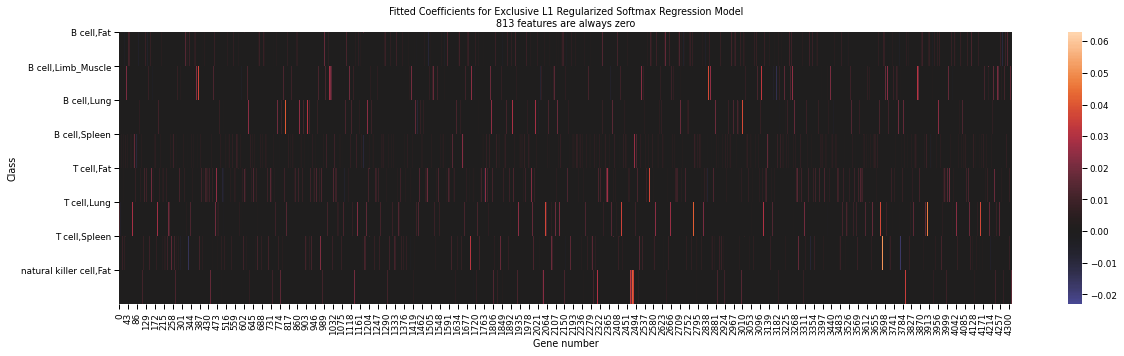

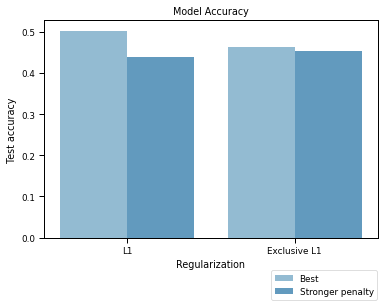

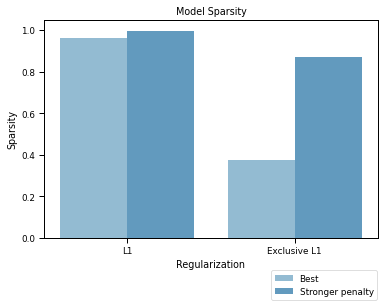

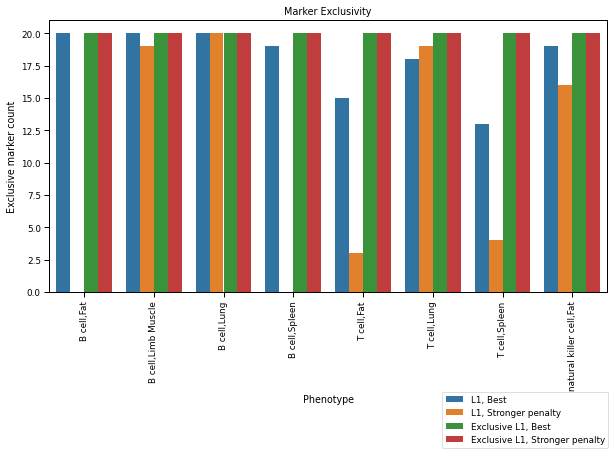

DONE.


In [27]:
cell_types_list = ['B cell', 'T cell', 'natural killer cell']
run_analysis_pipeline(adata, all_genes_info, "analysis_pipeline_tabula_muris_10x_min_count_50", random_state, cell_types_list=cell_types_list, extra_penalty_factor=10., min_label_count=50)

Trying to set attribute `.obs` of view, copying.


['B Cell', 'B Cell', 'B Cell', 'B Cell', 'B Cell', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK Cell', 'NK Cell', 'NK Cell', 'NK Cell', 'NK Cell', 'T Cell', 'T Cell', 'T Cell', 'T Cell', 'T Cell']
ct_bounds: [4, 7, 12, 17]
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 31.7min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9267             0.9519          0.7936        1.3254           0.0000           0.8407       0.8098        1.0832  2.4033
      2    0.9417             0.9579          0.8028        0.8550           0.0000           0.4459       0.8222        0.9897  1.9673
      3    0.9404             0.9563          0.7989        0.7968           0.0000           0.4243       0.8202        0.9718  2.0142
      4    0.9373             0.9553          0.7997        0.7734           0.0000           0.4116       0.8155        0.9597  2.8561
      5    0.9390             0.9541          0.8028        0.7677           0.0000           0.4090       0.8156        0.9721  2.0077
      6    0.9381             0.9558          0.

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


More than 50000 cells, subsampling...
B Cell,PBMC
genes: ['LSM7', 'ZFP36L1', 'ORAI2', 'FAM107B', 'CMSS1', 'IFNGR2', 'FNBP1', 'EVI2B', 'MIR155HG']
computing umap...
done.


... storing 'celltype' as categorical
... storing 'enz' as categorical
... storing 'symbol' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lung
genes: ['ZBTB20', 'JCHAIN', 'SERPINB9', 'HLA-DRB5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lymph_node
genes: ['HLA-DMB', 'LINC00926', 'RBM38']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,spleen
genes: ['HES4', 'HSPA1B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,thymus
no exlusive genes for this module
Fibroblast,kidney
genes: ['IL6ST', 'PCOLCE', 'GUCY1A1', 'LAMB1', 'ITGA1', 'SPP1', 'EMILIN1', 'NID1', 'NRP1', 'COL18A1', 'CYP1B1', 'SYNE2', 'PSD3', 'PRXL2A', 'PALLD', 'APOL1', 'THBS1', 'ADAM12', 'DST', 'VCAN']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,lung
genes: ['NBL1', 'CYBRD1', 'CNN3', 'C3', 'MT1X', 'MT1E', 'CLU', 'DDR2', 'TCEAL9', 'FN1', 'TIMP1', 'F3', 'CTTN', 'CALD1', 'UGDH', 'EMP1', 'UAP1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,thymus
genes: ['HTRA1', 'CD14', 'COL1A1', 'PLPP3', 'SERPINF1', 'PLIN2', 'COL6A1', 'RNASE1', 'CAV1', 'GSN', 'NDRG2', 'CD36', 'IGFBP7', 'GPX3', 'CDKN1C', 'TPM2', 'RRAS']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,PBMC
genes: ['IFIT3', 'RSAD2', 'GNG2', 'HAVCR2', 'LIMD2', 'CHST12', 'LAT2', 'HLA-B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lung
genes: ['PTGDS', 'LYZ', 'NOL4L', 'PIP4K2A', 'PLAC8', 'B3GNT7']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lymph_node
genes: ['AQP3', 'NDUFV1', 'PLIN3', 'TOMM40', 'RPL22L1', 'SERTAD1', 'LZTFL1', 'SNX22', 'TCP1', 'FKBP11', 'TESC', 'TSPAN3', 'PGP']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,spleen
genes: ['PIK3R1', 'CEBPD', 'NCL', 'PLAAT4', 'METRNL', 'CEMIP2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,thymus
genes: ['LGALS3', 'IFI27', 'KLRC1', 'PTPRCAP', 'DUSP2', 'TUBB4B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,PBMC
genes: ['LAT', 'PPP2R5C', 'CREM', 'BIRC2', 'GIMAP5', 'LEPROTL1', 'RORA']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lung
genes: ['IL32', 'CRIP1', 'HMGB2', 'MAF', 'CBLB']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lymph_node
genes: ['SNHG9', 'ITGA6', 'CITED4', 'GIMAP4', 'IRF1', 'SBDS']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,spleen
genes: ['CXXC5', 'PTGER2', 'CFH']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,thymus
genes: ['GADD45G', 'OCIAD2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.24623524
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


NONE SIGNIFICANT
0.24821396
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.07701703
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.24922521
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
nan
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.28319252
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
                                                    set          pval  \
2151                           GOBP_BIOLOGICAL_ADHESION  0.000000e+00   
3816  GOBP_EXTER

... storing 'celltype' as categorical
... storing 'enz' as categorical
... storing 'symbol' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lung
genes: ['INSR', 'JCHAIN', 'LINC01781', 'SERPINB9', 'DERL3', 'ND4L', 'CARMIL1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lymph_node
genes: ['CLHC1', 'BEST1', 'RBM38', 'CCDC74A']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,spleen
genes: ['DNASE1L3', 'HES4', 'SPIB', 'HSPA1B', 'H2AC6', 'BANK1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,thymus
genes: ['NEK6', 'PRDX1', 'TUBA1B', 'ATP2B1-AS1', 'IFI44L', 'CD82']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,kidney
genes: ['GUCY1A1', 'LAMB1', 'ITGA1', 'SPP1', 'EMILIN1', 'SLC8A1', 'NID1', 'NRP1', 'COL18A1', 'CYP1B1', 'PSD3', 'PTGR1', 'PRXL2A', 'INHBA', 'FRMD4A', 'PALLD', 'THBS1', 'ADAM12', 'DST', 'VCAN']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,lung
genes: ['NBL1', 'CYBRD1', 'CNN3', 'C3', 'COL6A2', 'MT1X', 'CLU', 'CST3', 'TCEAL9', 'AKAP12', 'TIMP1', 'F3', 'CALD1', 'FN1', 'EMP1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,thymus
genes: ['HTRA1', 'MGST1', 'PLPP3', 'CD14', 'OAF', 'PLIN2', 'COL6A1', 'RNASE1', 'CAV1', 'NDRG2', 'CD36', 'GPX3', 'TPM2', 'PLTP']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,PBMC
genes: ['IFIT3', 'LASP1', 'RSAD2', 'ZEB2', 'GNG2', 'FEZ1', 'RAMP1', 'HAVCR2', 'LIMD2', 'CHST12', 'IFIT2', 'TGFB1', 'C1orf21']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lung
genes: ['PTGDS', 'PSAP', 'AKR1C3', 'NOL4L', 'PIP4K2A', 'ITGAX', 'B3GNT7']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lymph_node
genes: ['DNAI7', 'NDUFV1', 'NQO2', 'PLIN3', 'TOMM40', 'SERTAD1', 'LZTFL1', 'TCP1', 'H2BC12', 'ACAA2', 'SEPTIN11', 'TESC']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,spleen
genes: ['HBA2', 'PIK3R1', 'IQGAP2', 'TNFSF14', 'NCL', 'HSPH1', 'CEMIP2', 'IRF1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,thymus
genes: ['IFI27', 'PPM1N', 'PLAAT4', 'RGS2', 'DUSP2', 'TUBB4B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,PBMC
genes: ['LAT', 'ZNF90', 'nan', 'PPP2R5C', 'EVI2A', 'LINC00513', 'ATP1A1', 'GIMAP5', 'MIAT', 'PABPC1', 'LEPROTL1', 'RORA']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lung
genes: ['STING1', 'DUSP4', 'ZFP36', 'PRDM1', 'TOB1', 'LGALS1', 'HMGB2', 'MAF', 'CBLB', 'CRYBG1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lymph_node
genes: ['CITED4', 'FOSB', 'GIMAP4', 'GIMAP7', 'MAL', 'RBM47', 'SOCS3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,spleen
genes: ['GBP2', 'S100A9', 'ILF3-DT', 'FAAP20', 'BOLA3', 'RFLNB']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,thymus
genes: ['GADD45G', 'AQP3', 'FAM118A', 'LEF1', 'RETREG1', 'TUBA1A', 'STMN1', 'OCIAD2', 'NUCB2', 'LCK']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.19843005
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.23726925
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
                                                set      pval      qval  \
4937  GOBP_POSITIVE_REGULATION_OF_RESPIRATORY_BURST  0.000003  0.022832   

      intersection  reference  enquiry  background  
4937             2          5        7       11646  
0.085438475
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.20228732
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.09276618
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided ge

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 36.9min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9149             0.9468          0.7892        0.9976           0.0000           0.8292       0.7957        0.8224  2.4073
      2    0.9391             0.9531          0.7856        0.5607           0.0000           0.3673       0.8191        0.8205  2.1278
      3    0.9403             0.9551          0.7851        0.5175           0.0000           0.3277       0.8170        0.8262  2.1823
      4    0.9395             0.9526          0.7855        0.5018           0.0000           0.3134       0.8174        0.8279  2.2451
      5    0.9415             0.9543          0.7785        0.4910           0.0000           0.3043       0.8174        0.8546  2.2003
      6    0.9399             0.9536          0.

... storing 'celltype' as categorical
... storing 'enz' as categorical
... storing 'symbol' as categorical


done.


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lung
genes: ['MARCHF6', 'JCHAIN', 'XIST', 'LINC01781', 'SERPINB9', 'ND4L', 'IRF8']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lymph_node
genes: ['POU2F2', 'LINC00926', 'OTUD1', 'UBALD2', 'FCMR', 'PDLIM1', 'SNHG7', 'DERL3', 'RBM38']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,spleen
genes: ['H2AC6', 'BANK1', 'HES4', 'HSPD1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,thymus
genes: ['ATP2B1-AS1', 'IFI44L', 'CD82']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,kidney
genes: ['IL6ST', 'IFNAR1', 'FNDC3B', 'ITGA1', 'SPP1', 'DNMT1', 'CDK2AP1', 'NID1', 'YAF2', 'STAT2', 'COL18A1', 'SPTBN1', 'SYNE2', 'KLF9', 'THBS1', 'LMO4', 'ADAM12', 'DST', 'VCAN']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,lung
genes: ['CYBRD1', 'MIR4458HG', 'SLC25A37', 'MYC', 'C3', 'UAP1', 'PLAT', 'MT1X', 'LOXL1', 'CLU', 'CES1', 'CD9', 'TAX1BP3', 'APP', 'MT1E', 'TXN']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,thymus
genes: ['MGST1', 'LGALS3', 'PLPP3', 'OAF', 'PLIN2', 'RAB34', 'CFD', 'COL6A2', 'CAV1', 'FBLN5', 'GSN', 'SPARC', 'RHOBTB3', 'S100A11', 'CTSB', 'RRAS', 'HEBP2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,PBMC
genes: ['PRMT2', 'LASP1', 'RSAD2', 'GNG2', 'WIPF1', 'RAMP1', 'HAVCR2', 'LAT2', 'LIMD2', 'CHST12', 'IFIT2', 'TGFB1', 'CD7', 'SLFN5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lung
genes: ['KLRK1', 'PSAP', 'NOL4L', 'PIP4K2A', 'CDC42SE1', 'SPON2', 'CCND3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lymph_node
genes: ['DGCR6L', 'ZEB2', 'GLIS3', 'TOMM40', 'STK17A', 'LZTFL1', 'ACAA2', 'FDX1', 'KLRF1', 'FKBP11', 'SESN2', 'TSPAN3', 'B3GNT7']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,spleen
genes: ['PIK3R1', 'CTSC', 'NCL', 'HSPH1', 'PLAAT4', 'METRNL', 'JPT1', 'CEMIP2', 'VAMP5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,thymus
genes: ['MXD3', 'ANXA2', 'UBB', 'BCAS2', 'ISG15', 'RGCC', 'NR4A1', 'CTSA', 'TUBA4A', 'HLA-B', 'DUSP2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,PBMC
genes: ['LAT', 'SPOCK2', 'PPP2R5C', 'DNAJB6', 'CDC42SE2', 'GIMAP5', 'MIAT', 'TC2N', 'CD2', 'FAM102A', 'LEPROTL1', 'RORA']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lung
genes: ['CNOT6L', 'PRDM1', 'HMGB2', 'CBLB', 'CRYBG1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lymph_node
genes: ['MZT2A', 'ITGA6', 'MRPS31', 'BOLA2B', 'YME1L1', 'SBDS', 'SOCS3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,spleen
genes: ['S100A9', 'CFH', 'CXXC5', 'MAL', 'MAF']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,thymus
genes: ['GADD45G', 'AQP3', 'ETHE1', 'OCIAD2', 'ACAP1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.10418011
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.15267062
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.074650675
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.1468237
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.104477845
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.057232823
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
 

... storing 'celltype' as categorical
... storing 'enz' as categorical
... storing 'symbol' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lung
genes: ['JCHAIN', 'IFI30', 'HLA-DRB5', 'ZBTB20', 'LINC01781', 'SERPINB9', 'MARCHF1', 'CARMIL1', 'ND4L', 'IRF8']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lymph_node
genes: ['POU2F2', 'TCF4', 'LINC00926', 'OTUD1', 'SWAP70', 'UBALD2', 'FCMR', 'MEF2C', 'SNHG7', 'RBM38']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,spleen
genes: ['TAMALIN', 'CD55', 'HES4', 'SPIB', 'HSPA1B', 'H2AC6', 'HSPD1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,thymus
genes: ['NEK6', 'PRDX1', 'TUBA1B', 'HIVEP3', 'ATP2B1-AS1', 'IFI44L', 'CD82']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,kidney
genes: ['CCDC102B', 'GUCY1A1', 'LAMB1', 'ITGA1', 'SPP1', 'EMILIN1', 'ACO1', 'NID1', 'NRP1', 'COL18A1', 'CYP1B1', 'PSD3', 'PRXL2A', 'FRMD4A', 'PALLD', 'APOL1', 'THBS1', 'ADAM12', 'DST', 'VCAN']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,lung
genes: ['NBL1', 'CYBRD1', 'C3', 'SERPING1', 'CST3', 'DDR2', 'AKAP12', 'EMP1', 'TCEAL9', 'F3', 'CTTN', 'CALD1', 'UGDH', 'TIMP2', 'MT1E', 'CNN3', 'MT1X', 'CLU', 'TIMP1', 'UAP1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,thymus
genes: ['IGFBP4', 'PLPP3', 'COL1A1', 'NDRG2', 'CD36', 'TPM2', 'HTRA1', 'FAM20C', 'CFD', 'CAV1', 'SPARC', 'CD14', 'MGST1', 'SERPINF1', 'OAF', 'RNASE1', 'COL6A1', 'HBA1', 'GSN', 'GPX3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,PBMC
genes: ['IFIT3', 'PRMT2', 'RSAD2', 'LASP1', 'GNG2', 'GCHFR', 'WIPF1', 'FEZ1', 'UBE2F', 'RAMP1', 'TNIP1', 'HAVCR2', 'LIMD2', 'CHST12', 'TGFB1', 'C1orf21', 'SLFN5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lung
genes: ['PTGDS', 'PSAP', 'AKR1C3', 'NOL4L', 'MT2A', 'IGFBP7', 'PIP4K2A', 'SERF2', 'CDC42SE1', 'PLAC8', 'SPON2', 'HOPX', 'B3GNT7']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lymph_node
genes: ['DNAI7', 'NDUFV1', 'NQO2', 'PLIN3', 'TOMM40', 'FLNB', 'ADAR', 'LZTFL1', 'TCP1', 'H2BC12', 'RRP7A', 'ACAA2', 'ERLEC1', 'ANXA7', 'ITGAX', 'TESC', 'TSPAN3', 'PGP']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,spleen
genes: ['APMAP', 'PIK3R1', 'TNFSF14', 'KLRG1', 'NCL', 'FYN', 'METRNL', 'CEMIP2', 'NEAT1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,thymus
genes: ['LGALS3', 'TBCB', 'DUSP2', 'IFI27', 'SPATS2L', 'BCAS2', 'TENT5C', 'PTPRCAP', 'RGS2', 'RGCC', 'NR4A1', 'IFIT2', 'VIM', 'TUBB4B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,PBMC
genes: ['CAMK4', 'CYTOR', 'TSHZ2', 'LAT', 'ZNF90', 'PABPC1', 'PPP2R5C', 'BIRC2', 'ATP1A1', 'RPL9', 'EVI2A', 'CDC42SE2', 'GIMAP5', 'MIAT', 'ADTRP', 'S100A11', 'FAM102A', 'LEPROTL1', 'RORA']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lung
genes: ['CNOT6L', 'STING1', 'DUSP4', 'PIM2', 'IL32', 'CRYBG1', 'PRDM1', 'CD2', 'TOB1', 'LGALS1', 'HMGB2', 'MAF', 'CBLB', 'ANXA1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lymph_node
genes: ['MZT2A', 'ITGA6', 'CITED4', 'LDHB', 'PASK', 'GIMAP4', 'GIMAP7', 'SVIL', 'BOLA2B', 'MCUB', 'SBDS', 'SOCS3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,spleen
genes: ['CDK6', 'PCSK1N', 'COL6A2', 'S100A9', 'ILF3-DT', 'WDR54', 'IFITM2', 'CFH', 'IFITM1', 'SPRY2', 'PRKCQ-AS1', 'NPDC1', 'RFLNB']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,thymus
genes: ['GADD45G', 'AQP3', 'RETREG1', 'TUBA1A', 'ETHE1', 'OCIAD2', 'NUCB2', 'CD3G', 'TNFRSF25', 'SMC4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.19991456
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.19539781
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.10309473
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.21150842
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.16152708
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.16560584
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
   

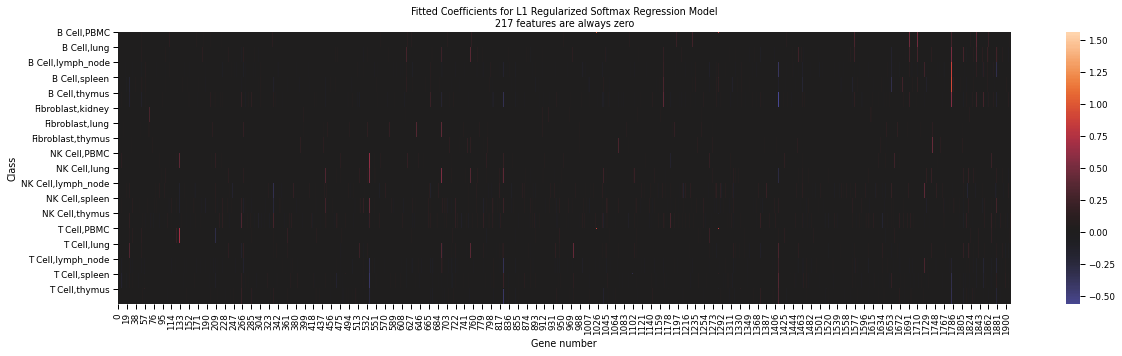

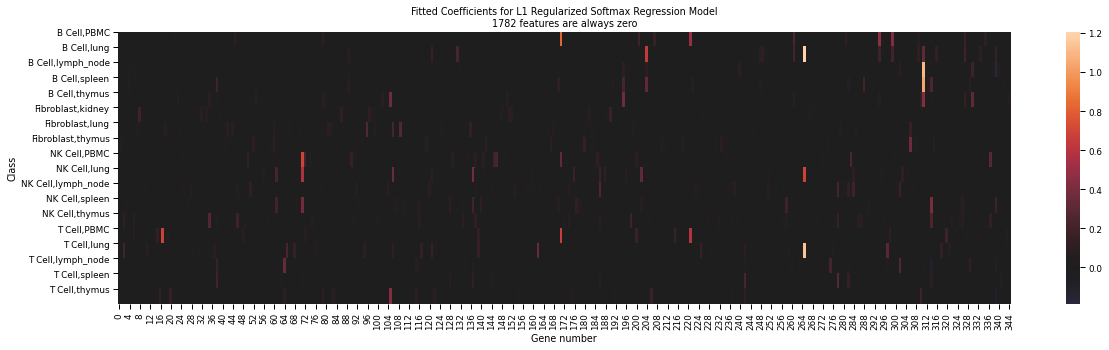

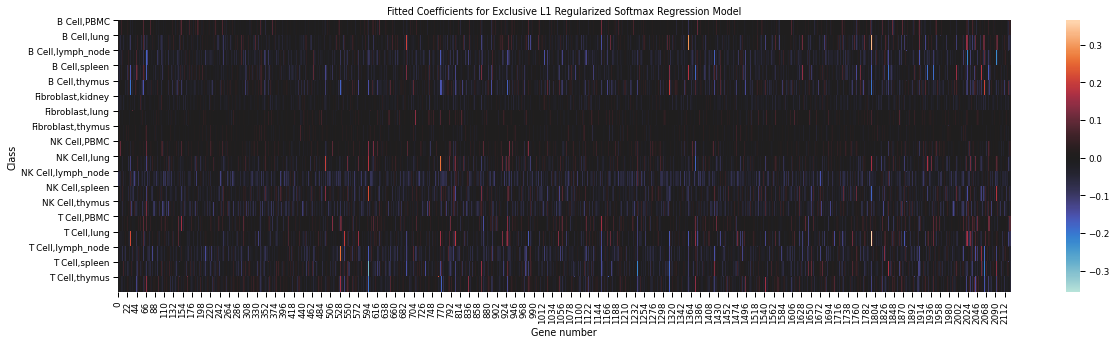

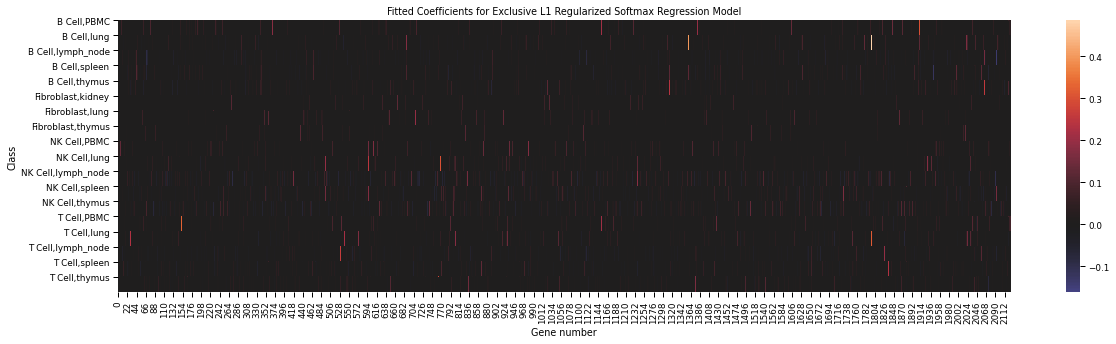

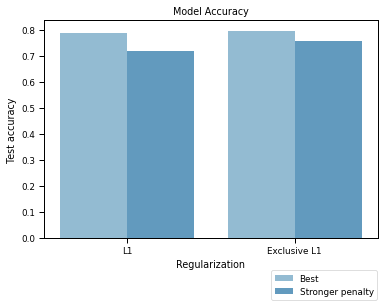

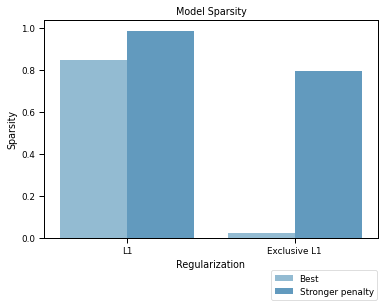

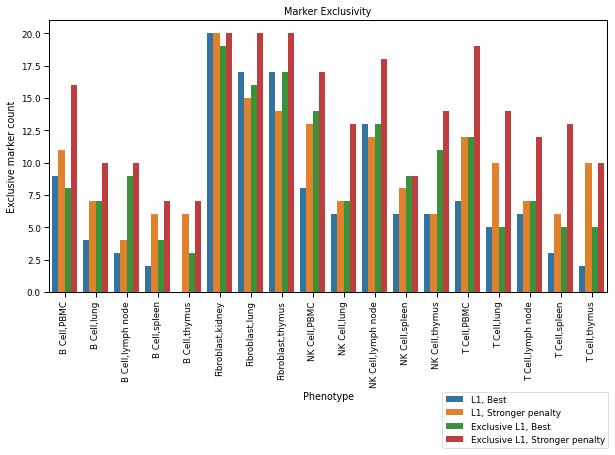

In [30]:
cell_types_list = ['T Cell', 'Fibroblast', 'B Cell', 'NK Cell']
run_analysis_pipeline(adata, all_genes_info, "analysis_pipeline_hubmap_10x", random_state, cell_types_list=cell_types_list, extra_penalty_factor=10.)

Trying to set attribute `.obs` of view, copying.


['B Cell', 'B Cell', 'B Cell', 'B Cell', 'B Cell', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK Cell', 'NK Cell', 'NK Cell', 'NK Cell', 'NK Cell', 'T Cell', 'T Cell', 'T Cell', 'T Cell', 'T Cell']
ct_bounds: [4, 7, 12, 17]
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done  72 out of  72 | elapsed: 23.3min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9170             0.9415          0.8185        1.3904           0.0000           0.9112       0.7859        1.0662  2.4077
      2    0.9291             0.9472          0.8323        0.8463           0.0000           0.4353       0.8046        0.9529  1.4133
      3    0.9337             0.9489          0.8337        0.7740           0.0000           0.4030       0.8062        0.9159  1.3916
      4    0.9305             0.9478          0.8334        0.7462           0.0000           0.3871       0.8032        0.9032  1.3864
      5    0.9346             0.9478          0.8282        0.7338           0.0000           0.3793       0.8066        0.8958  1.3677
      6    0.9330             0.9487          0.

... storing 'celltype' as categorical
... storing 'enz' as categorical
... storing 'symbol' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lung
genes: ['HERPUD1', 'SAT1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lymph_node
genes: ['LINC00926', 'RGS2', 'nan']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,spleen
genes: ['RPL22L1', 'HES4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,thymus
genes: ['FAM118A', 'TUBA1B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,kidney
genes: ['SPP1', 'APOL1', 'LMO4', 'DST', 'PRXL2A', 'HYAL2', 'VCAN', 'THBS1', 'PSD3', 'NRP1', 'SYNE2', 'CYP1B1', 'PALLD', 'PLPP3', 'LAMB1', 'RRBP1', 'PCOLCE', 'IGFBP7', 'NFIA']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,lung
genes: ['F3', 'TCEAL9', 'TIMP1', 'TNFRSF12A', 'IFITM3', 'FN1', 'QSOX1', 'C3', 'NEXN', 'CTTN', 'CLU', 'S100A13', 'EMP1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,thymus
genes: ['RCN1', 'PLIN2', 'CAV1', 'RNASE1', 'FAM20C', 'CEBPD', 'HTRA1', 'SERPINF1', 'COL6A1', 'TMEM176A', 'TPM2', 'CFD', 'CD14', 'COL1A1', 'CD36']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,PBMC
genes: ['HAVCR2', 'SH2D1B', 'IFIT3', 'CD38', 'LAT2', 'TGFB1', 'RSAD2', 'GNG2', 'SLFN5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lung
genes: ['PIP4K2A', 'NOL4L', 'SPON2', 'ISG20', 'PLAC8']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lymph_node
genes: ['NDUFAB1', 'ACAA2', 'ATAD2', 'ORMDL2', 'TRAF1', 'IDS', 'ERGIC1', 'HOPX', 'EIF4H', 'PIN4', 'DUSP1', 'HSP90B1', 'SPAG9', 'PSMG2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,spleen
genes: ['GIMAP7', 'KLRG1', 'ATF3', 'METRNL', 'PLAAT4', 'PIK3R1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,thymus
genes: ['CITED2', 'ISG15', 'EIF4E', 'IFIT2', 'REX1BD', 'LCK', 'KLRC1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,PBMC
genes: ['GAPDH', 'LAT', 'PPP2R5C', 'CYTOR', 'GIMAP5', 'CAMK4', 'RORA', 'S100A11', 'BIRC2', 'ZNF90', 'EVI2A']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lung
genes: ['CBLB', 'HMGB2', 'CRYBG1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lymph_node
genes: ['IL4I1', 'IL1R1', 'IRF1', 'SOCS3', 'PIM3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,spleen
genes: ['S100A9', 'GSTK1', 'PTGER2', 'PRKCQ-AS1', 'PSME2', 'CXXC5', 'FBL']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,thymus
genes: ['RGS1', 'GADD45G', 'TMSB10', 'OCIAD2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.25333148
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.20855178
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.07199521
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.25399506
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.14957824
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.22189003
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
   

... storing 'celltype' as categorical
... storing 'enz' as categorical
... storing 'symbol' as categorical


done.


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lung
genes: ['ND4L', 'CXCL3', 'PELI1', 'TXNDC5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lymph_node
genes: ['LINC00926', 'HLA-DMB', 'CD83', 'BEST1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,spleen
genes: ['CD72', 'BANK1', 'DNASE1L3', 'HES4', 'SPIB', 'CD22']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,thymus
genes: ['CTSH', 'CD82', 'NEK6', 'HSPB1', 'IFI44L', 'ATP2B1-AS1', 'TUBA1B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,kidney
genes: ['SPP1', 'HYAL2', 'RRBP1', 'SYNE2', 'CYP1B1', 'APOL1', 'LMO4', 'VCAN', 'PALLD', 'NFIA', 'PCOLCE', 'ITGA1', 'PSD3', 'IGFBP7', 'NRP1', 'INHBA', 'LAMB1', 'DST']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,lung
genes: ['F3', 'CREB5', 'TCEAL9', 'CNN3', 'TIMP1', 'IFITM3', 'FN1', 'MT1X', 'C3', 'TNFAIP2', 'CTTN', 'CLU', 'S100A13', 'EMP1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,thymus
genes: ['CAV1', 'RNASE1', 'FAM20C', 'HTRA1', 'MYL9', 'IGFBP4', 'SERPINF1', 'COL6A1', 'CD36', 'TPM2', 'TMEM176A', 'COL1A1', 'SPARC', 'GSN']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,PBMC
genes: ['HAVCR2', 'IFIT3', 'PRR5L', 'TGFB1', 'C1orf21', 'RAMP1', 'GNG2', 'CHST12', 'FEZ1', 'MYO1F']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lung
genes: ['LYZ', 'PTGDS', 'PIP4K2A', 'NOL4L', 'B3GNT7']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lymph_node
genes: ['NDUFAB1', 'TESC', 'ACAA2', 'ATAD2', 'TRAF1', 'HOPX', 'RHOC', 'MCUR1', 'FOSB', 'NQO2', 'TLN1', 'PIN4', 'HSPA5', 'HSP90B1', 'SMOX']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,spleen
genes: ['CEMIP2', 'KLRG1', 'IQGAP2', 'TNFSF14', 'FYN', 'PIK3R1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,thymus
genes: ['TUBB4B', 'IER3', 'ISG15', 'DUSP2', 'CITED2', 'NR4A1', 'REX1BD', 'LYAR']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,PBMC
genes: ['LAT', 'PPP2R5C', 'GIMAP5', 'ADTRP', 'RORA', 'LINC00513', 'NIBAN1', 'S100A11', 'CMSS1', 'ZNF90', 'EVI2A']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lung
genes: ['FKBP11', 'CD69', 'LGALS1', 'CRYBG1', 'CBLB', 'DUSP4', 'STING1', 'PRDM1', 'HMGB2', 'RGS1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lymph_node
genes: ['SOCS3', 'TAMALIN', 'FCMR', 'EMC10']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,spleen
genes: ['STOM', 'ILF3-DT', 'GSTK1', 'SCARB2', 'RFLNB', 'PRKCQ-AS1', 'SPRY2', 'CFH', 'CCDC85B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,thymus
genes: ['FAM118A', 'GADD45G', 'ITM2A', 'LEF1', 'AQP3', 'OCIAD2', 'NUCB2', 'STMN1', 'TUBA1A', 'RETREG1', 'PEA15']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.23408565
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.08265403
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.06653447
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.19712128
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.08480416
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.18884183
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
   

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done  72 out of  72 | elapsed: 30.3min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9008             0.9337          0.8002        1.0606           0.0000           0.9008       0.7688        0.8045  2.2083
      2    0.9290             0.9440          0.8076        0.5483           0.0000           0.3596       0.8019        0.7710  1.9392
      3    0.9296             0.9408          0.8157        0.4938           0.0000           0.3068       0.8006        0.7596  1.9623
      4    0.9339             0.9438          0.8092        0.4718           0.0000           0.2867       0.8048        0.7749  2.3629
      5    0.9324             0.9389          0.8068        0.4622           0.0000           0.2787       0.7986        0.7801  2.1333
      6    0.9311             0.9392          0.

... storing 'celltype' as categorical
... storing 'enz' as categorical
... storing 'symbol' as categorical


done.


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lung
genes: ['GNG7', 'SNHG25', 'HERPUD1', 'UBE2J1', 'LINC01781']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lymph_node
genes: ['LINC00926', 'PDLIM1', 'PHACTR1', 'POU2F2', 'HLA-DMB', 'LYN']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,spleen
genes: ['FCMR', 'BANK1', 'DNASE1L3', 'HES4', 'MZB1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,thymus
genes: ['CTSH', 'CD82', 'ATP2B1-AS1', 'STMN1', 'TUBA1B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,kidney
genes: ['ITPR2', 'GLIPR1', 'PRXL2A', 'AKAP9', 'VCAN', 'KLF9', 'ARHGAP18', 'WNK1', 'ACTN1', 'IL6ST', 'SYNE2', 'SYNE1', 'PALLD', 'TPR', 'LAMB1', 'RRBP1', 'UBE2E2', 'HELLS', 'OSBPL1A', 'NFIA']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,lung
genes: ['RPS27L', 'HMGN2', 'DSTN', 'MIR4458HG', 'LTBP4', 'IFITM3', 'FN1', 'ABLIM1', 'QSOX1', 'USP53', 'C3', 'MYC', 'IL6', 'CLU', 'UAP1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,thymus
genes: ['TSPAN3', 'PTGDS', 'PGRMC1', 'RCN1', 'PLIN2', 'SRM', 'LGALS3', 'OSBPL8', 'RGS16', 'BRI3', 'HEBP2', 'FKBP1A', 'CCDC152', 'APOC1', 'REEP3', 'CD14', 'EGR1', 'GSN']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,PBMC
genes: ['HAVCR2', 'SH2D1B', 'LAT2', 'WIPF1', 'GCHFR', 'NFKB1', 'TGFB1', 'LASP1', 'RSAD2', 'GNG2', 'APOBEC3G', 'SLFN5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lung
genes: ['KLRF1', 'PIP4K2A', 'GPR65', 'TLE4', 'NOL4L', 'SPON2', 'ISG20']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lymph_node
genes: ['PFN1', 'PA2G4', 'NDUFAB1', 'TESC', 'PSMA5', 'NCL', 'SELENOS', 'HOPX', 'PTTG1IP', 'RHOC', 'GABARAPL2', 'TLN1', 'PDCD4', 'HADHB', 'ARPC5L']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,spleen
genes: ['CEMIP2', 'CACYBP', 'DNMT1', 'METRNL', 'PLAAT4', 'PIK3R1', 'DDX3Y']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,thymus
genes: ['JAML', 'TUBB4B', 'ARIH1', 'CITED2', 'ISG15', 'NR4A1', 'RGS2', 'BCAS2', 'REX1BD', 'PPP1R14B', 'ZC3H12A']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,PBMC
genes: ['GAPDH', 'LAT', 'PPP2R5C', 'CAMK4', 'RORA', 'S100A11', 'GRAP2', 'MIAT', 'FAM177A1', 'ZNF90', 'EVI2A']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lung
genes: ['TXN', 'DDIT4', 'S100A6', 'LGALS1', 'CBLB', 'HMGB2', 'PIM2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lymph_node
genes: ['SBDS', 'IL4I1', 'TMEM70', 'MZT2A', 'BOLA2B', 'SOCS3', 'DDX18']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,spleen
genes: ['S100A9', 'MYADM', 'SAMHD1', 'ILF3-DT', 'GSTK1', 'MRPL11', 'PRKCQ-AS1', 'FBL', 'CCDC85B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,thymus
genes: ['GADD45G', 'ITM2A', 'SERTAD1', 'AQP3', 'TNFRSF25', 'OCIAD2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.122322686
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.08715283
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.08260704
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.17187469
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.13400283
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.047668085
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
N

... storing 'celltype' as categorical
... storing 'enz' as categorical
... storing 'symbol' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lung
genes: ['NPC2', 'GNG7', 'JCHAIN', 'BCL2A1', 'CRIP1', 'PELI1', 'EIF1AY', 'BCL11A', 'HERPUD1', 'ND4L', 'RPL37A', 'LINC01781']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lymph_node
genes: ['LINC00926', 'PHACTR1', 'BEST1', 'POU2F2', 'LYN', 'CD83', 'UBALD2', 'PDE4B', 'OTUD1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,spleen
genes: ['COBLL1', 'TAMALIN', 'CD72', 'HSP90AA1', 'HSPA1B', 'CD55', 'HES4', 'MZB1', 'SPIB', 'CD74']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,thymus
genes: ['CTSH', 'CD82', 'CNPY3', 'HSPB1', 'IFI44L', 'ATP2B1-AS1', 'TUBA1B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,kidney
genes: ['SPP1', 'ITGA1', 'DST', 'PRXL2A', 'HYAL2', 'VCAN', 'THBS1', 'PSD3', 'NRP1', 'SERINC2', 'CYP1B1', 'PALLD', 'CALD1', 'MLF1', 'LOC101927480', 'LAMB1', 'NEDD4L', 'IGFBP7', 'NFIA', 'INHBA']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,lung
genes: ['FN1', 'SLC19A2', 'GPX3', 'FSTL3', 'TCEAL9', 'MT1E', 'MT1X', 'CTTN', 'CLU', 'EMP1', 'F3', 'TNFRSF12A', 'DPYSL2', 'CREB5', 'UAP1', 'TIMP1', 'IFITM3', 'C3', 'PMP22']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,thymus
genes: ['RCN1', 'RNASE1', 'IGFBP4', 'MYL9', 'COL6A1', 'CD14', 'A4GALT', 'SERPINF1', 'PLTP', 'CD36', 'CST3', 'CAV1', 'FAM20C', 'HTRA1', 'TMEM176A', 'CFD', 'RAB34', 'COL1A1', 'GSN']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,PBMC
genes: ['HAVCR2', 'SH2D1B', 'PRR5L', 'IFIT3', 'PRMT2', 'GCHFR', 'WIPF1', 'B2M', 'CHST12', 'TGFB1', 'C1orf21', 'LASP1', 'RSAD2', 'RAMP1', 'GNG2', 'APOBEC3G', 'SLFN5', 'FEZ1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lung
genes: ['LYZ', 'PTGDS', 'KLRF1', 'PIP4K2A', 'CDC42SE1', 'GPR65', 'SYTL3', 'THEMIS2', 'NOL4L', 'KMT2E-AS1', 'ACTB', 'PLAC8', 'B3GNT7']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lymph_node
genes: ['PLIN3', 'FOSB', 'PIN4', 'SPAG9', 'PSMG2', 'NDUFAB1', 'TESC', 'ORMDL2', 'TRAF1', 'IDS', 'HSP90B1', 'GGCX', 'ACAA2', 'ATAD2', 'NDUFV1', 'DUSP1', 'HSPA5', 'ITGAX', 'HOPX']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,spleen
genes: ['CEMIP2', 'HBA2', 'KLRG1', 'IQGAP2', 'NEAT1', 'CACYBP', 'METRNL', 'PLAAT4', 'PIK3R1', 'TNFSF14']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,thymus
genes: ['IER3', 'ISG15', 'DUSP2', 'CITED2', 'EIF4E', 'NR4A1', 'RGS2', 'TENT5C', 'VIM', 'BCAS2', 'IFIT2', 'REX1BD', 'HSPB11', 'HSPA6', 'ZC3H12A']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,PBMC
genes: ['GAPDH', 'LAT', 'PPP2R5C', 'RPL9', 'CDC42SE2', 'GIMAP5', 'CAMK4', 'RORA', 'ADTRP', 'MIAT', 'ITK', 'S100A11', 'ATP1A1', 'TSHZ2', 'BIRC2', 'CMSS1', 'ZNF90', 'EVI2A']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lung
genes: ['TXN', 'S100A6', 'CD69', 'LGALS1', 'CRYBG1', 'CBLB', 'TOB1', 'DUSP4', 'STING1', 'ND2', 'PRDM1', 'HMGB2', 'PIM2', 'CD2', 'CARD19']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,lymph_node
genes: ['ALKBH7', 'SBDS', 'GIMAP4', 'MCUB', 'IL4I1', 'IRF1', 'SVIL', 'STAT3', 'RPS27', 'LDHB', 'MZT2A', 'SOCS3', 'SGK1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,spleen
genes: ['S100A9', 'STOM', 'CDK6', 'SAMHD1', 'GSTK1', 'WDR54', 'COL6A2', 'PRKCQ-AS1', 'CXXC5', 'SPRY2', 'PTGER2', 'CFH', 'CCDC85B', 'PSMC5']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T Cell,thymus
genes: ['CD3G', 'SMC4', 'GADD45G', 'ITM2A', 'SEPTIN6', 'AQP3', 'TNFRSF25', 'OCIAD2', 'NUCB2', 'TUBA1A', 'MARCKSL1', 'RETREG1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.21549734
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.24075134
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.117163144
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.2515533
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.14088726
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
0.17992766
INFO:diffxpy: 9617 overlaps found between refset (17949) and provided gene list (11645).
INFO:diffxpy: Found 102 empty sets, removing those.
   

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


  Regularization               Fit  Test accuracy  Sparsity
0   Exclusive L1              Best       0.809598  0.032663
1   Exclusive L1  Stronger penalty       0.762981  0.796047
2             L1              Best       0.804683  0.858052
3             L1  Stronger penalty       0.734649  0.984277


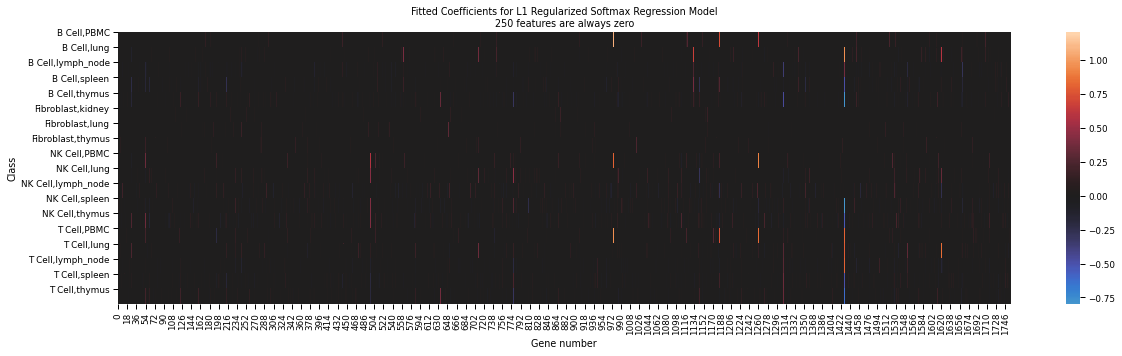

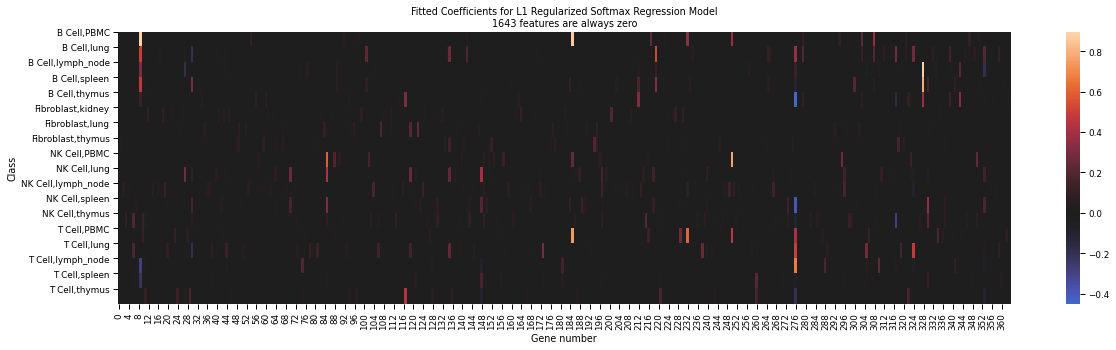

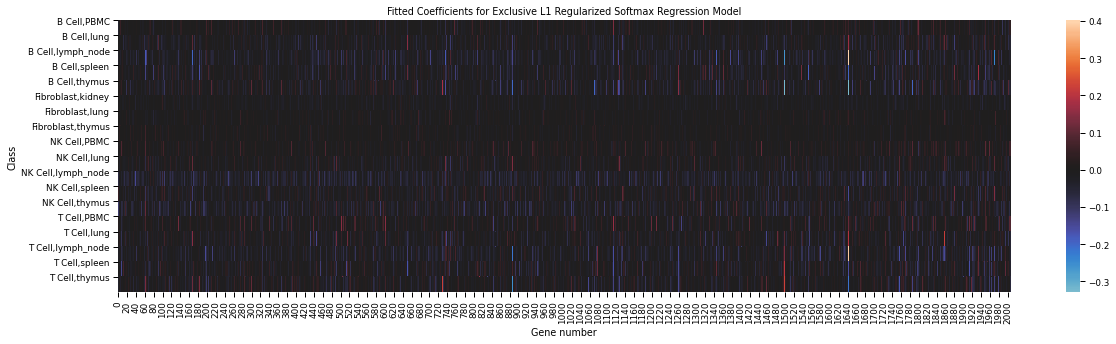

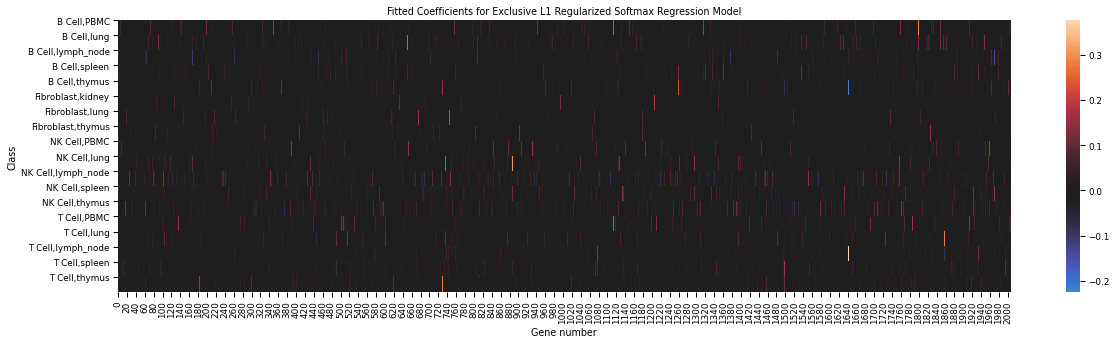

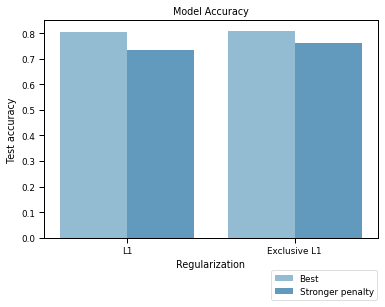

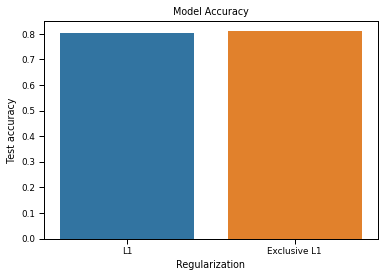

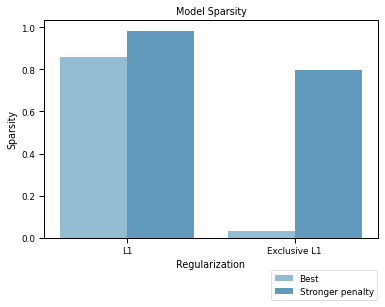

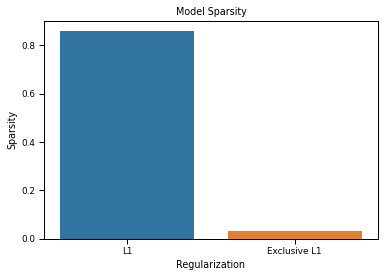

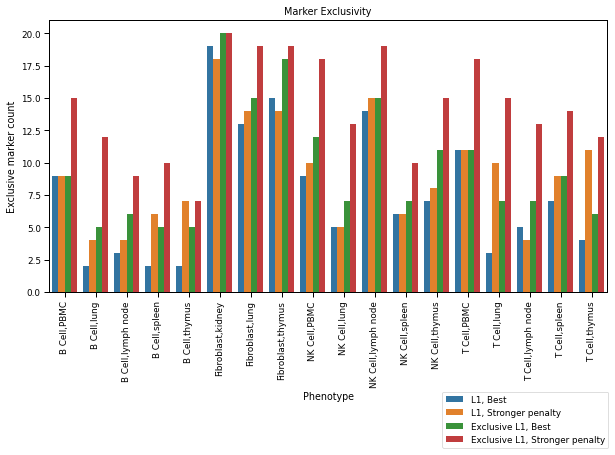

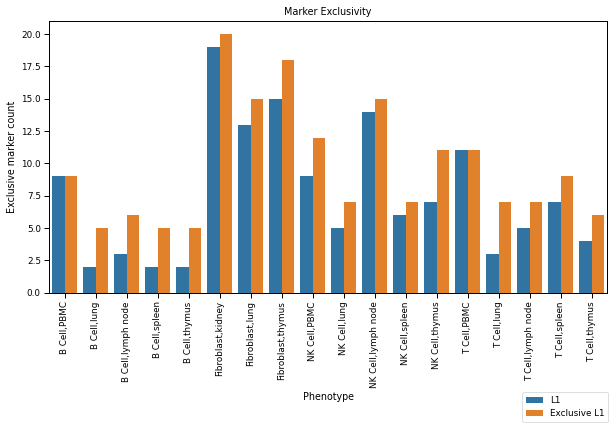

DONE.


In [38]:
cell_types_list = ['T Cell', 'Fibroblast', 'B Cell', 'NK Cell']
run_analysis_pipeline(adata, all_genes_info, "analysis_pipeline_hubmap_10x_healthy_only", random_state, cell_types_list=cell_types_list, extra_penalty_factor=10., n_jobs=6)

Trying to set attribute `.obs` of view, copying.


['B cell', 'B cell', 'B cell', 'B cell', 'T cell', 'T cell', 'T cell', 'natural killer cell']
ct_bounds: [3, 6, 7]
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   18.8s
[Parallel(n_jobs=6)]: Done  72 out of  72 | elapsed:  1.3min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9690             0.9465          0.4604        3.6349           0.0000           1.8972       0.3619        2.6585  0.1010
      2    0.9810             0.9820          0.5171        2.0305           0.0000           0.9988       0.4952        2.3272  0.0881
      3    0.9881             0.9907          0.5705        1.6561           0.0000           0.8181       0.5976        2.1159  0.0641
      4    0.9833             0.9849          0.5471        1.4628           0.0000           0.7565       0.6333        2.0135  0.0606
      5    0.9857             0.9896          0.5341        1.3627           0.0000           0.7169       0.6714        1.9558  0.0639
      6    0.9857             0.9896          0.

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


done.


... storing 'celltype' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'mouse.id' as categorical
... storing 'mouse.sex' as categorical
... storing 'plate.barcode' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Limb_Muscle
genes: ['Crisp1', 'C030019I05Rik', 'Lclat1', 'Col28a1', 'Neil1', 'Mzf1', 'Slc35f1', 'Trem2', 'Perp', 'Serpina3m', 'Mir425', 'Gm16119', 'Ptprr', 'Zfp296', 'Gm14872', 'Krt5', 'Lins', 'Aldh3a1', 'Itgb4', 'Hspa1l']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Lung
genes: ['Prkcc', 'Psg17', 'Ocln', 'Wbscr25', 'Unc5d', 'Bhlha15', 'Avpr2', 'Mia2', 'Abcc2', '1300015D01Rik', 'Gm10578', 'Otof', 'Fam129c', 'Ccdc113', 'Fbxl16', 'Cuzd1', 'Pls1', 'Hmgcll1', 'Cdkn2a', 'Mef2b']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
genes: ['Krt8', 'Rapgef3', 'Fcrl5', 'BC035044', 'Hes5', 'Lta', 'A230108P19Rik', 'Pigr', 'Cnr2', 'Plp1', 'Colq', 'Ell3', 'Car1', 'Chst3', 'Pik3r4', 'Kmo', 'Zfp94', 'Dennd3', 'Mup20']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat
genes: ['Ramp3', 'Als2cl', 'Tnfrsf10b', '2610019F03Rik', 'Itpk1', 'Tnfsf11', 'Cd226', 'Lime1', 'Cd96', 'Faah', 'Bend4', 'Amica1', 'Ccr8', 'Pdcd1', 'Itgae']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Lung
genes: ['Gm12505', 'A230057D06Rik', 'Hspb9', '1700027F09Rik', 'Trhde', 'Cst7', '1700001C19Rik', 'Thsd7b', 'Vmn2r59', 'Ctla4', 'T2', 'Lrfn1', 'Gm6213', 'Htra4', 'Chrm5', 'Rab4a', 'Ccdc146', 'Klhdc7a']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Tgtp1', 'Sit1', 'Gm128', 'Camk4', 'Il18r1', 'Slc12a7', 'Tlr12', 'Cnga1', 'Dapl1', 'Kcnmb4', 'Il4', 'Cd160', 'Gm14446']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


natural killer cell,Fat
genes: ['Klri2', 'Klrb1f', 'Klra14', 'Chad', 'Fasl', 'Stk32c', 'Tnfrsf9', 'Klre1', 'Klra9', 'Klra8', 'Klra13-ps', 'Tbx21', 'Klra4', 'Klrb1a', 'Ankrd5', 'Klrb1b', 'Cd244', '6330512M04Rik', 'Gm4956']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.25360742
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.23200805
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.157665
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.22575204
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.41615254
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                              set      pval      qval  \
336  GOBP_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION  0.000002  0.017148   

     intersection  reference  en

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


B cell,Fat
no exlusive genes for this module
B cell,Limb_Muscle
genes: ['D630023F18Rik', 'Myh15', 'Sept3', 'Col28a1', 'Wdr86', 'Zfp389', 'Perp', 'Olfr456', 'Ptprr', 'Cdh16', 'Cxcl3', 'Gprc6a', 'Itih1', 'Krt5', 'Aldh3a1', 'Acsm4', 'Htr7', 'Hspa1l', 'Krt15']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Lung
genes: ['Psg17', 'Wbscr25', 'Unc5d', 'Tmem213', 'Bhlha15', 'Mia2', 'Crhr2', '1300015D01Rik', 'Gm10578', 'Otof', 'Fam150a', 'Ccdc113', 'Fbxl16', 'Serpina3b', 'Hmgcll1', 'Cacng1', 'Apba2', 'Mapk15', 'Zp2', 'Ggt6']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
no exlusive genes for this module
T cell,Fat
genes: ['Ramp3', 'Txk', 'Bend4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Lung
genes: ['Hspb9', 'Tmem150b', 'Oas1d', 'A230057D06Rik', 'Ifltd1', '1700001C19Rik', 'Vmn2r59', 'Gm12505', 'Chrm5', 'Trhde', 'Slc8a3', 'C4bp-ps1', 'Psg22', 'Gm6213', 'Cd6', 'Thsd7b', 'Muc5b', 'Kera', 'Klhdc7a']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Satl1', 'Cd5', 'Cd4', 'Dapl1']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


natural killer cell,Fat
genes: ['Klrb1b', 'Klrb1a', 'Neurl1a', 'Klri2', 'Klra14', 'Neurl1b', 'Klre1', 'Cd244', 'Klra9', 'Klra8', 'Neu2', 'Klra13-ps', 'Tbx21', 'Klra4', 'Stk32c', 'Klrb1f']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


nan
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


NONE SIGNIFICANT
0.09684314
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.05959001
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
nan
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.14845571
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.069533646
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.092771836
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing thos

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   21.6s
[Parallel(n_jobs=6)]: Done  72 out of  72 | elapsed:  1.5min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9643             0.9424          0.3935        2.2460           0.0000           1.8987       0.3357        1.9817  0.0629
      2    0.9738             0.9785          0.4441        1.1633           0.0000           0.8097       0.3905        1.8224  0.0541
      3    0.9667             0.9769          0.4892        0.8654           0.0000           0.4688       0.4476        1.8017  0.0565
      4    0.9667             0.9769          0.4876        0.7481           0.0000           0.3343       0.5167        1.7679  0.0564
      5    0.9643             0.9757          0.4757        0.6843           0.0000           0.2717       0.5452        1.7453  0.0571
      6    0.9667             0.9751          0.

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Limb_Muscle
genes: ['Ccna2', 'Tbl2', 'Dsp', 'Neil1', 'Klc4', 'Slc35f1', 'Trem2', 'Perp', 'Mir425', 'Irf2bp1', 'Zfp296', 'Gprc6a', 'Krt5', 'Lins', 'Aldh3a1', 'Zfp958', 'Zcchc18', 'Acsl1', 'Hspa1l', 'Krt15']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Lung
genes: ['Diras2', 'Prkcc', 'Psg17', 'Ccdc148', 'Gh', 'BC053749', 'Wbscr25', 'Unc5d', 'Avpr2', 'Gpr137', 'Otof', 'Fam129c', 'Ptprn', 'Fbxl16', '9130014G24Rik', 'Rgs13', 'Spns3', 'Gm14137', '5033406O09Rik', 'Mef2b']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
genes: ['Mir5104', 'Rapgef3', 'BC035044', 'Muc4', 'Hes5', 'Lta', 'Actc1', 'Tmem8', 'A230108P19Rik', 'Pigr', 'Cnr2', 'Arid3b', 'Colq', 'Ell3', 'Cpsf4l', 'Chst3', 'Pik3r4', 'Kmo', 'Zfp94', 'Dennd3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat
genes: ['Ramp3', 'Als2cl', 'Tnfsf11', 'Galnt9', 'Amica1', 'Pdcd1', 'Pik3r5', 'Cd96', 'Bend4', '2610019F03Rik', 'Tigit', 'Cd226', 'Rgs16', 'C630004H02Rik', 'Pkp4', 'Ccr8', 'Gm590', 'Tnfrsf10b', 'Faah', 'Il20ra']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Lung
genes: ['Gm19510', 'Notch4', 'Chst2', 'Foxp3', 'Gdpd4', 'Rab4a', 'Mcm9', 'Klra6', '1700001C19Rik', 'Dcst1', 'Tst', 'Numb', 'Zg16', 'Lrfn1', 'Kifc1', 'Gpr111', 'Gria2', 'Tff3', 'Fam71f2', 'Klhdc7a']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Slfn1', 'Tlr12', '4930524L23Rik', 'Sit1', 'Cxcr3', 'Slc25a10', 'Cd160', 'Cd5', 'Tmem221', 'Tgtp1', 'Enthd1', 'Cnga1', 'Dapl1', 'Cd4', 'Gm10640', 'F2rl1', 'Folr4', 'Gm14446', 'D930028M14Rik', 'Ccr9']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


natural killer cell,Fat
genes: ['Klri2', 'Tm6sf2', 'Gp1bb', 'S1pr5', 'Il18rap', 'Klrc1', 'Klrb1f', 'Klra14', 'Stk32c', 'Klre1', 'Klra9', 'Ctla2b', 'Klra13-ps', 'Tbx21', 'Klra4', 'Serpinb9b', 'Klrb1a', 'Klrb1b', 'Cd244', '6330512M04Rik']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.1404083
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.07754944
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                      set      pval      qval  intersection  reference  \
5424   GOBP_CORNIFICATION  0.000001  0.010309             4         99   
2433  GOBP_KERATINIZATION  0.000007  0.026979             4        150   

      enquiry  background  
5424       20       23433  
2433       20       23433  
0.0799214
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.14042144
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.14693762
INFO:diffxpy: 13475 overlaps 

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Limb_Muscle
genes: ['Crisp1', 'Tas2r126', 'Col28a1', '9630013A20Rik', 'Neil1', 'Col11a2', 'Mzf1', 'Trem2', 'Perp', 'Serpina3m', 'Mir425', 'Cdh16', 'G730013B05Rik', 'Gprc6a', 'Krt5', 'Gdpd2', 'Aldh3a1', 'Acsm4', 'Hspa1l', 'Krt15']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Lung
genes: ['Prkcc', 'Psg17', 'Ranbp17', 'Wbscr25', 'Unc5d', 'Bhlha15', 'Mia2', 'Abcc2', '1300015D01Rik', 'Gm10578', 'Otof', 'Fam129c', 'Ccdc113', 'Fbxl16', 'Cuzd1', 'Pls1', 'Hmgcll1', 'Apba2', 'Cdkn2a', 'Mef2b']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B cell,Spleen
genes: ['Ffar2', 'Fcrl5', '1700030K09Rik', 'BC035044', 'Hes5', 'Lta', 'Pqlc2', 'Edaradd', 'A230108P19Rik', 'Pigr', 'Cnr2', 'Dtx1', 'Arid3b', 'Fam55b', 'Ell3', 'Chst3', 'Pik3r4', 'Kmo', 'Zfp94', 'Dennd3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Fat
genes: ['Ramp3', 'Als2cl', 'Txk', 'Bambi-ps1', 'Tnfsf11', 'Pdcd1', 'Pik3r5', 'Lime1', 'Cd96', 'Bend4', 'Itgae', '2610019F03Rik', 'Tigit', 'Cd226', 'C630004H02Rik', 'Pkp4', 'Ccr8', 'Tnfrsf10b', '1190002N15Rik', 'Faah']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Lung
genes: ['Gm19510', 'Hspb9', 'Gdpd4', 'A230057D06Rik', 'Ifltd1', '1700001C19Rik', 'Vmn2r59', 'Gm12505', 'Chrm5', 'Slc8a3', 'Psg22', 'Lrfn1', 'Padi6', 'Snph', 'Thsd7b', 'Muc5b', 'Gpr111', 'Htra4', 'Kera', 'Klhdc7a']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T cell,Spleen
genes: ['Gm14085', 'Slfn1', 'Prkcq', 'Ubash3a', 'Sit1', 'Cxcr3', 'Slc12a7', 'Kcnmb4', 'Cd160', 'Cd5', 'Tgtp1', 'Camk4', 'Dapl1', 'Sla2', 'Cd4', 'Cd6', 'F2rl1', 'Folr4', 'Gm14446', 'D930028M14Rik']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


natural killer cell,Fat
genes: ['Klri2', 'S1pr5', 'Klrc1', 'Klrb1f', 'Klra14', 'Fasl', 'Eomes', 'Stk32c', 'Klre1', 'Klra9', 'Klra8', 'Ctla2b', 'Klra13-ps', 'Tbx21', 'Klra4', 'Serpinb9b', 'Klrb1a', 'Klrb1b', 'Cd244', '6330512M04Rik']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.037576053
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.05057564
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.04906911
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.028433762
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
NONE SIGNIFICANT
0.054954283
INFO:diffxpy: 13475 overlaps found between refset (17949) and provided gene list (23433).
INFO:diffxpy: Found 3 empty sets, removing those.
                                               set      pval      qval  \
336   GOBP_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION  0.000004  0.026873   
2189                      

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


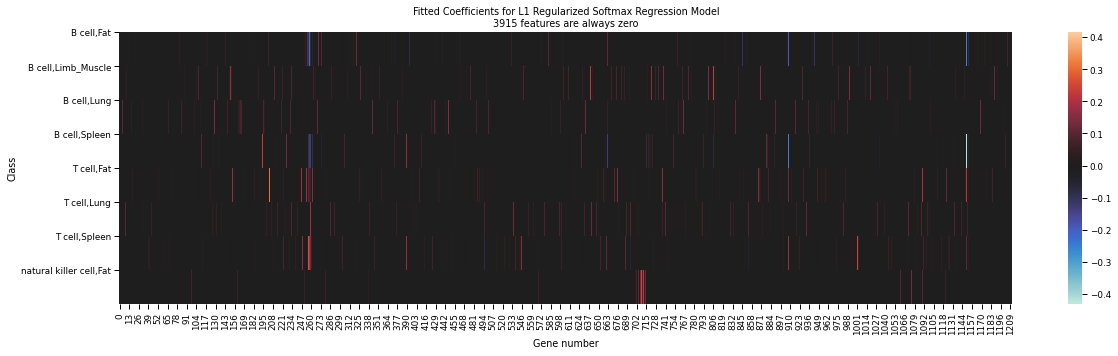

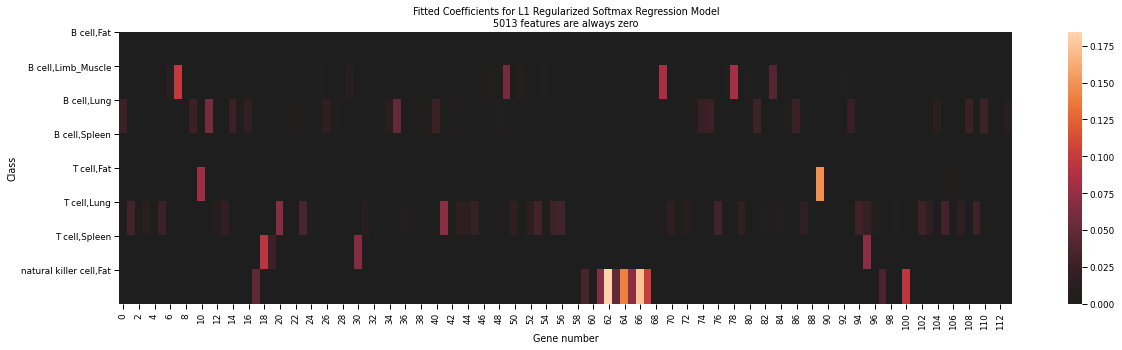

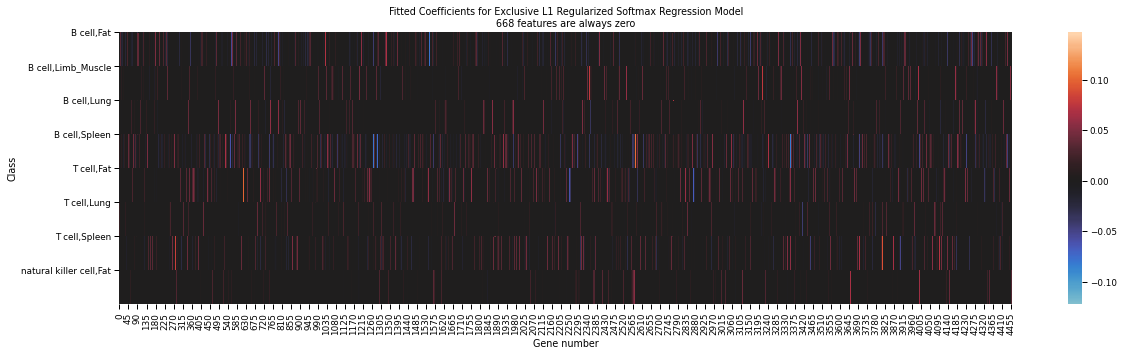

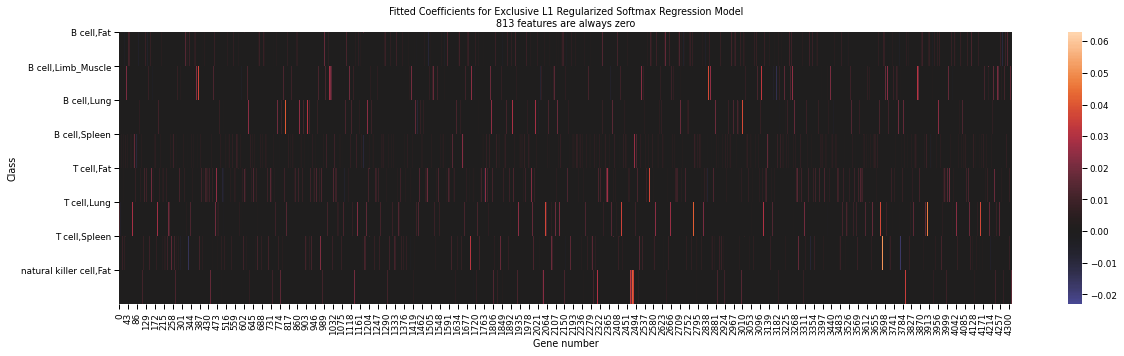

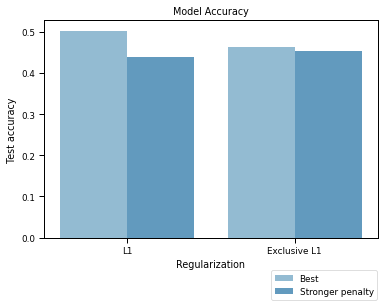

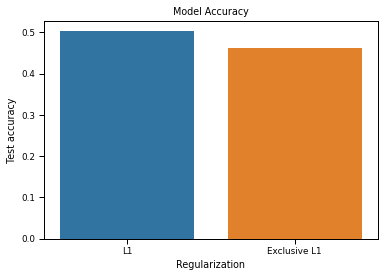

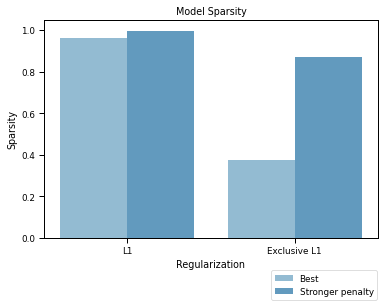

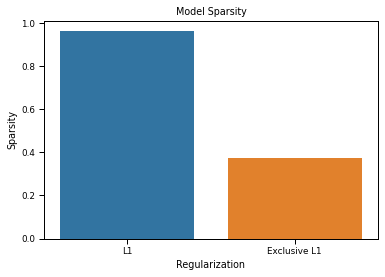

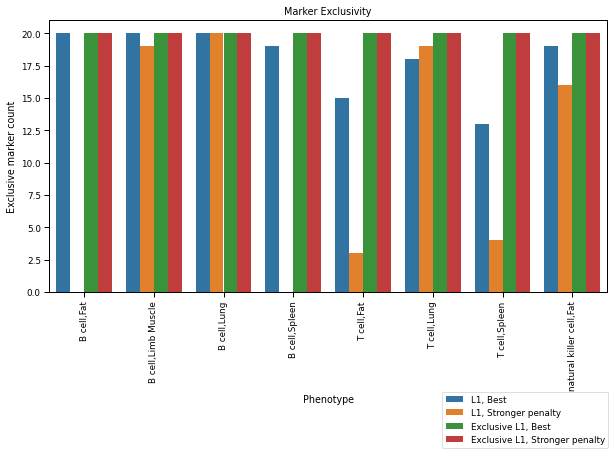

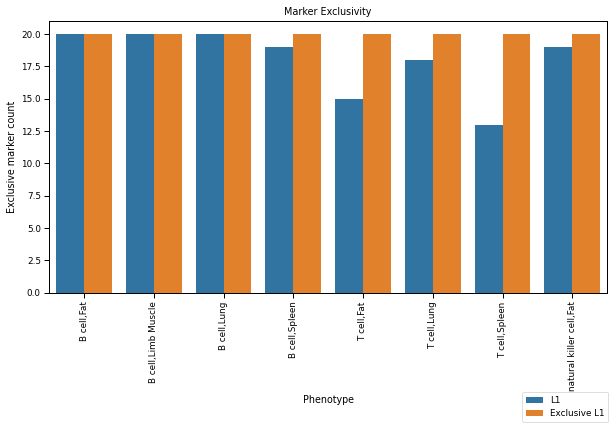

DONE.


In [31]:
cell_types_list = ['B cell', 'T cell', 'natural killer cell']
run_analysis_pipeline(adata, all_genes_info, "analysis_pipeline_tabula_muris_10x_2021_06_16", random_state, cell_types_list=cell_types_list, extra_penalty_factor=10., min_label_count=50, n_jobs=6)

In [126]:
fitted_model = load("analysis_pipeline_hubmap/L1/best_settings/model.joblib")
cell_types_list = ['T Cell', 'Fibroblast', 'B Cell', 'NK Cell']
le, _, _, _, _ = get_X_y_data(adata[adata.obs["celltype"].isin(cell_types_list)], random_state=random_state)
 

weights = fitted_model['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata.var[['symbol']]
exclusive_weights_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
# exclusive_weights_df.to_pickle(out_dir / 'exclusive_weights_table.pkl')
# exclusive_weights_df.to_latex(out_dir / 'exclusive_weights_table.tex', index=False, na_rep="", caption="")
tmp_dir = Path("tmp")
tmp_dir.mkdir(exist_ok=True)
generate_model_gene_module_reports(adata, exclusive_weights_df, "foo", tmp_dir, random_state)

Trying to set attribute `.obs` of view, copying.
/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


More than 50000 cells, subsampling...
B Cell,PBMC
genes: ['IFNGR2', 'FNBP1', 'EVI2B', 'ORAI2', 'CMSS1', 'LSM7', 'MIR155HG', 'ZFP36L1', 'FAM107B']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lung
genes: ['JCHAIN', 'HLA-DRB5', 'ZBTB20', 'SERPINB9']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,lymph_node
genes: ['LINC00926', 'RBM38', 'HLA-DMB']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,spleen
genes: ['HSPA1B', 'HES4']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


B Cell,thymus
no exlusive genes for this module
Fibroblast,kidney
genes: ['PRXL2A', 'GUCY1A1', 'APOL1', 'NRP1', 'DST', 'PCOLCE', 'PSD3', 'COL18A1', 'ITGA1', 'SYNE2', 'EMILIN1', 'CYP1B1', 'SPP1', 'PALLD', 'ADAM12', 'IL6ST', 'LAMB1', 'THBS1', 'NID1', 'VCAN']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,lung
genes: ['UAP1', 'EMP1', 'TCEAL9', 'UGDH', 'MT1E', 'TIMP1', 'FN1', 'DDR2', 'F3', 'MT1X', 'NBL1', 'CLU', 'CALD1', 'CYBRD1', 'CTTN', 'CNN3', 'C3']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fibroblast,thymus
genes: ['NDRG2', 'IGFBP7', 'PLIN2', 'TPM2', 'GSN', 'COL1A1', 'GPX3', 'SERPINF1', 'CD36', 'CAV1', 'HTRA1', 'RNASE1', 'PLPP3', 'RRAS', 'CDKN1C', 'COL6A1', 'CD14']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,PBMC
genes: ['HAVCR2', 'CHST12', 'GNG2', 'IFIT3', 'RSAD2', 'LIMD2', 'HLA-B', 'LAT2']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NK Cell,lung
genes: ['B3GNT7', 'PIP4K2A', 'PSAP', 'LYZ', 'NOL4L', 'PLAC8', 'PTGDS']


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fc34e5a9b90> (for post_execute):


KeyboardInterrupt: 

In [118]:
print(adata.shape)

(370362, 2127)


# Methods (code)

## Utility functions/classes

In [12]:
class SkorchLRAdapter:
    def __init__(self, skorch_lr_model):
        self.coef_ = skorch_lr_model.module_.linear.weight.detach().numpy()
        self.classes_ = skorch_lr_model.classes_

## Preprocessing functions (conform to scikit-learn's Estimator API)

In [13]:
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [14]:
FLOAT_DTYPES = (np.float64, np.float32, np.float16)

def check_non_neg(x):
    if (x < 0.).any():
        raise ValueError("Values in array must be non-negative")
    return x

class CellTotalCountNormalizer(TransformerMixin, BaseEstimator):
    def __init__(self):
        return

    def fit(self, X, y=None):
        X = check_array(X, dtype=FLOAT_DTYPES)
        X = check_non_neg(X)
        cell_totals = X.sum(axis=1)
        self.target_sum_ = np.median(cell_totals[cell_totals > 0])
        self.n_features_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X, dtype=FLOAT_DTYPES)
        X = check_non_neg(X)
        if X.shape[1] != self.n_features_:
            raise ValueError("Number of features in transform is different from the number of features in fit")
        
        cell_totals = X.sum(axis=1)
        cell_totals += cell_totals == 0
        cell_totals = cell_totals / self.target_sum_
        
        X = np.divide(X, cell_totals[:, None])
        return X
check_estimator(CellTotalCountNormalizer())

## Evaluate classifier performance

In [15]:
def _ct_acc_score(net, X, y, ct_bounds, ct_map):
    y_pred = net.forward(X)
    y = torch.tensor(np.vectorize(ct_map.get)(y))

    cumsum = y_pred.cumsum(1)
    groupsum = cumsum[:, ct_bounds]
    diff = torch.zeros_like(groupsum)
    diff[:, 1:] = cumsum[:, ct_bounds[:-1]]
    y_pred = groupsum - diff
    y_pred = F.log_softmax(y_pred, dim=-1)

    accuracy = (y_pred.argmax(dim=-1) == y).sum().float() / float(y.shape[0])
    accuracy = accuracy.item()
    return accuracy

def _ct_balanced_acc_score(net, X, y, ct_bounds, ct_map):
    y_pred = net.forward(X)
    y = torch.tensor(np.vectorize(ct_map.get)(y))

    cumsum = y_pred.cumsum(1)
    groupsum = cumsum[:, ct_bounds]
    diff = torch.zeros_like(groupsum)
    diff[:, 1:] = cumsum[:, ct_bounds[:-1]]
    y_pred = groupsum - diff
    y_pred = F.log_softmax(y_pred, dim=-1)
    y_pred = y_pred.argmax(dim=-1)
    
    return balanced_accuracy_score(y, y_pred)

def get_class_weights(y_train, ct_map):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    multilabel_class_weights = torch.from_numpy(class_weights).float()
    
    y_train_ct = np.vectorize(ct_map.get)(y_train)
    celltype_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_ct), y=y_train_ct)
    celltype_class_weights = torch.from_numpy(celltype_class_weights).float()
    return multilabel_class_weights, celltype_class_weights
    

def get_ct_scorers(ct_bounds, ct_map):   
    ct_acc_score_fn = partial(_ct_acc_score, ct_bounds=ct_bounds, ct_map=ct_map)
    ct_balanced_acc_score_fn = partial(_ct_balanced_acc_score, ct_bounds=ct_bounds, ct_map=ct_map)
    return ct_acc_score_fn, ct_balanced_acc_score_fn

In [16]:
def eval_model(model, X_train, y_train, X_test, y_test, le):
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print(f"train acc:         {train_acc}")
    print(f"test acc:          {test_acc}")
    y_pred = model.predict(X_test)
    test_bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"test balanced acc: {test_bal_acc}")
    print("classification report:")
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print(report)
    return test_bal_acc

In [17]:
def plot_training_curves(history, columns=['train_loss', 'valid_loss'], ylabel='Loss'):
    fig, ax = plt.subplots(1, 1)
    for col in columns:
        data = history[:, col]
        ax.plot(np.arange(1, len(data) + 1), data, label=col)
    ax.legend()
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Epoch') 

## Check sparsity of classifier weights (visual inspection)

In [18]:
def consolidate_non_zero_features(coefs):
    print(coefs.shape[1])
    always_zero = np.ones(coefs.shape[1])
    zeros = (coefs == 0).sum(axis=0)
    always_zeros = zeros == coefs.shape[0]
    print(f"features that are always zero: {always_zeros.sum()}")
    return ~always_zeros

def check_sparsity(lr_model, label_encoder, model_name="Softmax Regression Model", figure_savefile=None):
    # overall sparsity
    n_weights = np.prod(lr_model.coef_.shape)
    overall_sparsity = (n_weights - np.count_nonzero(lr_model.coef_)) / n_weights
    print(f"Overall sparsity: {overall_sparsity}")
    
    sparsity = (lr_model.coef_.shape[1] - np.count_nonzero(lr_model.coef_, axis=1)) / lr_model.coef_.shape[1]
    print("fraction of weights that are zero:")
    for class_name, sparsity in zip(label_encoder.inverse_transform(lr_model.classes_), sparsity):
        print(f"{class_name}: {sparsity}")

    non_zero_selector = consolidate_non_zero_features(lr_model.coef_)
    n_always_zero = (~non_zero_selector).sum()
    
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.heatmap(lr_model.coef_[:, non_zero_selector], center=0, ax=ax)
    # We want to show all ticks...
    ax.set_yticks(np.arange(len(lr_model.classes_)))
    # ... and label them with the respective list entries
    ax.set_yticklabels(label_encoder.inverse_transform(lr_model.classes_), rotation=0)
    ax.set_xlabel("Gene number")
    ax.set_ylabel("Class")
    if n_always_zero > 0:
        ax.set_title(f'Fitted Coefficients for {model_name}\n{n_always_zero} features are always zero')
    else:
        ax.set_title(f'Fitted Coefficients for {model_name}')
    if figure_savefile is not None:
        plt.savefig(f'{figure_savefile}.png')
        plt.savefig(f'{figure_savefile}.pdf')
    return overall_sparsity

## Find exclusive features for each class based on a model

In [19]:
def find_exclusive_model_weights(weights, class_names, feature_symbols, k=20, verbose=False):
    all_features_pos = []
    all_features_pos_class_names = []
    for class_value, class_name in zip(range(weights.shape[0]), class_names):
        top_features_abs = (-np.abs(weights[class_value, :])).argsort()[:k]
        top_features_pos = (-np.maximum(0., weights[class_value, :])).argsort()[:k]
        top_features_neg = (np.minimum(0., weights[class_value, :])).argsort()[:k]

        all_features_pos.append(set(feature_symbols.iloc[top_features_pos, 0]))
        all_features_pos_class_names.append(class_name)
        
        tmp_df = feature_symbols.assign(weight = weights[class_value, :])
        if verbose:
            print(class_name)
            print(f"Top features (abs):")
            print(tmp_df.iloc[top_features_abs, :])
            print()
            print(f"Top features (pos):")
            print(tmp_df.iloc[top_features_pos, :])
            print()
            print(f"Top features (neg):")
            print(tmp_df.iloc[top_features_neg, :])
            print()
            print()
            print()
    
    exclusive_results = {}
    for i, class_label in enumerate(all_features_pos_class_names):
        exclusive = all_features_pos[i].difference(set().union(*(all_features_pos[:i] + all_features_pos[i+1:])))
        exclusive_results[class_label] = list(exclusive)
        if verbose:
            print(class_label)
            print(exclusive)
    
    exclusive_lasso_result_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in exclusive_results.items() ]))
    return exclusive_lasso_result_df

def get_exclusive_model_weights_for_gsea(weights, class_names, feature_symbols, k=20, verbose=False):
    all_features_pos = []
    all_features_pos_scores = []
    all_features_pos_class_names = []
    for class_value, class_name in zip(range(weights.shape[0]), class_names):
        top_features_abs = (-np.abs(weights[class_value, :])).argsort()[:k]
        top_features_pos = (-np.maximum(0., weights[class_value, :])).argsort()[:k]
        top_features_neg = (np.minimum(0., weights[class_value, :])).argsort()[:k]

        tmp_df = feature_symbols.assign(weight = weights[class_value, :])
        all_features_pos.append(set(feature_symbols.iloc[top_features_pos, 0]))
        all_features_pos_scores.append(tmp_df.iloc[top_features_pos, :])
        all_features_pos_class_names.append(class_name)
        
        if verbose:
            print(class_name)
            print(f"Top features (abs):")
            print(tmp_df.iloc[top_features_abs, :])
            print()
            print(f"Top features (pos):")
            print(tmp_df.iloc[top_features_pos, :])
            print()
            print(f"Top features (neg):")
            print(tmp_df.iloc[top_features_neg, :])
            print()
            print()
            print()
    
    exclusive_results = {}
    exclusive_scores = {}
    for i, class_label in enumerate(all_features_pos_class_names):
        exclusive = all_features_pos[i].difference(set().union(*(all_features_pos[:i] + all_features_pos[i+1:])))
        exclusive = list(exclusive)
        exclusive_results[class_label] = exclusive
        
        score_df = all_features_pos_scores[i]
        score_df = score_df[score_df['symbol'].isin(exclusive)]
        exclusive_scores[class_label] = score_df
        if verbose:
            print(class_label)
            print(exclusive)
    
    exclusive_lasso_result_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in exclusive_results.items() ]))
    return exclusive_lasso_result_df, exclusive_scores

## Gene set enrichment analysis

In [20]:
GO_BP_GENE_SET_FILE = 'c5.go.bp.v7.4.symbols.gmt'
go_bp_rs = de.enrich.RefSets(fn=GO_BP_GENE_SET_FILE)

def clean_up_enrich_table_for_printing(table, term_set_name='GO'):
    table['set'] = table.apply(lambda row: ' '.join(row['set'].split('_')[1:]), axis=1)
    table.rename(columns={'qval': 'Corrected p-val', 'set': f'{term_set_name} term'}, inplace=True)
    return table

def do_enrich(gene_list, gene_scores, background, save_file):
    max_score = np.amax(gene_scores)
    print(max_score)
    enr = de.enrich.test(ref=go_bp_rs, scores=gene_scores, gene_ids=gene_list, clean_ref=True, all_ids=background, threshold = max_score + 1.)
    enr_table = enr.summary().loc[enr.summary()['qval'] < 0.05]
    if enr_table.shape[0] > 0:
        print(enr_table.head(n=20))
        enr_table = enr_table.head(n=20)[['set', 'qval']]
        enr_table = clean_up_enrich_table_for_printing(enr_table, 'GO')
#         print(enr_table)
        enr_table.to_latex(save_file, index=False)
    else:
        print('NONE SIGNIFICANT')

## Inspect gene expression in Cells and Tissues
Given a list of genes and a tissue and a cell type, plot 4 UMAP subplots
1. Highlight only cells of (cell type + tissue)
2. Highlight only cells of (cell type)
3. Highlight only cells of (tissue)
4. Color by expression of the genedef inspect_gene_expression_scatters(adata, genes, celltype, tissue):

In [21]:
def gene_expression_report(adata, genes, celltype, tissue, model_name, save_path):
    if 'X_umap' not in adata.obsm:
        print("computing umap...")
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        adata.raw = adata
        sc.pp.scale(adata)
        sc.tl.pca(adata)
        sc.pp.neighbors(adata, n_pcs=50)
        sc.tl.umap(adata)
        print("done.")
    
    n_plots = 6 + len(genes)
    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))
    width = 20
    height = 5 * n_rows
    fig, all_axs = plt.subplots(n_rows, n_cols, figsize=(width, height), gridspec_kw={'hspace': 0.25})

    # Cell identity embedding plots
    combined_key = f"{celltype},{tissue}"
    adata.obs[f"is_{combined_key}"] = pd.Categorical((adata.obs_vector('celltype') == celltype) & (adata.obs_vector('tissue') == tissue))
    adata.uns[f'is_{combined_key}_colors'] = ['grey', 'red']

    adata.obs[f'is_{celltype}'] = pd.Categorical(adata.obs_vector('celltype') == celltype)
    adata.uns[f'is_{celltype}_colors'] = ['grey', 'red']
    
    adata.obs[f'is_{tissue}'] = pd.Categorical(adata.obs_vector('tissue') == tissue)
    adata.uns[f'is_{tissue}_colors'] = ['grey', 'red']

    sc.pl.umap(adata, color=f'is_{combined_key}', title=[combined_key], show=False, ax=all_axs[0, 0])
    sc.pl.umap(adata, color=f'is_{celltype}', title=[celltype], show=False, ax=all_axs[0, 1])
    sc.pl.umap(adata, color=f'is_{tissue}', title=[tissue], show=False, ax=all_axs[0, 2])
    for ax in all_axs[0, :3]:
        ax.get_legend().remove()

    # Gene-group score embedding plot
    if np.array_equal(adata.var['symbol'], adata.var.index):
        # index is symbols too, no need to use ensembl
        score_genes = genes
    else:
        score_genes = [ adata.var.loc[adata.var['symbol'] == symb, 'ens'].iloc[0] for symb in genes]
    
    score_name = f'{combined_key} module score'
    sc.tl.score_genes(adata, score_genes, score_name=score_name)
    sc.pl.umap(adata, color=score_name, show=False, ax=all_axs[1, 0])
    
    # Gene-group score histogram (density) plot
    score_df = adata.obs[['celltype', 'tissue', score_name]]
    category_names = ["Rest", f"{celltype},Other tiss", f"Other CT,{tissue}", combined_key]
    categories = []
    for _, row in score_df.iterrows():
        if row['celltype'] == celltype:
            if row['tissue'] == tissue:
                categories.append(category_names[3])
            else:
                categories.append(category_names[1])
        else:
            if row['tissue'] == tissue:
                categories.append(category_names[2])
            else:
                categories.append(category_names[0])
    score_df['Category'] = categories
    sns.histplot(data=score_df, x=score_name, kde=True, hue='Category', hue_order=category_names, stat='density', common_norm=False, ax=all_axs[1, 1])
    
    # Cell count bar plot
    graph = sns.countplot(ax=all_axs[1, 2], x='Category', order=category_names, data=score_df)
    # graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
    for p in graph.patches:
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
    
    # All gene embedding plots
    for i, gene in enumerate(genes):
        row_idx = (i // n_cols) + 2
        col_idx = i % n_cols
        sc.pl.umap(adata, color=gene, gene_symbols='symbol', show=False, ax=all_axs[row_idx, col_idx])
    
    fig.suptitle(f"{combined_key} gene module report for {model_name}", y=0.92, fontsize='x-large')
    plt.savefig(f"{save_path}_150dpi.png", dpi=150)
    plt.savefig(f"{save_path}_200dpi.png", dpi=200)
#     plt.savefig(f"{save_path}_300dpi.png", dpi=300)
#     plt.savefig(f"{save_path}.pdf")
    plt.close()

In [22]:
def generate_model_gene_module_reports(adata, gene_df, model_name, folder, random_state, max_cells=50000):
    if adata.shape[0] > max_cells:
        print(f"More than {max_cells} cells, subsampling...")
        adata = sc.pp.subsample(adata, n_obs=max_cells, random_state=random_state, copy=True)
    if not isinstance(folder, Path):
        folder = Path(folder)
    folder.mkdir(parents=True, exist_ok=True)
    for gene_module in gene_df.columns:
        print(gene_module)
        genes = gene_df[gene_module].dropna().tolist()
        if len(genes) == 0:
            print('no exlusive genes for this module')
            continue
        print(f"genes: {genes}")
        celltype, tissue = gene_module.split(',')
        report_path = folder / f"{celltype}_{tissue}"
        gene_expression_report(adata, genes, celltype, tissue, model_name, report_path)  

In [27]:
# manual gene lists:
manual_gene_df = {
    'B Cell,lung': ['LINC01781', 'TXNDC5', 'DERL3', 'JCHAIN'],
    'B Cell,lymph_node': ['LY9', 'SWAP70', 'LINC00926', 'PDE4B'],
    'B Cell,PBMC': ['HLA-DQA1', 'MIR155HG', 'IFNGR2'],
    'B Cell,spleen': ['HES4', 'SPIB', 'DNASE1L3', 'CD22', 'BANK1'],
    'B Cell,thymus': ['PRMT1', 'NEK6', 'NME1'],
    'Fibroblast,kidney': ['ITGA1'],
    'Fibroblast,lung': ['CYBRD1', 'PCOLCE', 'NBL1', 'C3'],
    'Fibroblast,thymus': ['PLPP3'],
    'NK Cell,lung': ['SPON2', 'PIP4K2A', 'NOL4L'],
    'NK Cell,PBMC': ['LASP1', 'C1orf21', 'GNG2', 'FEZ1', 'RAMP1', 'CHST12', 'UBE2F'],
    'NK Cell,spleen': ['CEMIP2', 'METRNL'],
    'NK Cell,thymus': ['UBE2S'],
    'T Cell,lung': ['DUSP4'],
    'T Cell,lymph_node': ['SOCS3'],
    'T Cell,PBMC': ['ADTRP', 'LAT', 'PABPC1', 'GIMAP5', 'CMSS1', 'TSHZ2'],
    'T Cell,spleen': ['SPRY2', 'DBN1', 'ANTKMT', 'ILF3-DT'],
    'T Cell,thymus': ['ARMH1', 'SOX4', 'NUCB2', 'ITM2A', 'LCK']
}
manual_gene_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in manual_gene_df.items() ]))
generate_model_gene_module_reports(adata_subset, manual_gene_df, "manual refinement", "model_gene_module_reports/ct_tiss_rm_non_sequential_exclusive_l1_penalty_manual_inspection/")

B Cell,lung
computing umap...


KeyboardInterrupt: 

In [28]:
# 'T Cell,PBMC': ['ADTRP', 'LAT', 'PABPC1', 'GMAP5', 'CMSS1', 'TSHZ2'],
#     'T Cell,spleen': ['SPRY2', 'DBN1', 'ANTKMT', 'ILF3-DT'],
#     'T Cell,thymus': ['ARMH1', 'SOX4', 'NUCB2', 'ITM2A', 'LCK']
for g in ['SPRY2', 'DBN1', 'ANTKMT', 'ILF3-DT']:
    print(g in adata_subset.var['symbol'].values)

True
True
True
True


## Lasso (Pytorch)

In [23]:
class MultinomialLRModel(nn.Module):
    def __init__(self, input_size, output_size):
        #super(MultinomialLRModel, self).__init__()
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.linear = nn.Linear(input_size, output_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        return self.softmax(self.linear(x))

In [24]:
# class LassoRegularizedLR(NeuralNetClassifier):
#     def __init__(self, *args, lambda1=0.01, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.lambda1 = lambda1
        
#     def get_loss(self, y_pred, y_true, X=None, training=False):
#         loss = super().get_loss(y_pred, y_true, X=X, training=training)
#         loss += self.lambda1 * self.module_.linear.weight.abs().sum()
#         return loss

## Exclusive Lasso (Pytorch)

### Weight thresholding

In [25]:
class SparseWeightsThresholder(Callback):
    def __init__(self, eps=1e-4):
        self.eps = eps

    def on_epoch_end(self, net, *args, **kwargs):
         with torch.no_grad():
            net.module_.linear.weight[net.module_.linear.weight.abs() < self.eps] = 0.
        
#     def on_train_end(self, net, *args, **kwargs):
#         with torch.no_grad():
#             n_weights = np.prod(net.module_.linear.weight.shape)
#             sparsity = (n_weights - torch.count_nonzero(net.module_.linear.weight.detach())) / n_weights
#             print(f"sparsity before thresholding: {sparsity}")
#     #         near_zero_idx = torch.isclose(net.module_.linear.weight, torch.zeros_like(net.module_.linear.weight))
#     #         net.module_.linear.weight[near_zero_idx] = 0.
#             net.module_.linear.weight[net.module_.linear.weight.abs() < self.eps] = 0.
#             sparsity = (n_weights - torch.count_nonzero(net.module_.linear.weight.detach())) / n_weights
#             print(f"sparsity after thresholding : {sparsity}")

### Gradient clipping (hacky approximation)

In [26]:
# class EnforceSparseWeights(Callback):
#     def __init__(self, eps=0.001):
#         self.eps = eps
    
#     def on_grad_computed(self, net, named_parameters, **kwargs):
#         self.sign_before_update = torch.sign(net.module_.linear.weight)
    
#     def on_batch_end(self, net, **kwargs):
#         crossed_zero_idx = self.sign_before_update != torch.sign(net.module_.linear.weight)
#         within_eps_idx = torch.abs(net.module_.linear.weight) < self.eps
#         zero_fill_idx = crossed_zero_idx & within_eps_idx
#         if zero_fill_idx.any():
#             # print(f"zeros set: {zero_fill_idx.sum()}")
#             with torch.no_grad():
#                 net.module_.linear.weight[zero_fill_idx] = 0.
        

In [27]:
def exclusive_lasso_penalty(W):
    penalty = LA.norm(W, ord=1, dim=0)
    penalty= LA.norm(penalty, ord=2)
    return penalty

In [28]:
# class ExclusiveLassoRegularizedLR(NeuralNetClassifier):
#     def __init__(self, *args, lambda1=0.01, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.lambda1 = lambda1
        
#     def get_loss(self, y_pred, y_true, X=None, training=False):
#         loss = super().get_loss(y_pred, y_true, X=X, training=training)
#         loss += self.lambda1 * exclusive_lasso_penalty(self.module_.linear.weight)
#         return loss

## Adding Cell type classification objective

In [29]:
def build_ct_map(ct_group_bounds):
    ct_map = {}
    bound_idx = 0
    for i in range(ct_group_bounds[-1] + 1):
        if i > ct_group_bounds[bound_idx]:
            bound_idx += 1
        ct_map[i] = bound_idx
    return ct_map

class SequentialMultiLabelClassifier(NeuralNetClassifier):
    def __init__(self, *args,
                 ct_group_bounds=None,
                 ct_map=None,
                 secondary_criterion_weight=None,
                 lambda_clf=1.,
                 regularization=None,
                 lambda_reg=0.01,
#                  ct_map=None, # Hack to get around sklearn bug
                 **kwargs):
#         print("args:")
#         print(args)
#         print("kwargs:")
#         print(kwargs)
        super().__init__(*args, **kwargs)
        self.ct_group_bounds = ct_group_bounds
        self.ct_map = ct_map
        self.secondary_criterion_weight = secondary_criterion_weight
        self.lambda_clf = lambda_clf
        if regularization not in [None, 'l1', 'exclusive_l1']:
            raise ValueError('Invalid regularization parameter.')
        self.regularization = regularization
        self.lambda_reg = lambda_reg

    def get_ct_loss(self, y_pred, y_true):
        y_true = torch.tensor(np.vectorize(self.ct_map.get)(y_true))

        cumsum = y_pred.cumsum(1)
        groupsum = cumsum[:, self.ct_group_bounds]
        diff = torch.zeros_like(groupsum)
        diff[:, 1:] = cumsum[:, self.ct_group_bounds[:-1]]
        y_pred = groupsum - diff

        return F.cross_entropy(y_pred, y_true, weight=self.secondary_criterion_weight)
    
    def get_loss(self, y_pred, y_true, X=None, training=False):
        loss_multilabel = super().get_loss(y_pred, y_true, X=X, training=training)
        loss_celltype = torch.tensor(0.)
        if self.lambda_clf != 0.:
            loss_celltype = self.get_ct_loss(y_pred, y_true)
        loss_regularizer = torch.tensor(0.)
        if self.regularization == 'exclusive_l1':
            loss_regularizer = exclusive_lasso_penalty(self.module_.linear.weight)
        elif self.regularization == 'l1':
            loss_regularizer = self.module_.linear.weight.abs().sum()
        total_loss = loss_multilabel + self.lambda_clf * loss_celltype + self.lambda_reg * loss_regularizer
        
        prefix = 'train' if training else 'valid'
        self.history.record_batch(prefix + '_loss_ML', loss_multilabel.item())
        self.history.record_batch(prefix + '_loss_CT', loss_celltype.item())
        self.history.record_batch(prefix + '_loss_reg', loss_regularizer.item())
        
        return total_loss

# Results

In [44]:
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")

0: B Cell,PBMC
1: B Cell,lung
2: B Cell,lymph_node
3: B Cell,spleen
4: B Cell,thymus
5: Fibroblast,kidney
6: Fibroblast,lung
7: Fibroblast,thymus
8: NK Cell,PBMC
9: NK Cell,lung
10: NK Cell,lymph_node
11: NK Cell,spleen
12: NK Cell,thymus
13: T Cell,PBMC
14: T Cell,lung
15: T Cell,lymph_node
16: T Cell,spleen
17: T Cell,thymus


In [45]:
ct_bounds = torch.tensor([4, 7, 12, 17])
ct_map = build_ct_map(ct_bounds)

In [46]:
# Prep
ct_acc_score_fn, ct_balanced_acc_score_fn = get_ct_scorers(ct_bounds, ct_map)
multilabel_class_weights, celltype_class_weights = get_class_weights(y_train, ct_map)


balanced_acc = EpochScoring(name='balanced_acc', scoring='balanced_accuracy', lower_is_better=False)
ct_acc = EpochScoring(name='CT_acc', scoring=ct_acc_score_fn, lower_is_better=False)
ct_balanced_acc = EpochScoring(name='CT_balanced_acc', scoring=ct_balanced_acc_score_fn, lower_is_better=False)

## Non-sequential classifier (no penalty)

In [ ]:
cp = Checkpoint(dirname='checkpoints/non-sequential_no_penalty')
net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=10,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.) #

pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])
pipe.fit(X_train, y_train)
pipe['net'].initialize()
pipe['net'].load_params(checkpoint=cp)
eval_model(pipe, X_train, y_train, X_test, y_test)
test_ct_acc = ct_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(net), le)

In [ ]:
weights = pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
non_sequential_no_penalty_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
non_sequential_no_penalty_result_df

In [ ]:
generate_model_gene_module_reports(adata_subset, non_sequential_no_penalty_result_df, "Non-sequential, No penalty", "model_gene_module_reports/non_sequential_no_penalty/")

## Non-sequential classifier w/L1

In [ ]:
cp = Checkpoint(dirname='checkpoints/non-sequential_l1')
net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=100,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.01) #

pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])
pipe.fit(X_train, y_train)
pipe['net'].initialize()
pipe['net'].load_params(checkpoint=cp)
eval_model(pipe, X_train, y_train, X_test, y_test)
test_ct_acc = ct_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(net), le)

In [ ]:
weights = pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
non_sequential_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
non_sequential_l1_result_df

In [ ]:
generate_model_gene_module_reports(adata_subset, non_sequential_l1_result_df, "Non-sequential, L1 penalty", "model_gene_module_reports/non_sequential_l1_penalty/")

### Quick gridsearch

In [39]:
shared_grid = {
    'net__max_epochs': [10, 20, 100],
    'net__lr': [0.01, 0.001],
    'net__optimizer': [torch.optim.Adam],
    'net__callbacks__lr_scheduler__factor': [0.5]
}
param_grid = copy.deepcopy(shared_grid)
param_grid['net__lambda_clf'] = [0.]
param_grid['net__regularization'] = ['l1']
param_grid['net__lambda_reg'] = [0., 0.001, 0.01, 0.1]

net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                               ],
                                     secondary_criterion_weight=celltype_class_weights)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])

gs_l1 = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=4, n_jobs=-1)

gs_l1.fit(X_train, y_train)
dump(gs_l1, 'quick_gridsearch_l1.joblib') 

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 27.1min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9267             0.9519          0.7936        1.3254           0.0000           0.8407       0.8098        1.0832  1.7529
      2    0.9417             0.9579          0.8028        0.8550           0.0000           0.4459       0.8222        0.9897  1.7050
      3    0.9404             0.9563          0.7989        0.7968           0.0000           0.4243       0.8202        0.9718  1.8115
      4    0.9373             0.9553          0.7997        0.7734           0.0000           0.4116       0.8155        0.9597  1.8037
      5    0.9390             0.9541          0.8028        0.7677           0.0000           0.4090       0.8156        0.9721  2.3129
      6    0.9381             0.9558          0.

['quick_gridsearch_l1.joblib']

{'net__callbacks__lr_scheduler__factor': 0.5, 'net__lambda_clf': 0.0, 'net__lambda_reg': 0.001, 'net__lr': 0.001, 'net__max_epochs': 10, 'net__optimizer': <class 'torch.optim.adam.Adam'>, 'net__regularization': 'l1'}
train acc:         0.8402188927850388
test acc:          0.8190048133626597
test balanced acc: 0.8035430216647907
classification report:
                    precision    recall  f1-score   support

       B Cell,PBMC       0.92      0.99      0.96       210
       B Cell,lung       0.94      0.97      0.95      1635
 B Cell,lymph_node       0.70      0.69      0.70      3321
     B Cell,spleen       0.84      0.73      0.78      4085
     B Cell,thymus       0.46      0.58      0.51      1204
 Fibroblast,kidney       0.90      0.97      0.93        29
   Fibroblast,lung       0.98      0.99      0.98       546
 Fibroblast,thymus       0.93      0.98      0.96       111
      NK Cell,PBMC       0.76      0.97      0.85       720
      NK Cell,lung       0.92      0.94      

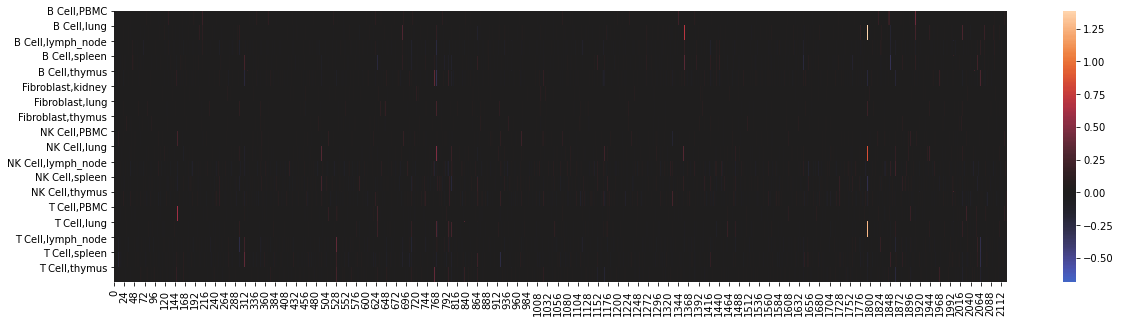

In [40]:
print(gs_l1.best_params_)
eval_model(gs_l1.best_estimator_, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(gs_l1.best_estimator_['net'], np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(gs_l1.best_estimator_['net'], np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(gs_l1.best_estimator_['net']), le)

In [41]:
weights = gs_l1.best_estimator_['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
gs_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
gs_l1_result_df

B Cell,PBMC B Cell,lung B Cell,lymph_node B Cell,spleen B Cell,thymus  \
0        FNBP1      JCHAIN         LINC00926          CD22          CD82   
1        CMSS1    SERPINB9            POU2F2        HSPA1B           NaN   
2     MIR155HG      ZBTB20           RPL22L1       TAMALIN           NaN   
3       IFNGR2    HLA-DRB5             RBM38          HES4           NaN   
4         ACP5         NaN               NaN           NaN           NaN   
5      FAM107B         NaN               NaN           NaN           NaN   
6         LSM7         NaN               NaN           NaN           NaN   
7        EVI2B         NaN               NaN           NaN           NaN   
8        ORAI2         NaN               NaN           NaN           NaN   
9      ZFP36L1         NaN               NaN           NaN           NaN   
10         NaN         NaN               NaN           NaN           NaN   
11         NaN         NaN               NaN           NaN           NaN   
12         NaN         NaN               NaN           NaN           NaN   
13         NaN         NaN               NaN           NaN           NaN   
14         NaN         NaN               NaN           NaN           NaN   
15         NaN         NaN               NaN           NaN           NaN   
16         NaN         NaN               NaN           NaN           NaN   
17         NaN         NaN               NaN           NaN           NaN   
18         NaN         NaN               NaN           NaN           NaN   

   Fibroblast,kidney Fibroblast,lung Fibroblast,thymus NK Cell,PBMC  \
0               TPM1          TCEAL9              CAV1         GNG2   
1              THBS1            MT1E             MGST1       HAVCR2   
2               ACO1          CYBRD1             PLPP3          CD7   
3               PSD3           CALD1              CD14        IFIT3   
4              PALLD             FN1            COL1A1        RSAD2   
5              ITGA1            NBL1              RCN1       CHST12   
6               NRP1        SERPING1              TPM2        HLA-B   
7              SYNE2            EMP1               GSN        LIMD2   
8           CCDC102B          LGALS1             SPARC          NaN   
9             PRXL2A            CNN3            RNASE1          NaN   
10           COL18A1            UAP1            IGFBP7          NaN   
11               DST            MT1X               CFD          NaN   
12             LAMB1             CLU             PLIN2          NaN   
13            CYP1B1            CTTN              CD36          NaN   
14              VCAN              C3              GPX3          NaN   
15           EMILIN1           TIMP1          SERPINF1          NaN   
16             SYNE1              F3             HTRA1          NaN   
17              SPP1             NaN               NaN          NaN   
18            SLC8A1             NaN               NaN          NaN   

   NK Cell,lung NK Cell,lymph_node NK Cell,spleen NK Cell,thymus T Cell,PBMC  \
0         PLAC8             TOMM40           ATF3           RGS2       BIRC2   
1         PTGDS              SNX22          KLRG1          IFI27       CXCL8   
2       PIP4K2A             SQSTM1           IRF1          NR4A1        CREM   
3         NOL4L            SERTAD1         PIK3R1         LGALS3         LAT   
4         SYTL3             NDUFV1            NCL          KLRC1     PPP2R5C   
5           NaN               ECE1          VAMP5          DUSP2        RORA   
6           NaN                PGP         METRNL            NaN    LEPROTL1   
7           NaN              PLIN3         PLAAT4            NaN     S100A11   
8           NaN             LZTFL1            NaN            NaN         NaN   
9           NaN               TESC            NaN            NaN         NaN   
10          NaN               TCP1            NaN            NaN         NaN   
11          NaN                NaN            NaN            NaN         NaN   
12          NaN      

### Best settings long training

  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9267             0.9525          0.8017        1.3074           0.0000           0.8276       0.8087        1.0760     +  4.0262
      2    0.9414             0.9579          0.8036        0.8535           0.0000           0.4465       0.8227        0.9950     +  4.2394
      3    0.9354             0.9565          0.8114        0.7942           0.0000           0.4211       0.8147        0.9721     +  4.2512
      4    0.9380             0.9569          0.8009        0.7708           0.0000           0.4074       0.8150        0.9607     +  3.9270
      5    0.9395             0.9567          0.8023        0.7632           0.0000           0.4075       0.8189        0.9675        4.1540
      

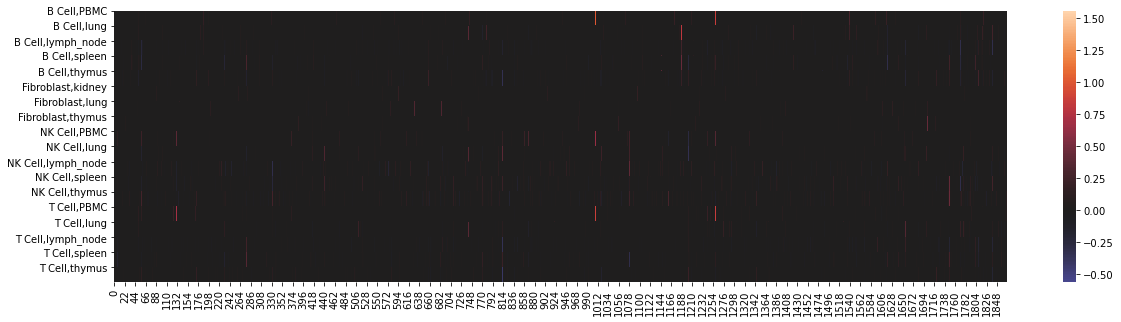

In [49]:
cp = Checkpoint(dirname='checkpoints/non-sequential_l1')
best_l1_net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=200,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.001) #

best_l1_pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', best_l1_net),
    ])
best_l1_pipe.fit(X_train, y_train)
best_l1_pipe['net'].initialize()
best_l1_pipe['net'].load_params(checkpoint=cp)
eval_model(best_l1_pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(best_l1_net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(best_l1_net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(best_l1_net), le)

In [112]:
dump(best_l1_pipe, 'best_l1.joblib')

['best_l1.joblib']

In [47]:
best_l1_pipe = load('best_l1.joblib') 

In [48]:
weights = best_l1_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
best_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
best_l1_result_df

/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


B Cell,PBMC B Cell,lung B Cell,lymph_node B Cell,spleen  B Cell,thymus  \
0        ORAI2    HLA-DRB5           HLA-DMB          HES4            NaN   
1       IFNGR2    SERPINB9         LINC00926        HSPA1B            NaN   
2      FAM107B      JCHAIN             RBM38           NaN            NaN   
3     MIR155HG      ZBTB20               NaN           NaN            NaN   
4         LSM7         NaN               NaN           NaN            NaN   
5        CMSS1         NaN               NaN           NaN            NaN   
6        EVI2B         NaN               NaN           NaN            NaN   
7      ZFP36L1         NaN               NaN           NaN            NaN   
8        FNBP1         NaN               NaN           NaN            NaN   
9          NaN         NaN               NaN           NaN            NaN   
10         NaN         NaN               NaN           NaN            NaN   
11         NaN         NaN               NaN           NaN            NaN   
12         NaN         NaN               NaN           NaN            NaN   
13         NaN         NaN               NaN           NaN            NaN   
14         NaN         NaN               NaN           NaN            NaN   
15         NaN         NaN               NaN           NaN            NaN   
16         NaN         NaN               NaN           NaN            NaN   
17         NaN         NaN               NaN           NaN            NaN   
18         NaN         NaN               NaN           NaN            NaN   
19         NaN         NaN               NaN           NaN            NaN   

   Fibroblast,kidney Fibroblast,lung Fibroblast,thymus NK Cell,PBMC  \
0              PALLD            EMP1            RNASE1         LAT2   
1             ADAM12           TIMP1             NDRG2        RSAD2   
2             PCOLCE              C3              TPM2         GNG2   
3              ITGA1            CNN3            COL6A1       CHST12   
4                DST             FN1             HTRA1       HAVCR2   
5               NRP1            MT1X              CD14        IFIT3   
6             CYP1B1            CTTN          SERPINF1        LIMD2   
7              IL6ST            UAP1               GSN        HLA-B   
8            EMILIN1          CYBRD1              CD36          NaN   
9               NID1            UGDH             PLPP3          NaN   
10           GUCY1A1          TCEAL9              GPX3          NaN   
11              PSD3             CLU              RRAS          NaN   
12              SPP1              F3             PLIN2          NaN   
13             LAMB1           CALD1              CAV1          NaN   
14           COL18A1            MT1E            CDKN1C          NaN   
15            PRXL2A            NBL1            IGFBP7          NaN   
16             SYNE2            DDR2            COL1A1          NaN   
17              VCAN             NaN               NaN          NaN   
18             THBS1             NaN               NaN          NaN   
19             APOL1             NaN               NaN          NaN   

   NK Cell,lung NK Cell,lymph_node NK Cell,spleen NK Cell,thymus T Cell,PBMC  \
0         NOL4L            SERTAD1            NCL          IFI27    LEPROTL1   
1          PSAP             TOMM40         CEMIP2          KLRC1         LAT   
2           LYZ             LZTFL1         PLAAT4          DUSP2        RORA   
3         PLAC8               TCP1         PIK3R1         LGALS3       BIRC2   
4       PIP4K2A              SNX22         METRNL        PTPRCAP        CREM   
5         PTGDS              PLIN3            NaN            NaN     PPP2R5C   
6        B3GNT7               AQP3            NaN            NaN      GIMAP5   
7           NaN                PGP            NaN            NaN         NaN   
8           NaN               TESC            NaN            NaN         NaN   
9           NaN             NDUFV1            NaN            NaN         NaN   
10          N

In [105]:
# De enrichment:
weights = best_l1_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
_, exclusive_scores = get_exclusive_model_weights_for_gsea(weights, le.classes_, feature_symbols, verbose=False)
len(exclusive_scores)
enrich_folder = Path("paper_figs") / "best_l1_enrich"
enrich_folder.mkdir(exist_ok=True)
for label, score_df in exclusive_scores.items():
    print(label)
    print(score_df.shape)
    save_file = enrich_folder / f"best_l1_{label}_GO_enrich.tex"
    do_enrich(score_df['symbol'].tolist(), score_df['weight'], all_genes_info['symbol'], save_file)

B Cell,PBMC
(9, 2)
0.24774957
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.


/home/amir/miniconda3/envs/hubmap/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


NONE SIGNIFICANT
B Cell,lung
(4, 2)
0.24783388
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,lymph_node
(3, 2)
0.07653655
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,spleen
(2, 2)
0.2491928
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,thymus
(0, 2)
nan
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
Fibroblast,kidney
(20, 2)
0.28415126
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
                                                   

### Extra penalty long training

  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9215             0.9513          0.7779        1.8971           0.0000           1.0082       0.7788        1.5852     +  1.6780
      2    0.9273             0.9518          0.7820        1.4509           0.0000           0.7321       0.7828        1.4949     +  1.6491
      3    0.9233             0.9484          0.7685        1.4045           0.0000           0.6999       0.7680        1.4806     +  1.6811
      4    0.9238             0.9474          0.7746        1.3867           0.0000           0.6966       0.7694        1.4661     +  1.7015
      5    0.9238             0.9456          0.7719        1.3765           0.0000           0.6855       0.7658        1.4655     +  1.8203
      

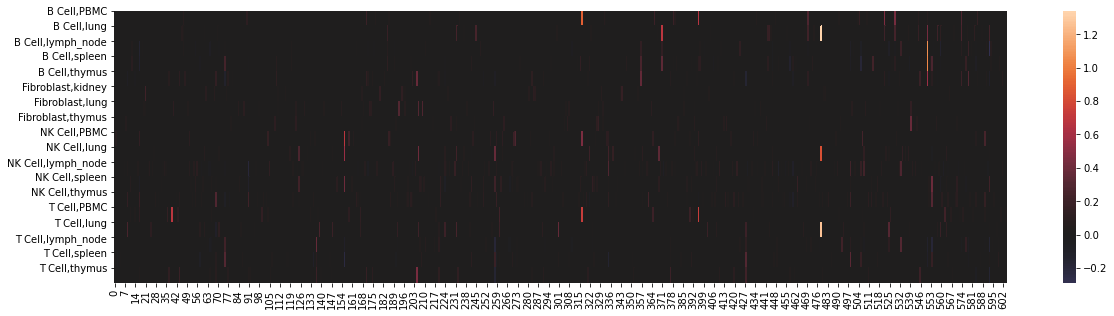

In [58]:
cp = Checkpoint(dirname='checkpoints/non-sequential_l1')
extra_pen_l1_net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=200,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.005) #

extra_pen_l1_pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', extra_pen_l1_net),
    ])
extra_pen_l1_pipe.fit(X_train, y_train)
extra_pen_l1_pipe['net'].initialize()
extra_pen_l1_pipe['net'].load_params(checkpoint=cp)
eval_model(extra_pen_l1_pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(extra_pen_l1_net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(extra_pen_l1_net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(extra_pen_l1_net), le)

In [113]:
dump(extra_pen_l1_pipe, 'extra_pen_l1.joblib')

['extra_pen_l1.joblib']

In [49]:
extra_pen_l1_pipe = load('extra_pen_l1.joblib') 

In [50]:
weights = extra_pen_l1_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
extra_pen_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
extra_pen_l1_result_df

B Cell,PBMC B Cell,lung B Cell,lymph_node B Cell,spleen B Cell,thymus  \
0         ACP5    SERPINB9            PDLIM1         BANK1        TUBA1B   
1         NRP2      ZBTB20           HLA-DMB         RPL15    ATP2B1-AS1   
2        ORAI2        ND4L             RBM38          HES4         PRDX1   
3       SQSTM1     CARMIL1            UBALD2         H2AC6          CD82   
4       IFNGR2        INSR             OTUD1        HSPA1B        IFI44L   
5     MIR155HG      JCHAIN             SNHG7           NaN           NaN   
6         CCR7   LINC01781         LINC00926           NaN           NaN   
7        SESN3         NaN               NaN           NaN           NaN   
8       GPR183         NaN               NaN           NaN           NaN   
9        EVI2B         NaN               NaN           NaN           NaN   
10         NaN         NaN               NaN           NaN           NaN   
11         NaN         NaN               NaN           NaN           NaN   
12         NaN         NaN               NaN           NaN           NaN   
13         NaN         NaN               NaN           NaN           NaN   
14         NaN         NaN               NaN           NaN           NaN   
15         NaN         NaN               NaN           NaN           NaN   
16         NaN         NaN               NaN           NaN           NaN   
17         NaN         NaN               NaN           NaN           NaN   
18         NaN         NaN               NaN           NaN           NaN   
19         NaN         NaN               NaN           NaN           NaN   

   Fibroblast,kidney Fibroblast,lung Fibroblast,thymus NK Cell,PBMC  \
0              PALLD            EMP1            RNASE1        RAMP1   
1             ADAM12           TIMP1             NDRG2         LAT2   
2              ITGA1              C3              TPM2        RSAD2   
3                DST            CNN3            COL6A1         GNG2   
4               NRP1            CST3             MGST1         FEZ1   
5             CYP1B1          COL6A2             HTRA1       CHST12   
6             FRMD4A             FN1              CD14       HAVCR2   
7            EMILIN1            MT1X               GSN        IFIT3   
8               NID1            CTTN               OAF        LIMD2   
9            GUCY1A1          CYBRD1              CD36        TGFB1   
10              PSD3            UGDH             PLPP3        IFIT2   
11            SLC8A1          TCEAL9              GPX3          NaN   
12             PTGR1             CLU              EGR1          NaN   
13              SPP1              F3             PLIN2          NaN   
14             LAMB1           CALD1              CAV1          NaN   
15           COL18A1            NBL1               NaN          NaN   
16            PRXL2A             NaN               NaN          NaN   
17              VCAN             NaN               NaN          NaN   
18             THBS1             NaN               NaN          NaN   
19             APOL1             NaN               NaN          NaN   

   NK Cell,lung NK Cell,lymph_node NK Cell,spleen NK Cell,thymus T Cell,PBMC  \
0         NOL4L            SERTAD1            NCL          IFI27      ATP1A1   
1        AKR1C3               HOPX         DYNLL1          DUSP2    LEPROTL1   
2          PSAP             H2BC12         CEMIP2          NR4A1         LAT   
3           LYZ             TOMM40         PIK3R1         TUBB4B        RORA   
4       PIP4K2A             LZTFL1         METRNL        PTPRCAP        MIAT   
5         PTGDS               TCP1            NaN            NaN     PPP2R5C   
6        B3GNT7              PLIN3            NaN            NaN      PABPC1   
7           NaN               NQO2            NaN            NaN      GIMAP5   
8           NaN               TESC            NaN            NaN         nan   
9           NaN           SEPTIN11            NaN            NaN     S100A11   
10          NaN               LYAR

In [106]:
# De enrichment:
weights = extra_pen_l1_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
_, exclusive_scores = get_exclusive_model_weights_for_gsea(weights, le.classes_, feature_symbols, verbose=False)
len(exclusive_scores)
enrich_folder = Path("paper_figs") / "extra_pen_l1_enrich"
enrich_folder.mkdir(exist_ok=True)
for label, score_df in exclusive_scores.items():
    print(label)
    print(score_df.shape)
    save_file = enrich_folder / f"extra_pen_l1_{label}_GO_enrich.tex"
    do_enrich(score_df['symbol'].tolist(), score_df['weight'], all_genes_info['symbol'], save_file)

B Cell,PBMC
(10, 2)
0.20074807
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,lung
(7, 2)
0.24471396
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
                                                set      pval      qval  \
4937  GOBP_POSITIVE_REGULATION_OF_RESPIRATORY_BURST  0.000003  0.022832   

      intersection  reference  enquiry  background  
4937             2          5        7       11646  
B Cell,lymph_node
(7, 2)
0.0843629
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,spleen
(5, 2)
0.22787882
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT


## Non-sequential classifier w/Exclusive L1

In [ ]:
cp = Checkpoint(dirname='checkpoints/non-sequential_exclusive_l1')
net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='exclusive_l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=100,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.5) #

pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])
pipe.fit(X_train, y_train)
pipe['net'].initialize()
pipe['net'].load_params(checkpoint=cp)
eval_model(pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(net), le)

In [ ]:
weights = pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
non_sequential_exclusive_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
non_sequential_exclusive_l1_result_df

In [ ]:
generate_model_gene_module_reports(adata_subset, non_sequential_exclusive_l1_result_df, "Non-sequential, Exclusive L1 penalty", "model_gene_module_reports/non_sequential_exclusive_l1_penalty/")

### Quick gridsearch

In [42]:
shared_grid = {
    'net__max_epochs': [10, 20, 100],
    'net__lr': [0.01, 0.001],
    'net__optimizer': [torch.optim.Adam],
    'net__callbacks__lr_scheduler__factor': [0.5]
}
param_grid = copy.deepcopy(shared_grid)
param_grid['net__lambda_clf'] = [0.]
param_grid['net__regularization'] = ['exclusive_l1']
param_grid['net__lambda_reg'] = [0., 0.001, 0.01, 0.1]

net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                               ],
                                     secondary_criterion_weight=celltype_class_weights)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])

gs_ex = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=2, n_jobs=-1)

gs_ex.fit(X_train, y_train)
dump(gs_ex, 'quick_gridsearch_exl1.joblib')

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 31.9min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.8966             0.9383          0.7715        1.7600           0.0000           0.9548       0.7659        1.5464  1.8867
      2    0.9253             0.9505          0.7791        1.3133           0.0000           0.6394       0.7861        1.4366  1.8359
      3    0.9259             0.9501          0.7739        1.2627           0.0000           0.6157       0.7840        1.4166  1.9284
      4    0.9297             0.9514          0.7718        1.2479           0.0000           0.6064       0.7857        1.4025  1.9410
      5    0.9286             0.9498          0.7708        1.2395           0.0000           0.5992       0.7871        1.3924  1.8935
      6    0.9294             0.9492          0.

['quick_gridsearch_exl1.joblib']

{'net__callbacks__lr_scheduler__factor': 0.5, 'net__lambda_clf': 0.0, 'net__lambda_reg': 0.1, 'net__lr': 0.001, 'net__max_epochs': 10, 'net__optimizer': <class 'torch.optim.adam.Adam'>, 'net__regularization': 'exclusive_l1'}
train acc:         0.7994580809690788
test acc:          0.7822192470753243
test balanced acc: 0.7695622404304376
classification report:
                    precision    recall  f1-score   support

       B Cell,PBMC       0.89      0.99      0.94       210
       B Cell,lung       0.90      0.95      0.93      1635
 B Cell,lymph_node       0.70      0.58      0.64      3321
     B Cell,spleen       0.77      0.75      0.76      4085
     B Cell,thymus       0.41      0.50      0.45      1204
 Fibroblast,kidney       0.86      0.86      0.86        29
   Fibroblast,lung       0.98      0.97      0.98       546
 Fibroblast,thymus       0.89      0.97      0.93       111
      NK Cell,PBMC       0.71      0.95      0.81       720
      NK Cell,lung       0.88      0.

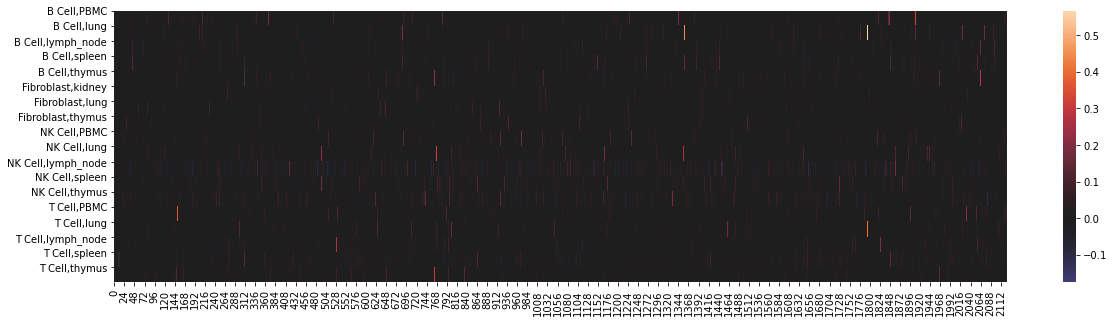

In [43]:
print(gs_ex.best_params_)
eval_model(gs_ex.best_estimator_, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(gs_ex.best_estimator_['net'], np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(gs_ex.best_estimator_['net'], np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(gs_ex.best_estimator_['net']), le)

In [44]:
weights = gs_ex.best_estimator_['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
gs_exclusive_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
gs_exclusive_l1_result_df

B Cell,PBMC B Cell,lung B Cell,lymph_node B Cell,spleen B Cell,thymus  \
0        FNBP1        ND4L             OTUD1         HSPD1         PRDX1   
1        CMSS1    SERPINB9              FCMR          SPIB       SERTAD1   
2       IFNGR2      JCHAIN            POU2F2        HSPA1B        IFI44L   
3         ACP5      ZBTB20            UBALD2          CD55       RETREG1   
4      FAM107B   LINC01781             DERL3          GNG7          CD82   
5       GPR183       IFI30             SNHG7          HES4        TUBA1B   
6        MEF2C    HLA-DRB5             RBM38           NaN    ATP2B1-AS1   
7         LSM7     MARCHF1            SWAP70           NaN           NaN   
8        EVI2B        IRF8         LINC00926           NaN           NaN   
9        TCEA1         nan               NaN           NaN           NaN   
10       ORAI2     CARMIL1               NaN           NaN           NaN   
11        CCR7         NaN               NaN           NaN           NaN   
12     ZFP36L1         NaN               NaN           NaN           NaN   
13        ELK3         NaN               NaN           NaN           NaN   
14       SESN3         NaN               NaN           NaN           NaN   
15       CHPT1         NaN               NaN           NaN           NaN   
16         NaN         NaN               NaN           NaN           NaN   
17         NaN         NaN               NaN           NaN           NaN   
18         NaN         NaN               NaN           NaN           NaN   
19         NaN         NaN               NaN           NaN           NaN   

   Fibroblast,kidney Fibroblast,lung Fibroblast,thymus NK Cell,PBMC  \
0              THBS1          CYBRD1              CYGB         GNG2   
1               ACO1       MIR4458HG            COL6A1       HAVCR2   
2              PALLD            UAP1             NDRG2        SLFN5   
3              ITGA1            MT1X               GSN        IFIT3   
4               NRP1             CLU          CDC42EP4        RSAD2   
5              SYNE2          AKAP12              CAV1        LASP1   
6           CCDC102B           TIMP1             MGST1        UBE2F   
7            GUCY1A1              F3              HBA1        LIMD2   
8             PRXL2A            MT1E             PLPP3        PRMT2   
9            COL18A1           FSTL3            COL1A1       CHST12   
10               DST            NBL1               CFD        RAMP1   
11             APOL1            EMP1             PLIN2        TGFB1   
12             LAMB1           TIMP2              GPX3      C1orf21   
13              DDR2            CNN3              TPM2         FEZ1   
14            CYP1B1            FHL1             SPARC        WIPF1   
15              VCAN          TCEAL9            RNASE1        TNIP1   
16           EMILIN1           CALD1              CD36          NaN   
17            ADAM12            CTTN          SERPINF1          NaN   
18              NID1              C3             HTRA1          NaN   
19              SPP1             NaN               NaN          NaN   

   NK Cell,lung NK Cell,lymph_node NK Cell,spleen NK Cell,thymus T Cell,PBMC  \
0         PLAC8             TOMM40          NEAT1            VIM        MIAT   
1      CDC42SE1              ITGAX          KLRG1           RGS2       EVI2A   
2        AKR1C3             TSPAN3         PIK3R1          IFI27       CAMK4   
3       PIP4K2A             NDUFV1         CEMIP2         TENT5C       ADTRP   
4         SPON2             ORMDL2            NCL           LYAR         LAT   
5         SERF2               ECE1         PTPN12          NR4A1      ATP1A1   
6        IGFBP7             H2BC12         METRNL         LGALS3        RPL9   
7          PSAP               NQO2            NaN          IFIT2    CDC42SE2   
8         NOL4L              DNAI7            NaN           RGCC     PPP2R5C   
9          HOPX                PGP            NaN        SPATS2L       CYTOR   
10         MT2A               TCP1

### Best settings long training

  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9130             0.9461          0.7781        1.7637           0.0000           0.9587       0.7783        1.5224     +  2.1700
      2    0.9269             0.9506          0.7707        1.3093           0.0000           0.6373       0.7871        1.4164     +  2.1431
      3    0.9246             0.9494          0.7734        1.2577           0.0000           0.6148       0.7850        1.4090     +  2.4208
      4    0.9281             0.9498          0.7695        1.2455           0.0000           0.6041       0.7875        1.4102        2.6104
      5    0.9294             0.9497          0.7719        1.2372           0.0000           0.5999       0.7853        1.4104        2.5653
      

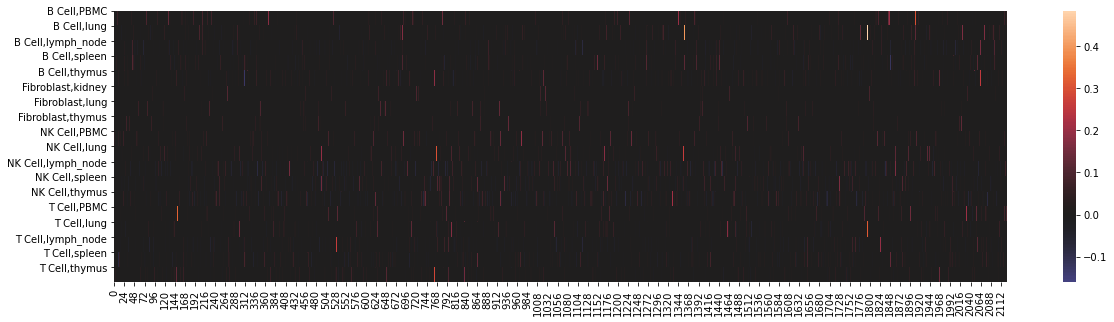

In [46]:
cp = Checkpoint(dirname='checkpoints/non-sequential_exclusive_l1')
best_ex_net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='exclusive_l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=200,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.1) #

best_ex_pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', best_ex_net),
    ])
best_ex_pipe.fit(X_train, y_train)
best_ex_pipe['net'].initialize()
best_ex_pipe['net'].load_params(checkpoint=cp)
eval_model(best_ex_pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(best_ex_net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(best_ex_net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(best_ex_net), le)

In [110]:
dump(best_ex_pipe, 'best_exl1.joblib')

['best_exl1.joblib']

In [51]:
best_ex_pipe = load('best_exl1.joblib') 

In [52]:
weights = best_ex_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
best_exclusive_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
best_exclusive_l1_result_df

B Cell,PBMC B Cell,lung B Cell,lymph_node B Cell,spleen B Cell,thymus  \
0         ACP5    HLA-DRB5            POU2F2          SPIB        TUBA1B   
1        ORAI2    SERPINB9             MEF2C         HSPD1          NEK6   
2       SQSTM1       IFI30              TCF4       TAMALIN        HIVEP3   
3       IFNGR2     MARCHF1             RBM38          HES4    ATP2B1-AS1   
4      FAM107B      ZBTB20            UBALD2         H2AC6         PRDX1   
5     MIR155HG        ND4L              FCMR        HSPA1B          CD82   
6         CCR7     CARMIL1             OTUD1          CD55        IFI44L   
7        SESN3        IRF8             SNHG7           NaN           NaN   
8         LSM7      JCHAIN         LINC00926           NaN           NaN   
9        TCEA1   LINC01781            SWAP70           NaN           NaN   
10       CHPT1         NaN               NaN           NaN           NaN   
11        ELK3         NaN               NaN           NaN           NaN   
12      GPR183         NaN               NaN           NaN           NaN   
13       EVI2B         NaN               NaN           NaN           NaN   
14     ZFP36L1         NaN               NaN           NaN           NaN   
15       FNBP1         NaN               NaN           NaN           NaN   
16         NaN         NaN               NaN           NaN           NaN   
17         NaN         NaN               NaN           NaN           NaN   
18         NaN         NaN               NaN           NaN           NaN   
19         NaN         NaN               NaN           NaN           NaN   

   Fibroblast,kidney Fibroblast,lung Fibroblast,thymus NK Cell,PBMC  \
0              PALLD            EMP1             NDRG2        RAMP1   
1             ADAM12           TIMP1             HTRA1        GCHFR   
2              ITGA1          TCEAL9              CD14        RSAD2   
3                DST             CLU            IGFBP4         GNG2   
4               NRP1        SERPING1               CFD        SLFN5   
5             CYP1B1            CNN3             MGST1         FEZ1   
6             FRMD4A          AKAP12               GSN        LASP1   
7            EMILIN1           TIMP2             SPARC        IFIT3   
8               NID1            UAP1              TPM2       CHST12   
9            GUCY1A1          CYBRD1            COL6A1       HAVCR2   
10              PSD3              F3               OAF        LIMD2   
11              SPP1            MT1E              CAV1        WIPF1   
12          CCDC102B            NBL1            COL1A1        TGFB1   
13             LAMB1            DDR2            RNASE1      C1orf21   
14           COL18A1              C3              HBA1        UBE2F   
15            PRXL2A            MT1X          SERPINF1        PRMT2   
16              VCAN            CTTN            FAM20C        TNIP1   
17             THBS1            UGDH              GPX3          NaN   
18             APOL1           CALD1              CD36          NaN   
19              ACO1            CST3             PLPP3          NaN   

   NK Cell,lung NK Cell,lymph_node NK Cell,spleen NK Cell,thymus T Cell,PBMC  \
0          HOPX             H2BC12            NCL          IFI27    LEPROTL1   
1         NOL4L             TOMM40          KLRG1          BCAS2      PABPC1   
2         SERF2             LZTFL1          NEAT1          DUSP2       ZNF90   
3        AKR1C3               TCP1         DNAJC1           RGS2    CDC42SE2   
4      CDC42SE1             ERLEC1          APMAP         TUBB4B        RORA   
5          PSAP              PLIN3         PIK3R1          IFIT2       BIRC2   
6          MT2A              ACAA2         CEMIP2        SPATS2L     PPP2R5C   
7         PLAC8               FLNB            FYN         LGALS3       ADTRP   
8       PIP4K2A               ADAR         METRNL          NR4A1        MIAT   
9         PTGDS               NQO2            NaN           RGCC      GIMAP5   
10       B3GNT7                PGP

In [103]:
# De enrichment:
weights = best_ex_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
_, exclusive_scores = get_exclusive_model_weights_for_gsea(weights, le.classes_, feature_symbols, verbose=False)
len(exclusive_scores)
enrich_folder = Path("paper_figs") / "extra_pen_exl1_enrich"
enrich_folder.mkdir(exist_ok=True)
for label, score_df in exclusive_scores.items():
    print(label)
    print(score_df.shape)
    save_file = enrich_folder / f"best_ex_{label}_GO_enrich.tex"
    do_enrich(score_df['symbol'].tolist(), score_df['weight'], all_genes_info['symbol'], save_file)

B Cell,PBMC
(16, 2)
0.1995198
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,lung
(10, 2)
0.19565041
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,lymph_node
(10, 2)
0.10291451
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,spleen
(7, 2)
0.21171467
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,thymus
(7, 2)
0.16114938
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
Fibroblast,kidney
(20, 2)
0.16413306
INFO:diffxp

### Extra penalty long training

  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9132             0.9443          0.7014        2.6901           0.0000           1.5256       0.7129        2.4668     +  4.4509
      2    0.9163             0.9431          0.7048        2.4105           0.0000           1.3124       0.7078        2.5050        4.0092
      3    0.9154             0.9399          0.7100        2.3992           0.0000           1.2785       0.7034        2.4768        4.5843
      4    0.9229             0.9441          0.6985        2.3925           0.0000           1.2667       0.7116        2.4399     +  4.6898
      5    0.9183             0.9396          0.7026        2.3848           0.0000           1.2562       0.7065        2.4671        4.8137
      

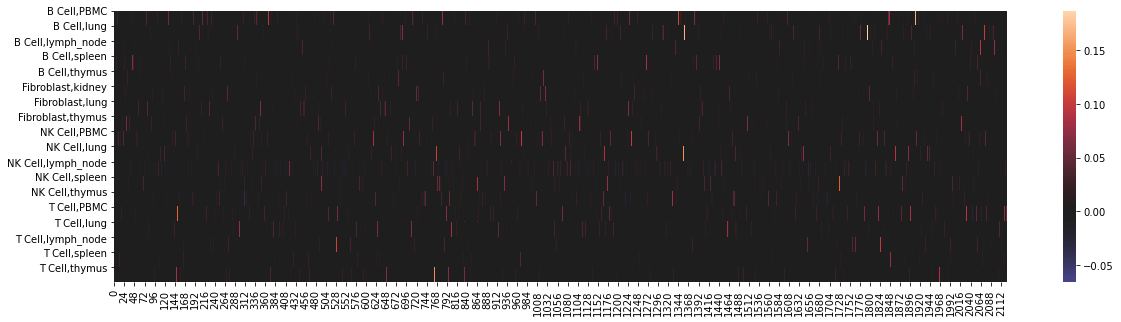

In [56]:
cp = Checkpoint(dirname='checkpoints/non-sequential_exclusive_l1')
extra_pen_ex_net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='exclusive_l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=200,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.5) #

extra_pen_ex_pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', extra_pen_ex_net),
    ])
extra_pen_ex_pipe.fit(X_train, y_train)
extra_pen_ex_pipe['net'].initialize()
extra_pen_ex_pipe['net'].load_params(checkpoint=cp)
eval_model(extra_pen_ex_pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(extra_pen_ex_net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(extra_pen_ex_net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(extra_pen_ex_net), le)

In [111]:
dump(extra_pen_ex_pipe, 'extra_pen_exl1.joblib')

['extra_pen_exl1.joblib']

In [53]:
extra_pen_ex_pipe = load('extra_pen_exl1.joblib') 

In [54]:
weights = extra_pen_ex_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
extra_pen_exclusive_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
extra_pen_exclusive_l1_result_df

B Cell,PBMC B Cell,lung B Cell,lymph_node B Cell,spleen B Cell,thymus  \
0       FKBP1A      TXNDC5           HLA-DMB          GNG7        TUBA1B   
1        EVI2B        INSR             RBM38         BANK1          NEK6   
2     HLA-DRB1    HLA-DQB1            UBALD2        FCGR2B       HLA-DOA   
3       SQSTM1       DERL3         LINC00926       UNC93B1          TCF4   
4     MIR155HG     MARCHF1            MAP4K4          HES4          LMO2   
5         CCR7        MZB1             PDE4B        HSPA1B           MX1   
6      ZFP36L1        ND4L              RHOH       RPL22L1         HSPB1   
7         ACP5   TNFRSF13C              H1-4           SYK         PRDX1   
8        ORAI2        IRF8             SNHG7        PDLIM1          MBD2   
9        BIRC3        EBF1             BEST1         HSPD1         ASAP1   
10       SESN3      BCL11A           HLA-DRA       TAMALIN        MMACHC   
11         ID3      ZBTB20            POU2F2          CD22         PRMT1   
12      GPR183       RPS17           TSPAN13         PARP1       RHOBTB2   
13        LSM7      JCHAIN             OTUD1         H2AC6    ATP2B1-AS1   
14      CYSTM1   LINC01781              USF2          CD55         RGS19   
15      IFNGR2    HLA-DRB5              NCF1          SPIB      RNASEH2B   
16     FAM107B    SERPINB9           LDLRAD4          CTSZ         MS4A1   
17    HLA-DQA1       IFI30            ADAM19      DNASE1L3          CD82   
18        CD58       DRAM2            SWAP70           MYC        IFI44L   
19         NaN    HLA-DPB1               NaN           NaN           NaN   

   Fibroblast,kidney Fibroblast,lung Fibroblast,thymus NK Cell,PBMC  \
0              PALLD           TIMP1             HTRA1        SLFN5   
1             ADAM12            EMP1              CD14         FEZ1   
2              ITGA1          PCOLCE               CFD         ZEB2   
3               TPM1          TCEAL9             MGST1        UBE2F   
4                DST             CLU               GSN        RAMP1   
5               NRP1        SERPING1             PLIN2        KLRC1   
6             CYP1B1            CNN3             SPARC        LASP1   
7            EMILIN1          AKAP12              TPM2        IFIT3   
8               NID1             CFH            COL6A1        WIPF1   
9            GUCY1A1          IFITM3              PLTP        TGFB1   
10              SPP1           TIMP2              CAV1        GCHFR   
11             LAMB1          CYBRD1            COL1A1       CHST12   
12           COL18A1              F3            RNASE1       HAVCR2   
13            PRXL2A            MT1E            FAM20C        HLA-B   
14             SYNE2            NBL1            COL6A2        MYO1F   
15             INHBA              C3              GPX3          ADA   
16              VCAN            MT1X              CD36         GNG2   
17             THBS1            CTTN             PLPP3        LIMD2   
18             APOL1           CALD1              RBP7      C1orf21   
19              ACO1            CST3              EGR1     APOBEC3G   

   NK Cell,lung NK Cell,lymph_node NK Cell,spleen NK Cell,thymus T Cell,PBMC  \
0          HOPX            SERTAD1          KLRG1          NR4A1    LEPROTL1   
1         SPON2              SPRY1          HSPH1          PPM1N      PABPC1   
2         NOL4L             ARPC5L         PTGER2          PTTG1         nan   
3         SERF2             CFAP45            FYN           IER3       ZNF90   
4        AKR1C3               SMOX          CEBPD        CDK2AP2         VIM   
5      CDC42SE1             LZTFL1           IRF1          UBE2S    CDC42SE2   
6         KLRD1              PLIN3          NEAT1        GADD45B   HNRNPA1L2   
7          GNLY              ACAA2         PIK3R1           H2AX        RORA   
8          MT2A               CD63           HBA2         CSRNP1       ADTRP   
9          CMC1           SEPTIN11         S100A9           RGS2     PPP2R5C   
10        PLAC8              ITGAX

In [104]:
# De enrichment:
weights = extra_pen_ex_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
_, exclusive_scores = get_exclusive_model_weights_for_gsea(weights, le.classes_, feature_symbols, verbose=False)
len(exclusive_scores)
enrich_folder = Path("paper_figs") / "extra_pen_exl1_enrich"
enrich_folder.mkdir(exist_ok=True)
for label, score_df in exclusive_scores.items():
    print(label)
    print(score_df.shape)
    save_file = enrich_folder / f"extra_pen_ex_{label}_GO_enrich.tex"
    do_enrich(score_df['symbol'].tolist(), score_df['weight'], all_genes_info['symbol'], save_file)

B Cell,PBMC
(19, 2)
0.16784331
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
                                                    set      pval      qval  \
382              GOBP_MYELOID_LEUKOCYTE_DIFFERENTIATION  0.000002  0.011688   
403            GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS  0.000004  0.015558   
2850                          GOBP_RESPONSE_TO_CYTOKINE  0.000012  0.028294   
1076           GOBP_I_KAPPAB_KINASE_NF_KAPPAB_SIGNALING  0.000020  0.034408   
447   GOBP_POSITIVE_REGULATION_OF_MYELOID_LEUKOCYTE_...  0.000023  0.034408   

      intersection  reference  enquiry  background  
382              5        129       19       11646  
403              9        898       19       11646  
2850             8        751       19       11646  
1076             5        216       19       11646  
447              3         35       19       11646  
B Cell,lung
(20, 2)
0.1872607
INFO:

### Build dataframe of results

train acc:         0.8024120709807672
test acc:          0.7855344107615313
test balanced acc: 0.75766956869833
classification report:
                    precision    recall  f1-score   support

       B Cell,PBMC       0.90      0.99      0.94       210
       B Cell,lung       0.90      0.96      0.93      1635
 B Cell,lymph_node       0.68      0.61      0.64      3321
     B Cell,spleen       0.78      0.71      0.75      4085
     B Cell,thymus       0.41      0.48      0.44      1204
 Fibroblast,kidney       0.93      0.86      0.89        29
   Fibroblast,lung       0.99      0.98      0.98       546
 Fibroblast,thymus       0.92      0.93      0.92       111
      NK Cell,PBMC       0.72      0.94      0.81       720
      NK Cell,lung       0.87      0.91      0.89      1764
NK Cell,lymph_node       0.05      0.15      0.07        34
    NK Cell,spleen       0.57      0.74      0.65       656
    NK Cell,thymus       0.16      0.56      0.24       133
       T Cell,PBMC      

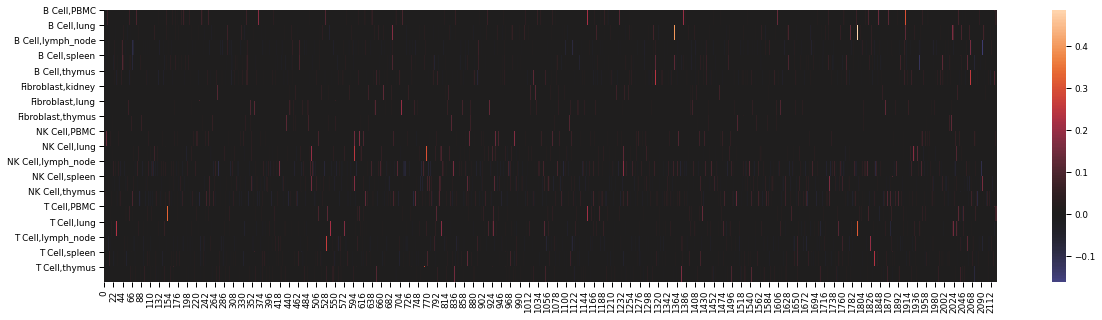

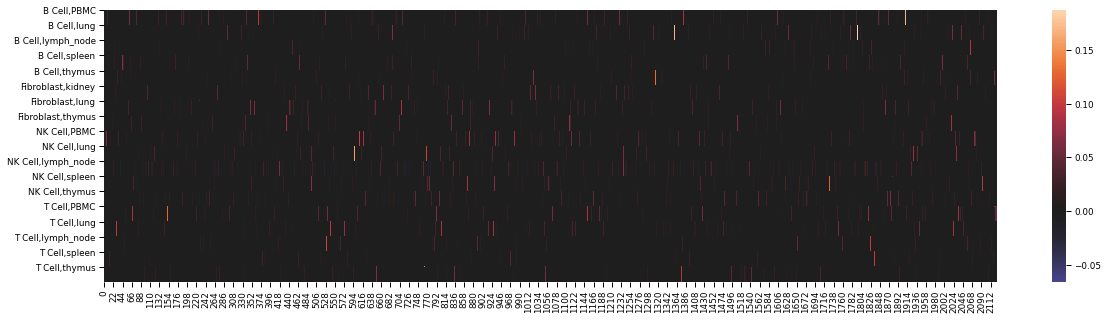

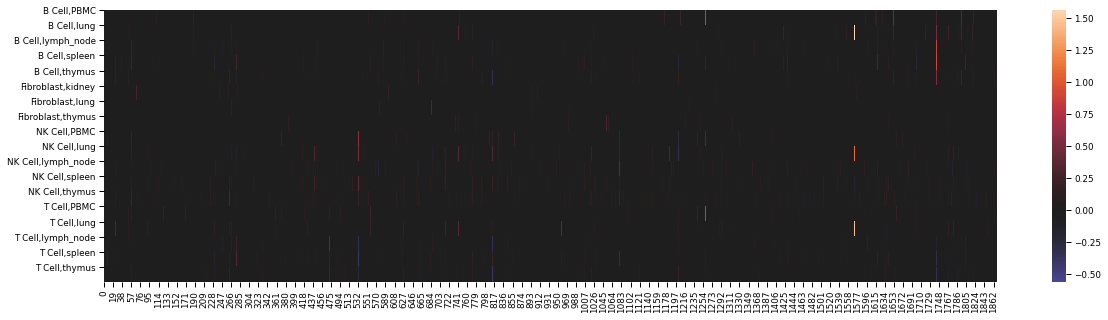

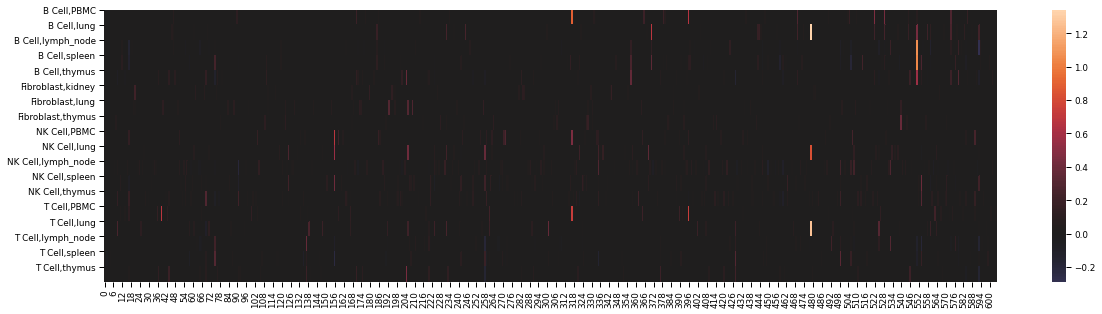

In [56]:
res_df = {
    'Regularization': ['Exclusive L1','Exclusive L1', 'L1', 'L1'],
    'Fit':['Best','Stronger penalty', 'Best','Stronger penalty'],
    'Test accuracy': [eval_model(best_ex_pipe, X_train, y_train, X_test, y_test, le),
                      eval_model(extra_pen_ex_pipe, X_train, y_train, X_test, y_test, le),
                      eval_model(best_l1_pipe, X_train, y_train, X_test, y_test, le),
                      eval_model(extra_pen_l1_pipe, X_train, y_train, X_test, y_test, le),
                     ],
    'Sparsity': [check_sparsity(SkorchLRAdapter(best_ex_pipe['net']), le),
                 check_sparsity(SkorchLRAdapter(extra_pen_ex_pipe['net']), le),
                 check_sparsity(SkorchLRAdapter(best_l1_pipe['net']), le),
                 check_sparsity(SkorchLRAdapter(extra_pen_l1_pipe['net']), le)
                ],
}
res_df = pd.DataFrame(res_df)
print(res_df)

In [57]:
palette = sns.color_palette("Blues")[2:4]

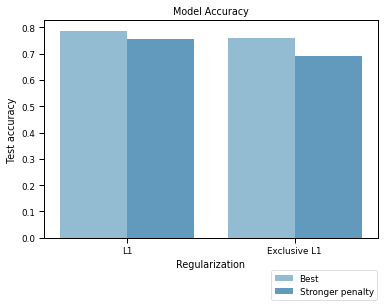

In [58]:
ax = sns.barplot(x="Regularization", y="Test accuracy", hue="Fit", data=res_df, order=['L1', 'Exclusive L1'], hue_order=['Best', 'Stronger penalty'], palette=palette)
ax.set_title('Model Accuracy')
#ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.13))

fig_folder = Path("paper_figs")
fig_folder.mkdir(exist_ok=True)

filename = "hubmap_test_accuracy"
plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
plt.show()

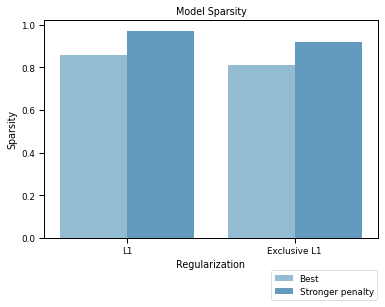

In [59]:
ax = sns.barplot(x="Regularization", y="Sparsity", hue="Fit", data=res_df, order=['L1', 'Exclusive L1'], hue_order=['Best', 'Stronger penalty'], palette=palette)
ax.set_title('Model Sparsity')
# ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.13))

fig_folder = Path("paper_figs")
fig_folder.mkdir(exist_ok=True)

filename = "hubmap_model_sparsity"
plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
plt.show()

In [60]:
# Marker yeilds
marker_df = pd.DataFrame.from_records([
best_l1_result_df.count().append(pd.Series({'Model': 'L1, Best'})),
extra_pen_l1_result_df.count().append(pd.Series({'Model': 'L1, Stronger penalty'})),
best_exclusive_l1_result_df.count().append(pd.Series({'Model': 'Exclusive L1, Best'})),
extra_pen_exclusive_l1_result_df.count().append(pd.Series({'Model': 'Exclusive L1, Stronger penalty'})),
])
print(marker_df.shape)
marker_df = pd.melt(marker_df, id_vars=['Model'], var_name = "Phenotype", value_name="Exclusive marker count")
print(marker_df)
marker_df['Phenotype'] = marker_df['Phenotype'].str.replace('_',' ')

(4, 19)
                             Model      Phenotype  Exclusive marker count
0                         L1, Best    B Cell,PBMC                       9
1             L1, Stronger penalty    B Cell,PBMC                      10
2               Exclusive L1, Best    B Cell,PBMC                      16
3   Exclusive L1, Stronger penalty    B Cell,PBMC                      19
4                         L1, Best    B Cell,lung                       4
..                             ...            ...                     ...
67  Exclusive L1, Stronger penalty  T Cell,spleen                      20
68                        L1, Best  T Cell,thymus                       2
69            L1, Stronger penalty  T Cell,thymus                       5
70              Exclusive L1, Best  T Cell,thymus                      10
71  Exclusive L1, Stronger penalty  T Cell,thymus                      20

[72 rows x 3 columns]


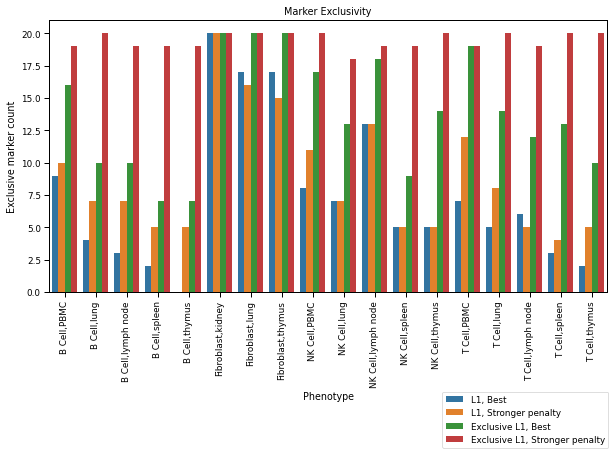

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="Phenotype",
                 y="Exclusive marker count",
                 hue="Model",
                 data=marker_df,
                 hue_order=['L1, Best', 'L1, Stronger penalty', 'Exclusive L1, Best', 'Exclusive L1, Stronger penalty'],
            ax=ax,
                 )
ax.set_title('Marker Exclusivity')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
# ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.35))

fig_folder = Path("paper_figs")
fig_folder.mkdir(exist_ok=True)

filename = "hubmap_marker_exclusivity"
plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
plt.show()

## Non-sequential celltype classifier w/Exclusive L1

In [ ]:
ct_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_ct), y=y_train_ct)
ct_class_weights = torch.from_numpy(ct_class_weights).float()

In [ ]:
cp = Checkpoint(dirname='checkpoints/non-sequential_ct_exclusive_l1')
ct_net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                        module__input_size=X_train.shape[1],
                                        module__output_size=len(le_ct.classes_),
                                        regularization='exclusive_l1',
                                        criterion__weight=ct_class_weights,
                                        max_epochs=200,
                                        optimizer=torch.optim.Adam,
                                        lr=0.001,
                                        iterator_train__shuffle=True,
                                        callbacks=[('balanced_acc', balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                        lambda_clf=0.,
                                        lambda_reg=0.5) #

ct_pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', ct_net),
    ])
ct_pipe.fit(X_train_ct, y_train_ct)
ct_pipe['net'].initialize()
ct_pipe['net'].load_params(checkpoint=cp)
eval_model(ct_pipe, X_train_ct, y_train_ct, X_test_ct, y_test_ct, le_ct)
print()
check_sparsity(SkorchLRAdapter(ct_net), le_ct)

In [ ]:
plt.hist(ct_pipe['net'].module_.linear.weight.detach().numpy().flatten())

In [ ]:
percentile_thresh = np.percentile(np.abs(ct_pipe['net'].module_.linear.weight.detach().numpy()), 90)

In [ ]:
ct_specific_features_idx = np.unique(np.where(ct_pipe['net'].module_.linear.weight.detach().numpy() > percentile_thresh)[1])

In [ ]:
print(len(ct_specific_features_idx))

## Non-sequential tissue classifier w/Exclusive L1

In [ ]:
tiss_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_tiss), y=y_train_tiss)
tiss_class_weights = torch.from_numpy(tiss_class_weights).float()

In [ ]:
cp = Checkpoint(dirname='checkpoints/non-sequential_tiss_exclusive_l1')
tiss_net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                          module__input_size=X_train_tiss.shape[1],
                                          module__output_size=len(le_tiss.classes_),
                                          regularization='exclusive_l1',
                                          criterion__weight=tiss_class_weights,
                                          max_epochs=200,
                                          optimizer=torch.optim.Adam,
                                          lr=0.001,
                                          iterator_train__shuffle=True,
                                          callbacks=[('balanced_acc', balanced_acc),
                                                     ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                                  factor=0.5, verbose=True)),
                                                     ('sparse_thresholder', SparseWeightsThresholder()),
                                                     ('checkpoint', cp),
                                                    ],
                                          lambda_clf=0.,
                                          lambda_reg=0.5) #

tiss_pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', tiss_net),
    ])
tiss_pipe.fit(X_train_tiss, y_train_tiss)
tiss_pipe['net'].initialize()
tiss_pipe['net'].load_params(checkpoint=cp)
eval_model(tiss_pipe, X_train_tiss, y_train_tiss, X_test_tiss, y_test_tiss, le_tiss)
print()
check_sparsity(SkorchLRAdapter(tiss_net), le_tiss)

In [ ]:
plt.hist(tiss_pipe['net'].module_.linear.weight.detach().numpy().flatten())

In [ ]:
percentile_thresh = np.percentile(np.abs(tiss_pipe['net'].module_.linear.weight.detach().numpy()), 90)

In [ ]:
tiss_specific_features_idx = np.unique(np.where(tiss_pipe['net'].module_.linear.weight.detach().numpy() > percentile_thresh)[1])

In [ ]:
len(tiss_specific_features_idx)

In [ ]:
ct_or_tiss_specific_featuers_idx = np.union1d(ct_specific_features_idx, tiss_specific_features_idx)

In [ ]:
len(ct_or_tiss_specific_featuers_idx)

## Non-sequential joint classifier w/features removed and w/Exclusive L1

In [ ]:
mask_array = np.zeros(adata_subset.shape[1], dtype=bool)
mask_array[ct_or_tiss_specific_featuers_idx] = True
mask_array.sum()

In [ ]:
adata_ct_tiss_genes_removed = adata_subset[:, mask_array]
print(adata_ct_tiss_genes_removed.shape)

In [ ]:
X_train_rm, X_test_rm = X_train[:, mask_array], X_test[:, mask_array]
print(X_train_rm.shape)

In [ ]:
cp = Checkpoint(dirname='checkpoints/non-sequential_ct_tiss_features_removed_exclusive_l1')
net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train_rm.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='exclusive_l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=100,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.5) #

pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])
pipe.fit(X_train_rm, y_train)
pipe['net'].initialize()
pipe['net'].load_params(checkpoint=cp)
eval_model(pipe, X_train_rm, y_train, X_test_rm, y_test, le)
test_ct_acc = ct_acc_score_fn(net, np.asarray(X_test_rm), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(net, np.asarray(X_test_rm), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(net), le)

In [ ]:
weights = pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_ct_tiss_genes_removed.var[['symbol']]
non_sequential_exclusive_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
non_sequential_exclusive_l1_result_df

In [ ]:
generate_model_gene_module_reports(adata_ct_tiss_genes_removed, non_sequential_exclusive_l1_result_df, "CT/Tiss-specific removed, Non-sequential, Exclusive L1 penalty", "model_gene_module_reports/ct_tiss_rm_non_sequential_exclusive_l1_penalty/")

## Sequential classifier (lambda_celltype_classification=1.0) w/Exclusive L1

In [ ]:
cp = Checkpoint(dirname='checkpoints/sequential_exclusive_l1_lambda_pos_1')
net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     regularization='exclusive_l1',
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=100,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=1.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.5) #

pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])
pipe.fit(X_train, y_train)
pipe['net'].initialize()
pipe['net'].load_params(checkpoint=cp)
eval_model(pipe, X_train, y_train, X_test, y_test)
test_ct_acc = ct_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(net), le)

In [ ]:
weights = pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
sequential_exclusive_l1_lambda_pos_1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
sequential_exclusive_l1_lambda_pos_1_result_df

In [ ]:
generate_model_gene_module_reports(adata_subset, sequential_exclusive_l1_lambda_pos_1_result_df, "Sequential($\lambda=1$), Exclusive L1 penalty", "model_gene_module_reports/sequential_lambda_pos_1_exclusive_l1_penalty/")

## Sequential classifier (lambda_celltype_classification=-1.0) w/Exclusive L1

In [ ]:
cp = Checkpoint(dirname='checkpoints/sequential_exclusive_l1_lambda_neg_1')
net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     regularization='exclusive_l1',
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=100,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=-1.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.5) #

pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])
pipe.fit(X_train, y_train)
pipe['net'].initialize()
pipe['net'].load_params(checkpoint=cp)
eval_model(pipe, X_train, y_train, X_test, y_test)
test_ct_acc = ct_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(net), le)

In [ ]:
weights = pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
sequential_exclusive_l1_lambda_neg_1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
sequential_exclusive_l1_lambda_neg_1_result_df

In [ ]:
generate_model_gene_module_reports(adata_subset, sequential_exclusive_l1_lambda_neg_1_result_df, "Sequential($\lambda=-1$), Exclusive L1 penalty", "model_gene_module_reports/sequential_lambda_neg_1_exclusive_l1_penalty/")

# Results (Tabula Muris)

In [40]:
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")

0: B cell,Fat
1: B cell,Spleen
2: T cell,Fat
3: T cell,Spleen


In [41]:
ct_bounds = torch.tensor([1, 3])
ct_map = build_ct_map(ct_bounds)

In [42]:
# Prep
ct_acc_score_fn, ct_balanced_acc_score_fn = get_ct_scorers(ct_bounds, ct_map)
multilabel_class_weights, celltype_class_weights = get_class_weights(y_train, ct_map)


balanced_acc = EpochScoring(name='balanced_acc', scoring='balanced_accuracy', lower_is_better=False)
ct_acc = EpochScoring(name='CT_acc', scoring=ct_acc_score_fn, lower_is_better=False)
ct_balanced_acc = EpochScoring(name='CT_balanced_acc', scoring=ct_balanced_acc_score_fn, lower_is_better=False)

## Non-sequential classifier w/L1

  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9286             0.9418          0.6253        2.2187           0.0000           1.2259       0.6005        1.7219     +  0.0426
      2    0.9868             0.9908          0.7144        1.3203           0.0000           0.6367       0.6640        1.4771     +  0.0493
      3    0.9841             0.9861          0.7423        1.0837           0.0000           0.4951       0.7249        1.3172     +  0.0583
      4    0.9894             0.9927          0.7757        0.9658           0.0000           0.4703       0.7698        1.2097     +  0.0522
      5    0.9921             0.9945          0.7926        0.8983           0.0000           0.4619       0.7831        1.1525     +  0.0582
      

0.3339672322995904

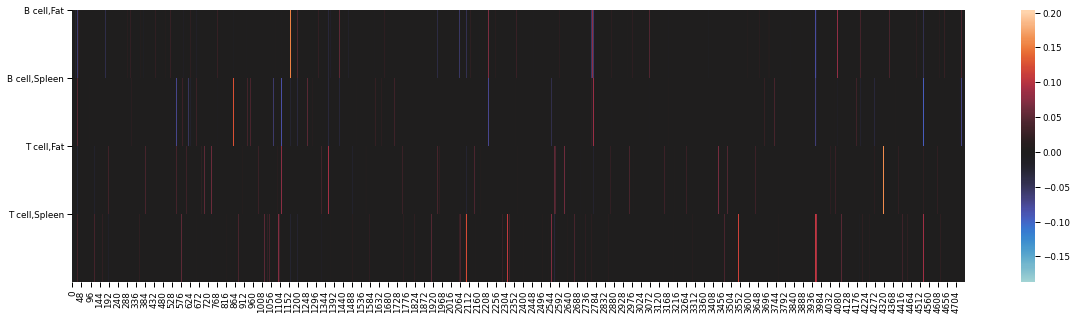

In [45]:
cp = Checkpoint(dirname='tm_checkpoints/non-sequential_l1')
net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=100,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.01) #

pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])
pipe.fit(X_train, y_train)
pipe['net'].initialize()
pipe['net'].load_params(checkpoint=cp)
eval_model(pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(net), le)

In [47]:
weights = pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata.var[['symbol']]
non_sequential_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
non_sequential_l1_result_df

B cell,Fat  B cell,Spleen     T cell,Fat T cell,Spleen
0           Krt15           Dtx1           Cd96        Podnl1
1   5730577I03Rik        Tacstd2           Ifng          Ccr9
2           Cenpa          Emid1          Chrne          Sit1
3         Bcl2a1d        Rapgef3          Lime1         Folr4
4            Ins1           Hes5          Tigit         Cxcr3
5           Pgap1  A230108P19Rik          Bend4          Cst7
6           Ctrb1           Pigr           Pkp4         Foxp3
7            Irf4           Haao        Tnfsf11         F2rl1
8           Cd274           Ell3           Fasl         Gpr68
9   5430427O19Rik  1600029D21Rik         Il18r1       Gm14446
10           Cdt1          Fcrl5  2610019F03Rik         Dapl1
11           Krt5        Edaradd            Txk        Enthd1
12         Crisp3          Chst3      Tnfrsf10b           Cd4
13            Ltf           Krt8    D18Ertd653e       Slc12a7
14        Slco4a1         Dennd3           Ccr8         Slfn1
15            Cpm  1700030K09Rik          Ramp3          Sla2
16         Gm6568        Fam129c          Ctla4       Ubash3a
17         Mapk11         Clec2g            NaN           NaN
18          Neil1          Bfsp2            NaN           NaN
19         Olfr98       BC035044            NaN           NaN

In [ ]:
generate_model_gene_module_reports(adata_subset, non_sequential_l1_result_df, "Non-sequential, L1 penalty", "tm_model_gene_module_reports/non_sequential_l1_penalty/")

### Quick gridsearch

In [48]:
shared_grid = {
    'net__max_epochs': [10, 20, 100],
    'net__lr': [0.01, 0.001],
    'net__optimizer': [torch.optim.Adam],
    'net__callbacks__lr_scheduler__factor': [0.5]
}
param_grid = copy.deepcopy(shared_grid)
param_grid['net__lambda_clf'] = [0.]
param_grid['net__regularization'] = ['l1']
param_grid['net__lambda_reg'] = [0., 0.001, 0.01, 0.1]

net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                               ],
                                     secondary_criterion_weight=celltype_class_weights)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])

gs_l1 = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=4, n_jobs=-1)

gs_l1.fit(X_train, y_train)
dump(gs_l1, 'tm_quick_gridsearch_l1.joblib') 

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   58.6s finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.9524             0.9641          0.6237        2.2201           0.0000           1.2153       0.6058        1.7229  0.0446
      2    0.9868             0.9908          0.7308        1.3231           0.0000           0.6254       0.7116        1.4807  0.0425
      3    0.9868             0.9908          0.7650        1.0885           0.0000           0.4917       0.7540        1.3201  0.0563
      4    0.9894             0.9927          0.7831        0.9664           0.0000           0.4656       0.7804        1.2148  0.0539
      5    0.9921             0.9945          0.7812        0.8975           0.0000           0.4584       0.7804        1.1483  0.0639
      6    0.9921             0.9945          0.

['tm_quick_gridsearch_l1.joblib']

{'net__callbacks__lr_scheduler__factor': 0.5, 'net__lambda_clf': 0.0, 'net__lambda_reg': 0.01, 'net__lr': 0.001, 'net__max_epochs': 20, 'net__optimizer': <class 'torch.optim.adam.Adam'>, 'net__regularization': 'l1'}
train acc:         0.9195767195767196
test acc:          0.7527733755942948
test balanced acc: 0.750979020979021
classification report:
               precision    recall  f1-score   support

   B cell,Fat       0.58      0.69      0.63       130
B cell,Spleen       0.86      0.77      0.81       325
   T cell,Fat       0.77      0.69      0.73        88
T cell,Spleen       0.70      0.85      0.77        88

     accuracy                           0.75       631
    macro avg       0.73      0.75      0.74       631
 weighted avg       0.77      0.75      0.76       631

test CT acc: 0.8779714703559875
test CT balanced acc: 0.9119005994005994

Overall sparsity: 0.3152428320655354
fraction of weights that are zero:
B cell,Fat: 0.2960795787009947
B cell,Spleen: 0.28476692022

0.3152428320655354

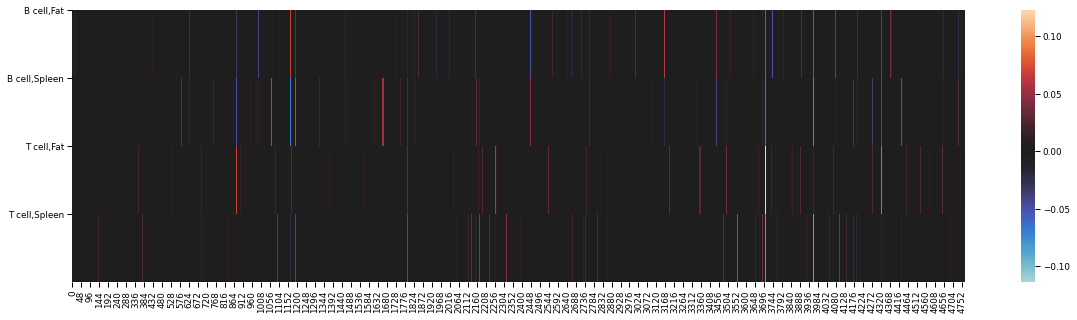

In [49]:
print(gs_l1.best_params_)
eval_model(gs_l1.best_estimator_, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(gs_l1.best_estimator_['net'], np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(gs_l1.best_estimator_['net'], np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(gs_l1.best_estimator_['net']), le)

In [50]:
weights = gs_l1.best_estimator_['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata.var[['symbol']]
gs_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
gs_l1_result_df

B cell,Fat  B cell,Spleen     T cell,Fat T cell,Spleen
0           Krt15           Dtx1          Lime1          Sit1
1   5730577I03Rik        Tacstd2            Txk          Ccr9
2           Cenpa          Emid1           Ifng         F2rl1
3          Zc3h10        Rapgef3        Tnfsf11         Foxp3
4            Ins1           Hes5            Cd6       Gm11346
5           Pgap1  A230108P19Rik      Tnfrsf10b       Ubash3a
6            Irf4           Pigr    D18Ertd653e         Tgtp1
7           Cd274      Hist1h2ac          Camk4           Cd5
8   5430427O19Rik           Haao          Tigit         Folr4
9            Cdt1           Cnr2          Ctla4          Cst7
10           Krt5           Ell3          Chrne         Gpr68
11         Crisp3          Fcrl5           Fasl           Cd4
12            Ltf        Edaradd  2610019F03Rik       Slc12a7
13        Slco4a1          Chst3      Bambi-ps1         Slfn1
14          Pcsk2           Krt8          Bend4        Podnl1
15            Cpm         Dennd3          Ramp3         Cxcr3
16         Gm6568  1700030K09Rik           Pkp4       Gm14446
17      Rps19-ps3        Fam129c           Cd96         Dapl1
18         Mapk11          Bfsp2           Ccr8          Sla2
19          Neil1       BC035044            NaN           NaN

### Best settings long training

  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9471             0.9575          0.6379        2.2139           0.0000           1.2214       0.5979        1.7210     +  0.0367
      2    0.9868             0.9908          0.7382        1.3106           0.0000           0.6261       0.6958        1.4756     +  0.0419
      3    0.9868             0.9908          0.7678        1.0819           0.0000           0.4899       0.7487        1.3181     +  0.0425
      4    0.9894             0.9927          0.7803        0.9645           0.0000           0.4652       0.7751        1.2045     +  0.0487
      5    0.9894             0.9927          0.7829        0.8968           0.0000           0.4595       0.7804        1.1396     +  0.0546
      

0.859371952408816

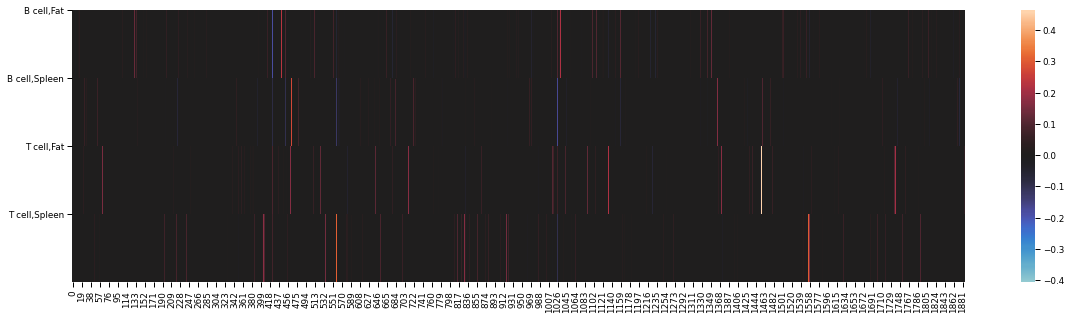

In [51]:
cp = Checkpoint(dirname='tm_checkpoints/non-sequential_l1')
best_l1_net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=200,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.01) #

best_l1_pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', best_l1_net),
    ])
best_l1_pipe.fit(X_train, y_train)
best_l1_pipe['net'].initialize()
best_l1_pipe['net'].load_params(checkpoint=cp)
eval_model(best_l1_pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(best_l1_net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(best_l1_net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(best_l1_net), le)

In [52]:
dump(best_l1_pipe, 'tm_best_l1.joblib')

['tm_best_l1.joblib']

In [53]:
best_l1_pipe = load('tm_best_l1.joblib') 

In [55]:
weights = best_l1_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata.var[['symbol']]
best_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
best_l1_result_df

B cell,Fat  B cell,Spleen     T cell,Fat T cell,Spleen
0           Krt15      Hist1h2an          Klra7          Sit1
1   5730577I03Rik           Dtx1          Lime1          Ccr9
2           Cenpa        Rapgef3            Txk         Foxp3
3            Ins1  A230108P19Rik           Ifng         Crtam
4           Pgap1           Pigr        Tnfsf11   Slc2a4rg-ps
5            Irf4         Zfp784          Cd226         Folr4
6           Cd274          Apoa2      Tnfrsf10b          Cst7
7   5430427O19Rik           Haao    D18Ertd653e         Gpr68
8            Cdt1           Ell3          Tigit           Cd4
9            Krt5          Fcrl5          Ctla4       Slc12a7
10         Crisp3        Edaradd          Chrne         Ikzf2
11            Ltf           Rfc3           Fasl       Gm12505
12        Slco4a1          Chst3  2610019F03Rik         Slfn1
13          Pcsk2           Krt8          Bend4         Sez6l
14            Cpm         Dennd3          Ramp3        Podnl1
15      Rps19-ps3  1700030K09Rik           Pkp4         Cxcr3
16         Gm6568        Fam129c           Aqp3       Gm14446
17     D2Ertd750e         Clec2g          Egln3         Dapl1
18         Mapk11  2210020M01Rik           Ccr8          Sla2
19          Neil1       BC035044            NaN           NaN

In [58]:
# De enrichment:
weights = best_l1_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata.var[['symbol']]
_, exclusive_scores = get_exclusive_model_weights_for_gsea(weights, le.classes_, feature_symbols, verbose=False)
len(exclusive_scores)
enrich_folder = Path("tm_paper_figs") / "best_l1_enrich"
enrich_folder.mkdir(exist_ok=True, parents=True)
for label, score_df in exclusive_scores.items():
    print(label)
    print(score_df.shape)
    save_file = enrich_folder / f"best_l1_{label}_GO_enrich.tex"
    do_enrich(score_df['symbol'].tolist(), score_df['weight'], all_genes_info['symbol'], save_file)

B cell,Fat
(20, 2)


NameError: name 'all_genes_info' is not defined

### Extra penalty long training

  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9215             0.9513          0.7779        1.8971           0.0000           1.0082       0.7788        1.5852     +  1.6780
      2    0.9273             0.9518          0.7820        1.4509           0.0000           0.7321       0.7828        1.4949     +  1.6491
      3    0.9233             0.9484          0.7685        1.4045           0.0000           0.6999       0.7680        1.4806     +  1.6811
      4    0.9238             0.9474          0.7746        1.3867           0.0000           0.6966       0.7694        1.4661     +  1.7015
      5    0.9238             0.9456          0.7719        1.3765           0.0000           0.6855       0.7658        1.4655     +  1.8203
      

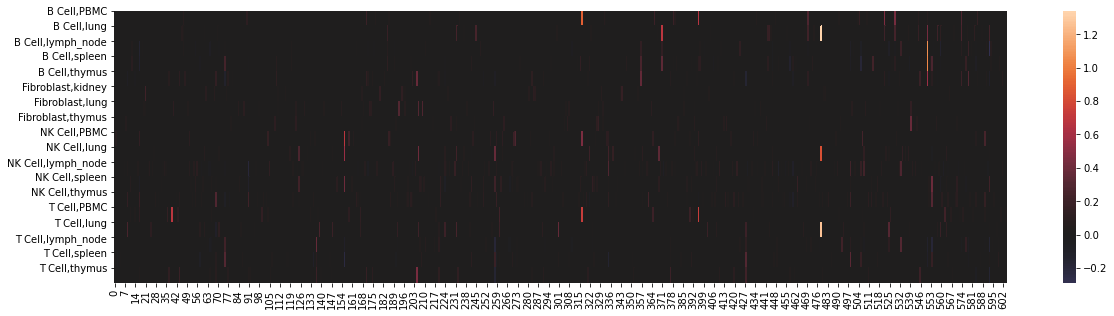

In [58]:
cp = Checkpoint(dirname='tm_checkpoints/non-sequential_l1')
extra_pen_l1_net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=200,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.005) #

extra_pen_l1_pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', extra_pen_l1_net),
    ])
extra_pen_l1_pipe.fit(X_train, y_train)
extra_pen_l1_pipe['net'].initialize()
extra_pen_l1_pipe['net'].load_params(checkpoint=cp)
eval_model(extra_pen_l1_pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(extra_pen_l1_net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(extra_pen_l1_net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(extra_pen_l1_net), le)

In [113]:
dump(extra_pen_l1_pipe, 'tm_extra_pen_l1.joblib')

['extra_pen_l1.joblib']

In [49]:
extra_pen_l1_pipe = load('tm_extra_pen_l1.joblib') 

In [50]:
weights = extra_pen_l1_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata.var[['symbol']]
extra_pen_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
extra_pen_l1_result_df

B Cell,PBMC B Cell,lung B Cell,lymph_node B Cell,spleen B Cell,thymus  \
0         ACP5    SERPINB9            PDLIM1         BANK1        TUBA1B   
1         NRP2      ZBTB20           HLA-DMB         RPL15    ATP2B1-AS1   
2        ORAI2        ND4L             RBM38          HES4         PRDX1   
3       SQSTM1     CARMIL1            UBALD2         H2AC6          CD82   
4       IFNGR2        INSR             OTUD1        HSPA1B        IFI44L   
5     MIR155HG      JCHAIN             SNHG7           NaN           NaN   
6         CCR7   LINC01781         LINC00926           NaN           NaN   
7        SESN3         NaN               NaN           NaN           NaN   
8       GPR183         NaN               NaN           NaN           NaN   
9        EVI2B         NaN               NaN           NaN           NaN   
10         NaN         NaN               NaN           NaN           NaN   
11         NaN         NaN               NaN           NaN           NaN   
12         NaN         NaN               NaN           NaN           NaN   
13         NaN         NaN               NaN           NaN           NaN   
14         NaN         NaN               NaN           NaN           NaN   
15         NaN         NaN               NaN           NaN           NaN   
16         NaN         NaN               NaN           NaN           NaN   
17         NaN         NaN               NaN           NaN           NaN   
18         NaN         NaN               NaN           NaN           NaN   
19         NaN         NaN               NaN           NaN           NaN   

   Fibroblast,kidney Fibroblast,lung Fibroblast,thymus NK Cell,PBMC  \
0              PALLD            EMP1            RNASE1        RAMP1   
1             ADAM12           TIMP1             NDRG2         LAT2   
2              ITGA1              C3              TPM2        RSAD2   
3                DST            CNN3            COL6A1         GNG2   
4               NRP1            CST3             MGST1         FEZ1   
5             CYP1B1          COL6A2             HTRA1       CHST12   
6             FRMD4A             FN1              CD14       HAVCR2   
7            EMILIN1            MT1X               GSN        IFIT3   
8               NID1            CTTN               OAF        LIMD2   
9            GUCY1A1          CYBRD1              CD36        TGFB1   
10              PSD3            UGDH             PLPP3        IFIT2   
11            SLC8A1          TCEAL9              GPX3          NaN   
12             PTGR1             CLU              EGR1          NaN   
13              SPP1              F3             PLIN2          NaN   
14             LAMB1           CALD1              CAV1          NaN   
15           COL18A1            NBL1               NaN          NaN   
16            PRXL2A             NaN               NaN          NaN   
17              VCAN             NaN               NaN          NaN   
18             THBS1             NaN               NaN          NaN   
19             APOL1             NaN               NaN          NaN   

   NK Cell,lung NK Cell,lymph_node NK Cell,spleen NK Cell,thymus T Cell,PBMC  \
0         NOL4L            SERTAD1            NCL          IFI27      ATP1A1   
1        AKR1C3               HOPX         DYNLL1          DUSP2    LEPROTL1   
2          PSAP             H2BC12         CEMIP2          NR4A1         LAT   
3           LYZ             TOMM40         PIK3R1         TUBB4B        RORA   
4       PIP4K2A             LZTFL1         METRNL        PTPRCAP        MIAT   
5         PTGDS               TCP1            NaN            NaN     PPP2R5C   
6        B3GNT7              PLIN3            NaN            NaN      PABPC1   
7           NaN               NQO2            NaN            NaN      GIMAP5   
8           NaN               TESC            NaN            NaN         nan   
9           NaN           SEPTIN11            NaN            NaN     S100A11   
10          NaN               LYAR

In [106]:
# De enrichment:
weights = extra_pen_l1_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
_, exclusive_scores = get_exclusive_model_weights_for_gsea(weights, le.classes_, feature_symbols, verbose=False)
len(exclusive_scores)
enrich_folder = Path("tm_paper_figs") / "extra_pen_l1_enrich"
enrich_folder.mkdir(exist_ok=True)
for label, score_df in exclusive_scores.items():
    print(label)
    print(score_df.shape)
    save_file = enrich_folder / f"extra_pen_l1_{label}_GO_enrich.tex"
    do_enrich(score_df['symbol'].tolist(), score_df['weight'], all_genes_info['symbol'], save_file)

B Cell,PBMC
(10, 2)
0.20074807
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,lung
(7, 2)
0.24471396
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
                                                set      pval      qval  \
4937  GOBP_POSITIVE_REGULATION_OF_RESPIRATORY_BURST  0.000003  0.022832   

      intersection  reference  enquiry  background  
4937             2          5        7       11646  
B Cell,lymph_node
(7, 2)
0.0843629
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,spleen
(5, 2)
0.22787882
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT


## Non-sequential classifier w/Exclusive L1

In [ ]:
cp = Checkpoint(dirname='tm_checkpoints/non-sequential_exclusive_l1')
net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='exclusive_l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=100,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.5) #

pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])
pipe.fit(X_train, y_train)
pipe['net'].initialize()
pipe['net'].load_params(checkpoint=cp)
eval_model(pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(net), le)

In [ ]:
weights = pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata.var[['symbol']]
non_sequential_exclusive_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
non_sequential_exclusive_l1_result_df

In [ ]:
# generate_model_gene_module_reports(adata_subset, non_sequential_exclusive_l1_result_df, "Non-sequential, Exclusive L1 penalty", "model_gene_module_reports/non_sequential_exclusive_l1_penalty/")

### Quick gridsearch

In [42]:
shared_grid = {
    'net__max_epochs': [10, 20, 100],
    'net__lr': [0.01, 0.001],
    'net__optimizer': [torch.optim.Adam],
    'net__callbacks__lr_scheduler__factor': [0.5]
}
param_grid = copy.deepcopy(shared_grid)
param_grid['net__lambda_clf'] = [0.]
param_grid['net__regularization'] = ['exclusive_l1']
param_grid['net__lambda_reg'] = [0., 0.001, 0.01, 0.1]

net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                               ],
                                     secondary_criterion_weight=celltype_class_weights)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])

gs_ex = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=2, n_jobs=-1)

gs_ex.fit(X_train, y_train)
dump(gs_ex, 'tm_quick_gridsearch_exl1.joblib')

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 31.9min finished


  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ------
      1    0.8966             0.9383          0.7715        1.7600           0.0000           0.9548       0.7659        1.5464  1.8867
      2    0.9253             0.9505          0.7791        1.3133           0.0000           0.6394       0.7861        1.4366  1.8359
      3    0.9259             0.9501          0.7739        1.2627           0.0000           0.6157       0.7840        1.4166  1.9284
      4    0.9297             0.9514          0.7718        1.2479           0.0000           0.6064       0.7857        1.4025  1.9410
      5    0.9286             0.9498          0.7708        1.2395           0.0000           0.5992       0.7871        1.3924  1.8935
      6    0.9294             0.9492          0.

['quick_gridsearch_exl1.joblib']

{'net__callbacks__lr_scheduler__factor': 0.5, 'net__lambda_clf': 0.0, 'net__lambda_reg': 0.1, 'net__lr': 0.001, 'net__max_epochs': 10, 'net__optimizer': <class 'torch.optim.adam.Adam'>, 'net__regularization': 'exclusive_l1'}
train acc:         0.7994580809690788
test acc:          0.7822192470753243
test balanced acc: 0.7695622404304376
classification report:
                    precision    recall  f1-score   support

       B Cell,PBMC       0.89      0.99      0.94       210
       B Cell,lung       0.90      0.95      0.93      1635
 B Cell,lymph_node       0.70      0.58      0.64      3321
     B Cell,spleen       0.77      0.75      0.76      4085
     B Cell,thymus       0.41      0.50      0.45      1204
 Fibroblast,kidney       0.86      0.86      0.86        29
   Fibroblast,lung       0.98      0.97      0.98       546
 Fibroblast,thymus       0.89      0.97      0.93       111
      NK Cell,PBMC       0.71      0.95      0.81       720
      NK Cell,lung       0.88      0.

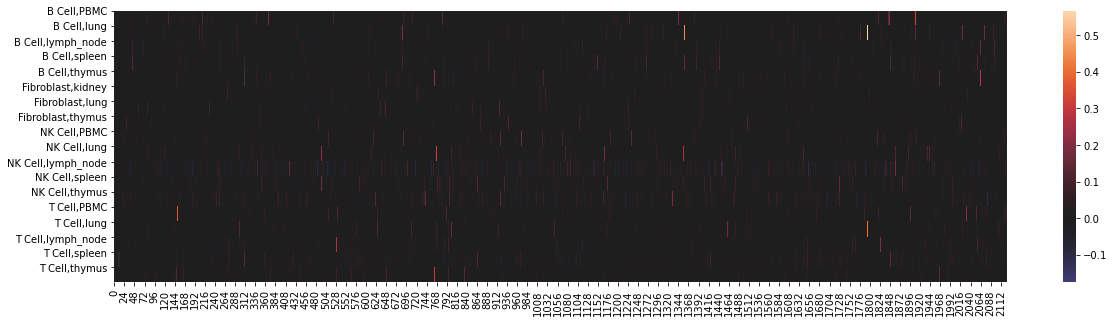

In [43]:
print(gs_ex.best_params_)
eval_model(gs_ex.best_estimator_, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(gs_ex.best_estimator_['net'], np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(gs_ex.best_estimator_['net'], np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(gs_ex.best_estimator_['net']), le)

In [44]:
weights = gs_ex.best_estimator_['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata.var[['symbol']]
gs_exclusive_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
gs_exclusive_l1_result_df

B Cell,PBMC B Cell,lung B Cell,lymph_node B Cell,spleen B Cell,thymus  \
0        FNBP1        ND4L             OTUD1         HSPD1         PRDX1   
1        CMSS1    SERPINB9              FCMR          SPIB       SERTAD1   
2       IFNGR2      JCHAIN            POU2F2        HSPA1B        IFI44L   
3         ACP5      ZBTB20            UBALD2          CD55       RETREG1   
4      FAM107B   LINC01781             DERL3          GNG7          CD82   
5       GPR183       IFI30             SNHG7          HES4        TUBA1B   
6        MEF2C    HLA-DRB5             RBM38           NaN    ATP2B1-AS1   
7         LSM7     MARCHF1            SWAP70           NaN           NaN   
8        EVI2B        IRF8         LINC00926           NaN           NaN   
9        TCEA1         nan               NaN           NaN           NaN   
10       ORAI2     CARMIL1               NaN           NaN           NaN   
11        CCR7         NaN               NaN           NaN           NaN   
12     ZFP36L1         NaN               NaN           NaN           NaN   
13        ELK3         NaN               NaN           NaN           NaN   
14       SESN3         NaN               NaN           NaN           NaN   
15       CHPT1         NaN               NaN           NaN           NaN   
16         NaN         NaN               NaN           NaN           NaN   
17         NaN         NaN               NaN           NaN           NaN   
18         NaN         NaN               NaN           NaN           NaN   
19         NaN         NaN               NaN           NaN           NaN   

   Fibroblast,kidney Fibroblast,lung Fibroblast,thymus NK Cell,PBMC  \
0              THBS1          CYBRD1              CYGB         GNG2   
1               ACO1       MIR4458HG            COL6A1       HAVCR2   
2              PALLD            UAP1             NDRG2        SLFN5   
3              ITGA1            MT1X               GSN        IFIT3   
4               NRP1             CLU          CDC42EP4        RSAD2   
5              SYNE2          AKAP12              CAV1        LASP1   
6           CCDC102B           TIMP1             MGST1        UBE2F   
7            GUCY1A1              F3              HBA1        LIMD2   
8             PRXL2A            MT1E             PLPP3        PRMT2   
9            COL18A1           FSTL3            COL1A1       CHST12   
10               DST            NBL1               CFD        RAMP1   
11             APOL1            EMP1             PLIN2        TGFB1   
12             LAMB1           TIMP2              GPX3      C1orf21   
13              DDR2            CNN3              TPM2         FEZ1   
14            CYP1B1            FHL1             SPARC        WIPF1   
15              VCAN          TCEAL9            RNASE1        TNIP1   
16           EMILIN1           CALD1              CD36          NaN   
17            ADAM12            CTTN          SERPINF1          NaN   
18              NID1              C3             HTRA1          NaN   
19              SPP1             NaN               NaN          NaN   

   NK Cell,lung NK Cell,lymph_node NK Cell,spleen NK Cell,thymus T Cell,PBMC  \
0         PLAC8             TOMM40          NEAT1            VIM        MIAT   
1      CDC42SE1              ITGAX          KLRG1           RGS2       EVI2A   
2        AKR1C3             TSPAN3         PIK3R1          IFI27       CAMK4   
3       PIP4K2A             NDUFV1         CEMIP2         TENT5C       ADTRP   
4         SPON2             ORMDL2            NCL           LYAR         LAT   
5         SERF2               ECE1         PTPN12          NR4A1      ATP1A1   
6        IGFBP7             H2BC12         METRNL         LGALS3        RPL9   
7          PSAP               NQO2            NaN          IFIT2    CDC42SE2   
8         NOL4L              DNAI7            NaN           RGCC     PPP2R5C   
9          HOPX                PGP            NaN        SPATS2L       CYTOR   
10         MT2A               TCP1

### Best settings long training

  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9130             0.9461          0.7781        1.7637           0.0000           0.9587       0.7783        1.5224     +  2.1700
      2    0.9269             0.9506          0.7707        1.3093           0.0000           0.6373       0.7871        1.4164     +  2.1431
      3    0.9246             0.9494          0.7734        1.2577           0.0000           0.6148       0.7850        1.4090     +  2.4208
      4    0.9281             0.9498          0.7695        1.2455           0.0000           0.6041       0.7875        1.4102        2.6104
      5    0.9294             0.9497          0.7719        1.2372           0.0000           0.5999       0.7853        1.4104        2.5653
      

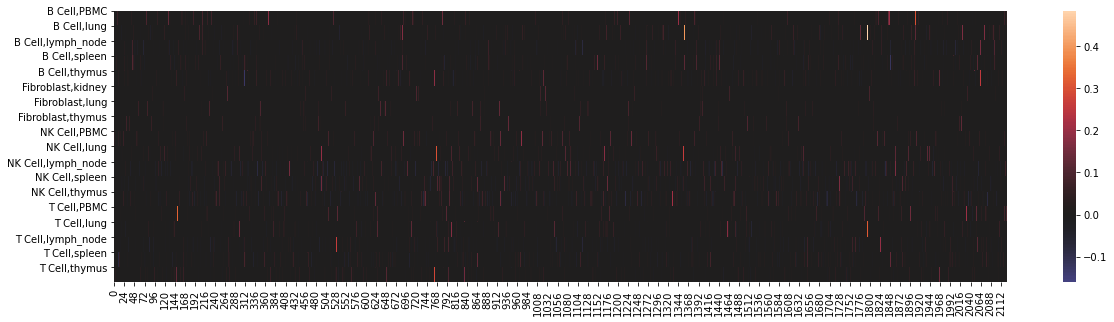

In [46]:
cp = Checkpoint(dirname='tm_checkpoints/non-sequential_exclusive_l1')
best_ex_net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='exclusive_l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=200,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.1) #

best_ex_pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', best_ex_net),
    ])
best_ex_pipe.fit(X_train, y_train)
best_ex_pipe['net'].initialize()
best_ex_pipe['net'].load_params(checkpoint=cp)
eval_model(best_ex_pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(best_ex_net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(best_ex_net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(best_ex_net), le)

In [110]:
dump(best_ex_pipe, 'tm_best_exl1.joblib')

['best_exl1.joblib']

In [51]:
best_ex_pipe = load('tm_best_exl1.joblib') 

In [52]:
weights = best_ex_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata.var[['symbol']]
best_exclusive_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
best_exclusive_l1_result_df

B Cell,PBMC B Cell,lung B Cell,lymph_node B Cell,spleen B Cell,thymus  \
0         ACP5    HLA-DRB5            POU2F2          SPIB        TUBA1B   
1        ORAI2    SERPINB9             MEF2C         HSPD1          NEK6   
2       SQSTM1       IFI30              TCF4       TAMALIN        HIVEP3   
3       IFNGR2     MARCHF1             RBM38          HES4    ATP2B1-AS1   
4      FAM107B      ZBTB20            UBALD2         H2AC6         PRDX1   
5     MIR155HG        ND4L              FCMR        HSPA1B          CD82   
6         CCR7     CARMIL1             OTUD1          CD55        IFI44L   
7        SESN3        IRF8             SNHG7           NaN           NaN   
8         LSM7      JCHAIN         LINC00926           NaN           NaN   
9        TCEA1   LINC01781            SWAP70           NaN           NaN   
10       CHPT1         NaN               NaN           NaN           NaN   
11        ELK3         NaN               NaN           NaN           NaN   
12      GPR183         NaN               NaN           NaN           NaN   
13       EVI2B         NaN               NaN           NaN           NaN   
14     ZFP36L1         NaN               NaN           NaN           NaN   
15       FNBP1         NaN               NaN           NaN           NaN   
16         NaN         NaN               NaN           NaN           NaN   
17         NaN         NaN               NaN           NaN           NaN   
18         NaN         NaN               NaN           NaN           NaN   
19         NaN         NaN               NaN           NaN           NaN   

   Fibroblast,kidney Fibroblast,lung Fibroblast,thymus NK Cell,PBMC  \
0              PALLD            EMP1             NDRG2        RAMP1   
1             ADAM12           TIMP1             HTRA1        GCHFR   
2              ITGA1          TCEAL9              CD14        RSAD2   
3                DST             CLU            IGFBP4         GNG2   
4               NRP1        SERPING1               CFD        SLFN5   
5             CYP1B1            CNN3             MGST1         FEZ1   
6             FRMD4A          AKAP12               GSN        LASP1   
7            EMILIN1           TIMP2             SPARC        IFIT3   
8               NID1            UAP1              TPM2       CHST12   
9            GUCY1A1          CYBRD1            COL6A1       HAVCR2   
10              PSD3              F3               OAF        LIMD2   
11              SPP1            MT1E              CAV1        WIPF1   
12          CCDC102B            NBL1            COL1A1        TGFB1   
13             LAMB1            DDR2            RNASE1      C1orf21   
14           COL18A1              C3              HBA1        UBE2F   
15            PRXL2A            MT1X          SERPINF1        PRMT2   
16              VCAN            CTTN            FAM20C        TNIP1   
17             THBS1            UGDH              GPX3          NaN   
18             APOL1           CALD1              CD36          NaN   
19              ACO1            CST3             PLPP3          NaN   

   NK Cell,lung NK Cell,lymph_node NK Cell,spleen NK Cell,thymus T Cell,PBMC  \
0          HOPX             H2BC12            NCL          IFI27    LEPROTL1   
1         NOL4L             TOMM40          KLRG1          BCAS2      PABPC1   
2         SERF2             LZTFL1          NEAT1          DUSP2       ZNF90   
3        AKR1C3               TCP1         DNAJC1           RGS2    CDC42SE2   
4      CDC42SE1             ERLEC1          APMAP         TUBB4B        RORA   
5          PSAP              PLIN3         PIK3R1          IFIT2       BIRC2   
6          MT2A              ACAA2         CEMIP2        SPATS2L     PPP2R5C   
7         PLAC8               FLNB            FYN         LGALS3       ADTRP   
8       PIP4K2A               ADAR         METRNL          NR4A1        MIAT   
9         PTGDS               NQO2            NaN           RGCC      GIMAP5   
10       B3GNT7                PGP

In [103]:
# De enrichment:
weights = best_ex_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
_, exclusive_scores = get_exclusive_model_weights_for_gsea(weights, le.classes_, feature_symbols, verbose=False)
len(exclusive_scores)
enrich_folder = Path("tm_paper_figs") / "extra_pen_exl1_enrich"
enrich_folder.mkdir(exist_ok=True)
for label, score_df in exclusive_scores.items():
    print(label)
    print(score_df.shape)
    save_file = enrich_folder / f"best_ex_{label}_GO_enrich.tex"
    do_enrich(score_df['symbol'].tolist(), score_df['weight'], all_genes_info['symbol'], save_file)

B Cell,PBMC
(16, 2)
0.1995198
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,lung
(10, 2)
0.19565041
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,lymph_node
(10, 2)
0.10291451
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,spleen
(7, 2)
0.21171467
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
B Cell,thymus
(7, 2)
0.16114938
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
NONE SIGNIFICANT
Fibroblast,kidney
(20, 2)
0.16413306
INFO:diffxp

### Extra penalty long training

  epoch    CT_acc    CT_balanced_acc    balanced_acc    train_loss    train_loss_CT    train_loss_ML    valid_acc    valid_loss    cp     dur
-------  --------  -----------------  --------------  ------------  ---------------  ---------------  -----------  ------------  ----  ------
      1    0.9132             0.9443          0.7014        2.6901           0.0000           1.5256       0.7129        2.4668     +  4.4509
      2    0.9163             0.9431          0.7048        2.4105           0.0000           1.3124       0.7078        2.5050        4.0092
      3    0.9154             0.9399          0.7100        2.3992           0.0000           1.2785       0.7034        2.4768        4.5843
      4    0.9229             0.9441          0.6985        2.3925           0.0000           1.2667       0.7116        2.4399     +  4.6898
      5    0.9183             0.9396          0.7026        2.3848           0.0000           1.2562       0.7065        2.4671        4.8137
      

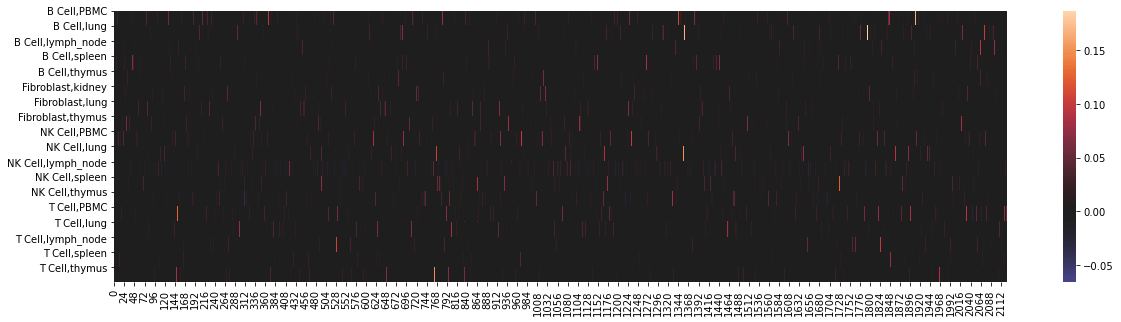

In [56]:
cp = Checkpoint(dirname='checkpoints/non-sequential_exclusive_l1')
extra_pen_ex_net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     regularization='exclusive_l1',
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     max_epochs=200,
                                     optimizer=torch.optim.Adam,
                                     lr=0.001,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                                ('checkpoint', cp),
                                               ],
                                     lambda_clf=0.,
                                     secondary_criterion_weight=celltype_class_weights,
                                     lambda_reg=0.5) #

extra_pen_ex_pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', extra_pen_ex_net),
    ])
extra_pen_ex_pipe.fit(X_train, y_train)
extra_pen_ex_pipe['net'].initialize()
extra_pen_ex_pipe['net'].load_params(checkpoint=cp)
eval_model(extra_pen_ex_pipe, X_train, y_train, X_test, y_test, le)
test_ct_acc = ct_acc_score_fn(extra_pen_ex_net, np.asarray(X_test), y_test)
print(f"test CT acc: {test_ct_acc}")
test_ct_balanced_acc = ct_balanced_acc_score_fn(extra_pen_ex_net, np.asarray(X_test), y_test)
print(f"test CT balanced acc: {test_ct_balanced_acc}")
print()
check_sparsity(SkorchLRAdapter(extra_pen_ex_net), le)

In [111]:
dump(extra_pen_ex_pipe, 'extra_pen_exl1.joblib')

['extra_pen_exl1.joblib']

In [53]:
extra_pen_ex_pipe = load('extra_pen_exl1.joblib') 

In [54]:
weights = extra_pen_ex_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
extra_pen_exclusive_l1_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
extra_pen_exclusive_l1_result_df

B Cell,PBMC B Cell,lung B Cell,lymph_node B Cell,spleen B Cell,thymus  \
0       FKBP1A      TXNDC5           HLA-DMB          GNG7        TUBA1B   
1        EVI2B        INSR             RBM38         BANK1          NEK6   
2     HLA-DRB1    HLA-DQB1            UBALD2        FCGR2B       HLA-DOA   
3       SQSTM1       DERL3         LINC00926       UNC93B1          TCF4   
4     MIR155HG     MARCHF1            MAP4K4          HES4          LMO2   
5         CCR7        MZB1             PDE4B        HSPA1B           MX1   
6      ZFP36L1        ND4L              RHOH       RPL22L1         HSPB1   
7         ACP5   TNFRSF13C              H1-4           SYK         PRDX1   
8        ORAI2        IRF8             SNHG7        PDLIM1          MBD2   
9        BIRC3        EBF1             BEST1         HSPD1         ASAP1   
10       SESN3      BCL11A           HLA-DRA       TAMALIN        MMACHC   
11         ID3      ZBTB20            POU2F2          CD22         PRMT1   
12      GPR183       RPS17           TSPAN13         PARP1       RHOBTB2   
13        LSM7      JCHAIN             OTUD1         H2AC6    ATP2B1-AS1   
14      CYSTM1   LINC01781              USF2          CD55         RGS19   
15      IFNGR2    HLA-DRB5              NCF1          SPIB      RNASEH2B   
16     FAM107B    SERPINB9           LDLRAD4          CTSZ         MS4A1   
17    HLA-DQA1       IFI30            ADAM19      DNASE1L3          CD82   
18        CD58       DRAM2            SWAP70           MYC        IFI44L   
19         NaN    HLA-DPB1               NaN           NaN           NaN   

   Fibroblast,kidney Fibroblast,lung Fibroblast,thymus NK Cell,PBMC  \
0              PALLD           TIMP1             HTRA1        SLFN5   
1             ADAM12            EMP1              CD14         FEZ1   
2              ITGA1          PCOLCE               CFD         ZEB2   
3               TPM1          TCEAL9             MGST1        UBE2F   
4                DST             CLU               GSN        RAMP1   
5               NRP1        SERPING1             PLIN2        KLRC1   
6             CYP1B1            CNN3             SPARC        LASP1   
7            EMILIN1          AKAP12              TPM2        IFIT3   
8               NID1             CFH            COL6A1        WIPF1   
9            GUCY1A1          IFITM3              PLTP        TGFB1   
10              SPP1           TIMP2              CAV1        GCHFR   
11             LAMB1          CYBRD1            COL1A1       CHST12   
12           COL18A1              F3            RNASE1       HAVCR2   
13            PRXL2A            MT1E            FAM20C        HLA-B   
14             SYNE2            NBL1            COL6A2        MYO1F   
15             INHBA              C3              GPX3          ADA   
16              VCAN            MT1X              CD36         GNG2   
17             THBS1            CTTN             PLPP3        LIMD2   
18             APOL1           CALD1              RBP7      C1orf21   
19              ACO1            CST3              EGR1     APOBEC3G   

   NK Cell,lung NK Cell,lymph_node NK Cell,spleen NK Cell,thymus T Cell,PBMC  \
0          HOPX            SERTAD1          KLRG1          NR4A1    LEPROTL1   
1         SPON2              SPRY1          HSPH1          PPM1N      PABPC1   
2         NOL4L             ARPC5L         PTGER2          PTTG1         nan   
3         SERF2             CFAP45            FYN           IER3       ZNF90   
4        AKR1C3               SMOX          CEBPD        CDK2AP2         VIM   
5      CDC42SE1             LZTFL1           IRF1          UBE2S    CDC42SE2   
6         KLRD1              PLIN3          NEAT1        GADD45B   HNRNPA1L2   
7          GNLY              ACAA2         PIK3R1           H2AX        RORA   
8          MT2A               CD63           HBA2         CSRNP1       ADTRP   
9          CMC1           SEPTIN11         S100A9           RGS2     PPP2R5C   
10        PLAC8              ITGAX

In [104]:
# De enrichment:
weights = extra_pen_ex_pipe['net'].module_.linear.weight.detach().numpy()
feature_symbols = adata_subset.var[['symbol']]
_, exclusive_scores = get_exclusive_model_weights_for_gsea(weights, le.classes_, feature_symbols, verbose=False)
len(exclusive_scores)
enrich_folder = Path("paper_figs") / "extra_pen_exl1_enrich"
enrich_folder.mkdir(exist_ok=True)
for label, score_df in exclusive_scores.items():
    print(label)
    print(score_df.shape)
    save_file = enrich_folder / f"extra_pen_ex_{label}_GO_enrich.tex"
    do_enrich(score_df['symbol'].tolist(), score_df['weight'], all_genes_info['symbol'], save_file)

B Cell,PBMC
(19, 2)
0.16784331
INFO:diffxpy: 9618 overlaps found between refset (17949) and provided gene list (11646).
INFO:diffxpy: Found 102 empty sets, removing those.
                                                    set      pval      qval  \
382              GOBP_MYELOID_LEUKOCYTE_DIFFERENTIATION  0.000002  0.011688   
403            GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS  0.000004  0.015558   
2850                          GOBP_RESPONSE_TO_CYTOKINE  0.000012  0.028294   
1076           GOBP_I_KAPPAB_KINASE_NF_KAPPAB_SIGNALING  0.000020  0.034408   
447   GOBP_POSITIVE_REGULATION_OF_MYELOID_LEUKOCYTE_...  0.000023  0.034408   

      intersection  reference  enquiry  background  
382              5        129       19       11646  
403              9        898       19       11646  
2850             8        751       19       11646  
1076             5        216       19       11646  
447              3         35       19       11646  
B Cell,lung
(20, 2)
0.1872607
INFO:

### Build dataframe of results

train acc:         0.8024120709807672
test acc:          0.7855344107615313
test balanced acc: 0.75766956869833
classification report:
                    precision    recall  f1-score   support

       B Cell,PBMC       0.90      0.99      0.94       210
       B Cell,lung       0.90      0.96      0.93      1635
 B Cell,lymph_node       0.68      0.61      0.64      3321
     B Cell,spleen       0.78      0.71      0.75      4085
     B Cell,thymus       0.41      0.48      0.44      1204
 Fibroblast,kidney       0.93      0.86      0.89        29
   Fibroblast,lung       0.99      0.98      0.98       546
 Fibroblast,thymus       0.92      0.93      0.92       111
      NK Cell,PBMC       0.72      0.94      0.81       720
      NK Cell,lung       0.87      0.91      0.89      1764
NK Cell,lymph_node       0.05      0.15      0.07        34
    NK Cell,spleen       0.57      0.74      0.65       656
    NK Cell,thymus       0.16      0.56      0.24       133
       T Cell,PBMC      

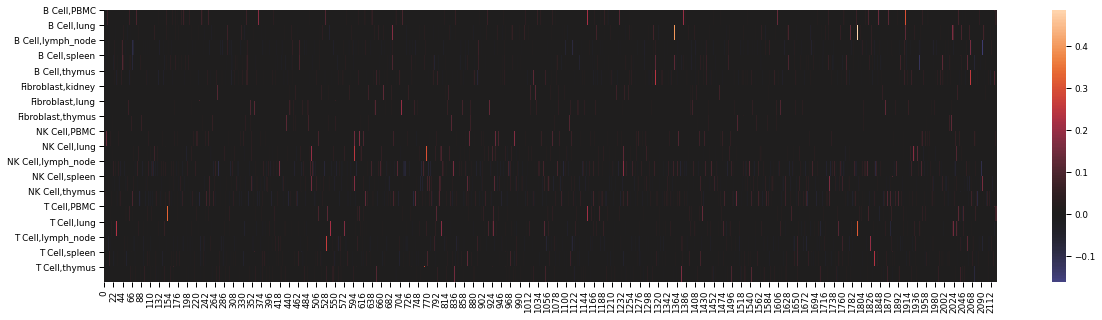

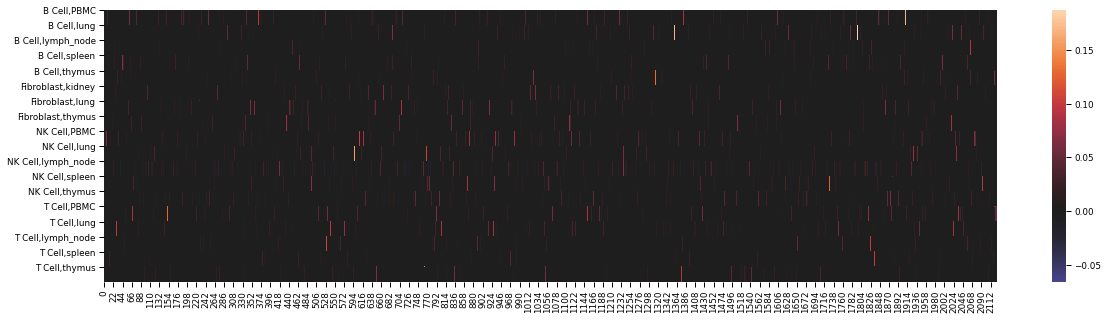

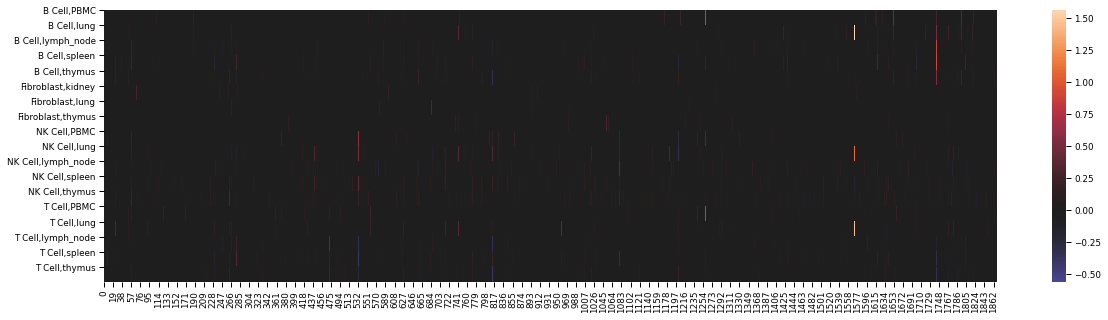

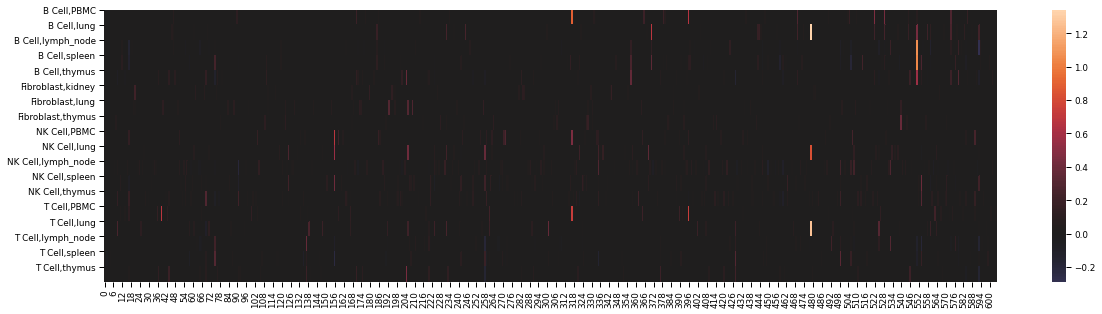

In [56]:
res_df = {
    'Regularization': ['Exclusive L1','Exclusive L1', 'L1', 'L1'],
    'Fit':['Best','Stronger penalty', 'Best','Stronger penalty'],
    'Test accuracy': [eval_model(best_ex_pipe, X_train, y_train, X_test, y_test, le),
                      eval_model(extra_pen_ex_pipe, X_train, y_train, X_test, y_test, le),
                      eval_model(best_l1_pipe, X_train, y_train, X_test, y_test, le),
                      eval_model(extra_pen_l1_pipe, X_train, y_train, X_test, y_test, le),
                     ],
    'Sparsity': [check_sparsity(SkorchLRAdapter(best_ex_pipe['net']), le),
                 check_sparsity(SkorchLRAdapter(extra_pen_ex_pipe['net']), le),
                 check_sparsity(SkorchLRAdapter(best_l1_pipe['net']), le),
                 check_sparsity(SkorchLRAdapter(extra_pen_l1_pipe['net']), le)
                ],
}
res_df = pd.DataFrame(res_df)
print(res_df)

In [57]:
palette = sns.color_palette("Blues")[2:4]

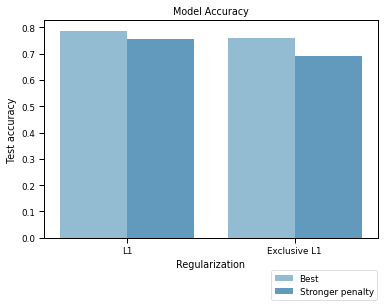

In [58]:
ax = sns.barplot(x="Regularization", y="Test accuracy", hue="Fit", data=res_df, order=['L1', 'Exclusive L1'], hue_order=['Best', 'Stronger penalty'], palette=palette)
ax.set_title('Model Accuracy')
#ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.13))

fig_folder = Path("paper_figs")
fig_folder.mkdir(exist_ok=True)

filename = "hubmap_test_accuracy"
plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
plt.show()

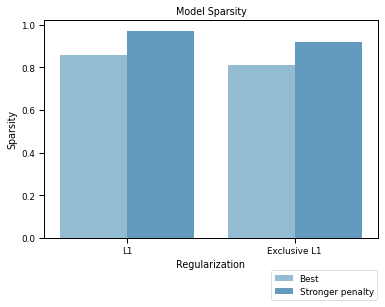

In [59]:
ax = sns.barplot(x="Regularization", y="Sparsity", hue="Fit", data=res_df, order=['L1', 'Exclusive L1'], hue_order=['Best', 'Stronger penalty'], palette=palette)
ax.set_title('Model Sparsity')
# ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.13))

fig_folder = Path("paper_figs")
fig_folder.mkdir(exist_ok=True)

filename = "hubmap_model_sparsity"
plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
plt.show()

In [60]:
# Marker yeilds
marker_df = pd.DataFrame.from_records([
best_l1_result_df.count().append(pd.Series({'Model': 'L1, Best'})),
extra_pen_l1_result_df.count().append(pd.Series({'Model': 'L1, Stronger penalty'})),
best_exclusive_l1_result_df.count().append(pd.Series({'Model': 'Exclusive L1, Best'})),
extra_pen_exclusive_l1_result_df.count().append(pd.Series({'Model': 'Exclusive L1, Stronger penalty'})),
])
print(marker_df.shape)
marker_df = pd.melt(marker_df, id_vars=['Model'], var_name = "Phenotype", value_name="Exclusive marker count")
print(marker_df)
marker_df['Phenotype'] = marker_df['Phenotype'].str.replace('_',' ')

(4, 19)
                             Model      Phenotype  Exclusive marker count
0                         L1, Best    B Cell,PBMC                       9
1             L1, Stronger penalty    B Cell,PBMC                      10
2               Exclusive L1, Best    B Cell,PBMC                      16
3   Exclusive L1, Stronger penalty    B Cell,PBMC                      19
4                         L1, Best    B Cell,lung                       4
..                             ...            ...                     ...
67  Exclusive L1, Stronger penalty  T Cell,spleen                      20
68                        L1, Best  T Cell,thymus                       2
69            L1, Stronger penalty  T Cell,thymus                       5
70              Exclusive L1, Best  T Cell,thymus                      10
71  Exclusive L1, Stronger penalty  T Cell,thymus                      20

[72 rows x 3 columns]


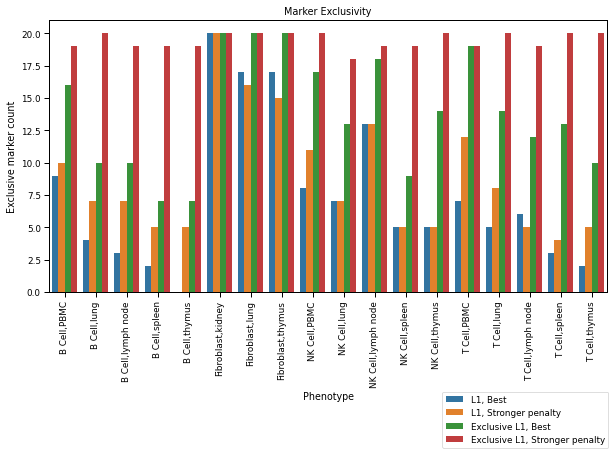

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="Phenotype",
                 y="Exclusive marker count",
                 hue="Model",
                 data=marker_df,
                 hue_order=['L1, Best', 'L1, Stronger penalty', 'Exclusive L1, Best', 'Exclusive L1, Stronger penalty'],
            ax=ax,
                 )
ax.set_title('Marker Exclusivity')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
# ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
ax.legend(loc='upper right', bbox_to_anchor=(1.01, -0.35))

fig_folder = Path("paper_figs")
fig_folder.mkdir(exist_ok=True)

filename = "hubmap_marker_exclusivity"
plt.savefig(fig_folder / f"{filename}.png", bbox_inches="tight")
plt.savefig(fig_folder / f"{filename}.pdf", bbox_inches="tight")
plt.show()

# Results - GridSearchCV

In [ ]:
shared_grid = {
    'net__max_epochs': [10, 20, 100, 200],
    'net__lr': [0.1, 0.01, 0.001, 0.0001],
    'net__optimizer': [torch.optim.SGD, torch.optim.Adam],
    'net__callbacks__lr_scheduler__factor': [0.1, 0.5]
}

In [ ]:
gs_results = {}

## non-Sequential models

### Un-regularized

In [ ]:
param_grid = copy.deepcopy(shared_grid)
param_grid['net__lambda_clf'] = [0.]
param_grid['net__regularization'] = [None]
param_grid['net__lambda_reg'] = [0.]

net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                # ('sparse_thresholder', SparseWeightsThresholder()),
                                               ],
                                     secondary_criterion_weight=celltype_class_weights)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])

gs = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=1)

gs.fit(X_train, y_train)
gs_results['non_sequential_unregularized'] = gs

### L1 regularization

In [ ]:
param_grid = copy.deepcopy(shared_grid)
param_grid['net__lambda_clf'] = [0.]
param_grid['net__regularization'] = ['l1']
param_grid['net__lambda_reg'] = [0.001, 0.01, 0.1, 1.0, 10.]

net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                               ],
                                     secondary_criterion_weight=celltype_class_weights)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])

gs = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=1)

gs.fit(X_train, y_train)
gs_results['non_sequential_l1'] = gs

### Exclusive L1 regularization

In [ ]:
param_grid = copy.deepcopy(shared_grid)
param_grid['net__lambda_clf'] = [0.]
param_grid['net__regularization'] = ['exclusive_l1']
param_grid['net__lambda_reg'] = [0.001, 0.01, 0.1, 1.0, 10.]

net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                               ],
                                     secondary_criterion_weight=celltype_class_weights)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])

gs = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=1)

gs.fit(X_train, y_train)
gs_results['non_sequential_exclusive_l1'] = gs

## Sequential models

### Un-regularized

In [ ]:
param_grid = copy.deepcopy(shared_grid)
param_grid['net__lambda_clf'] = [1.]
param_grid['net__regularization'] = [None]
param_grid['net__lambda_reg'] = [0.]

net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                # ('sparse_thresholder', SparseWeightsThresholder()),
                                               ],
                                     secondary_criterion_weight=celltype_class_weights)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])

gs = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=1)

gs.fit(X_train, y_train)
gs_results['sequential_unregularized'] = gs

### L1 regularization

In [ ]:
param_grid = copy.deepcopy(shared_grid)
param_grid['net__lambda_clf'] = [1.]
param_grid['net__regularization'] = ['l1']
param_grid['net__lambda_reg'] = [0.001, 0.01, 0.1, 1.0, 10.]

net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                               ],
                                     secondary_criterion_weight=celltype_class_weights)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])

gs = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=1)

gs.fit(X_train, y_train)
gs_results['sequential_l1'] = gs

### Exclusive L1 regularization

In [ ]:
param_grid = copy.deepcopy(shared_grid)
param_grid['net__lambda_clf'] = [1.0]
param_grid['net__regularization'] = ['exclusive_l1']
param_grid['net__lambda_reg'] = [0.001, 0.01, 0.1, 1.0, 10.]

net = SequentialMultiLabelClassifier(MultinomialLRModel,
                                     module__input_size=X_train.shape[1],
                                     module__output_size=len(le.classes_),
                                     ct_group_bounds=ct_bounds,
                                     ct_map=ct_map,
                                     criterion__weight=multilabel_class_weights,
                                     iterator_train__shuffle=True,
                                     callbacks=[('balanced_acc', balanced_acc),
                                                ('celltype_acc', ct_acc),
                                                ('celltype_balanced_acc', ct_balanced_acc),
                                                ('lr_scheduler', LRScheduler(policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                                                             factor=0.5, verbose=True)),
                                                ('train_loss_ML', PassthroughScoring(name='train_loss_ML', on_train=True)),
                                                ('train_loss_CT', PassthroughScoring(name='train_loss_CT', on_train=True)),
                                                ('sparse_thresholder', SparseWeightsThresholder()),
                                               ],
                                     secondary_criterion_weight=celltype_class_weights)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])

gs = GridSearchCV(pipe, param_grid, refit=True, cv=3, scoring='balanced_accuracy', verbose=1)

gs.fit(X_train, y_train)
gs_results['sequential_exclusive_l1'] = gs

In [ ]:
gs_results.keys()

In [ ]:
pickle.dump(gs_results, open("gs_results.p", "wb"))

# Ignore (old/scratch code)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.from_numpy(class_weights).float()

balanced_acc = EpochScoring(scoring='balanced_accuracy', lower_is_better=False)

net = LassoRegularizedLR(MultinomialLRModel(X_train.shape[1], len(le.classes_)),
                         criterion__weight=class_weights,
                         max_epochs=10,
                         optimizer=torch.optim.Adam,
                         lr=0.001,
                         iterator_train__shuffle=True,
                         callbacks=[balanced_acc, EnforceSparseWeights(eps=0.0001)],
                         lambda1=0.01) #
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])
pipe.fit(X_train, y_train)
eval_model(pipe, X_train, y_train, X_test, y_test)
check_sparsity(SkorchLRAdapter(net), le)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.from_numpy(class_weights).float()

balanced_acc = EpochScoring(scoring='balanced_accuracy', lower_is_better=False)

net = ExclusiveLassoRegularizedLR(MultinomialLRModel(X_train.shape[1], len(le.classes_)),
                                  criterion__weight=class_weights,
                                  max_epochs=10,
                                  optimizer=torch.optim.Adam, 
                                  lr=0.001,
                                  iterator_train__shuffle=True,
                                  callbacks=[balanced_acc, EnforceSparseWeights(eps=0.0001)],
                                  lambda1=0.5) #
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('net', net),
    ])
pipe.fit(X_train, y_train)
eval_model(pipe, X_train, y_train, X_test, y_test)
check_sparsity(SkorchLRAdapter(net), le)

## Sklearn's Logistic Regression (softmax classifier) (no penalty)

In [ ]:
sklearn_lr_nopen = LogisticRegression(penalty='none', multi_class='multinomial', solver='saga', class_weight='balanced', verbose=1, max_iter=100)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('lr', sklearn_lr_nopen),
    ])

pipe.fit(X_train, y_train)
eval_model(pipe, X_train, y_train, X_test, y_test)
check_sparsity(pipe.steps[3][1], le)

In [ ]:
weights = sklearn_lr_nopen.coef_
feature_symbols = adata_subset.var[['symbol']]
exclussive_lasso_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
exclussive_lasso_result_df

## Sklearn's Logistic Regression (softmax classifier) w/Lasso

In [ ]:
sklearn_lr_l1 = LogisticRegression(penalty='l1', C=0.1, multi_class='multinomial', solver='saga', class_weight='balanced', verbose=1, max_iter=100)
pipe = Pipeline([
        ('normalize_total', CellTotalCountNormalizer()),
        ('log', log_transformer),
        ('scale', StandardScaler()),
        ('lr', sklearn_lr_l1),
    ])

pipe.fit(X_train, y_train)
eval_model(pipe, X_train, y_train, X_test, y_test)
check_sparsity(pipe.steps[3][1], le)

In [ ]:
weights = sklearn_lr_l1.coef_
feature_symbols = adata_subset.var[['symbol']]
exclussive_lasso_result_df = find_exclusive_model_weights(weights, le.classes_, feature_symbols)
exclussive_lasso_result_df